In [ ]:
''' Analyse (nach Schritt 4)
Erstellen von zu untersuchenden Gruppen von Messwerten, 
herausfinden von statistischen Kennwerten und 
statistisches Gegenüberstellen.'''

In [1]:
import json 
import pandas as pd
import geopandas as gpd
import os

# Zum Erstellen eines runden Auswahlbereiches
from pyproj import CRS, Transformer
from shapely.ops import transform
from shapely.geometry import Point, Polygon  

import copy

import regex as re     #Regex
re.DEFAULT_VERSION=re.VERSION1
def regex_contains(s, rx):     #Pandas Funktion: str.contains() greift immer auf re zurück. Damit kein lookback mit variabler Länge möglich
    return bool(rx.search(s))  #daher an dieser Stelle eine Funktion, die an entsprechender Stelle mit .apply aufgerufen werden kann.

import glob                             #verwendung von 'wildacards' in Dateinamen
from tqdm import tqdm                   #fuer Darstellen eines Fortschrittsbalkens
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import contextily as ctx                #zum Einfügen von Hintergrundkarten
from matplotlib_scalebar.scalebar import ScaleBar  # Massstabsleiste
#from mpl_toolkits.basemap import Basemap    #zum Erstellen von Hintergrundkarten
import cartopy.crs as ccrs                  #zum Erstellen von Hintergrundkarten
import cartopy.io.img_tiles as cimgt
from cartopy import config

from IPython import get_ipython      #hm, weiß ich nicht mehr, waren aber zwei sachen.
from IPython.display import display   #um df formatiert darzustellen (alternative zu print())

import itertools      #um z.B. jedes Element einer Liste/df mit jedem anderen einmal zu kombinieren.

import pylab
import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy.stats as stats
from scipy.stats import anderson
from scipy.stats import jarque_bera
from scipy.stats import shapiro
from scipy.stats import wilcoxon 
from scipy.stats import norm

import math

import numpy as np
from numpy import polyfit

from pingouin import ttest
from pingouin import mwu

from datetime import date
import datetime as dt

from docx import Document   #Erlaubt das Erstellen und bearbeiten von docx Dokumenten
from io import BytesIO   #benötigt, um Plots in das docx zu bekommen (https://stackoverflow.com/questions/53536286/add-plots-directly-to-a-document-using-python-package-docx)
from docx.shared import Inches

#aktuelles Datum
from datetime import date
datum=date.today().strftime("%y%m%d")

#import warnings
from tsfresh.utilities.distribution import initialize_warnings_in_workers
initialize_warnings_in_workers(True)

print('import finished')

/home/lukas/anaconda3/envs/MA-working/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


import finished


In [6]:
path_OBS_OSM = '../OSM-OBS_klass'   #Ort an dem Klassifizierte gpkg-Datei (aus _1-3_Klassifizierung) liegt
#path_OBS_OSM = path_OBS_OSM + '/*230315.gpkg'
path_OBS_OSM = path_OBS_OSM + '/*.gpkg'


#liest alle obs-Dateien ein und packt sie in eine liste. 
files_OBS_OSM = glob.glob(path_OBS_OSM)

read_file = max(files_OBS_OSM, key=os.path.getctime)
read_file

'../OSM-OBS_klass/OSM-OBS_Klass_240213.gpkg'

In [7]:
gdf_klass=gpd.read_file(read_file) #klassifizierte und mit OSM gemergte OBS-Messwerte
gdf_klass['Radinfra'] = gdf_klass['Radinfra'].astype('string') #Datentyp String für Radinfra Spalte. Vorbereitung für das Auslesen.
gdf_klass['Geschwindigkeit_Numerisch'] = gdf_klass['Geschwindigkeit_Numerisch'].astype(float) #Datentyp float für Geschwindigkeit_Numerisch Spalte. Vorbereitung für das Auslesen.
gdf_klass['datetime_berlin'] = gdf_klass['datetime_berlin'].dt.tz_convert('Europe/Berlin')
gdf_klass['time_berlin'] = pd.to_datetime(gdf_klass['time_berlin'], format='%H:%M', utc=True)
gdf_klass['time_berlin_num'] = mdates.date2num(gdf_klass['time_berlin'])  #Zeit als Zahl, damit regplot damit was anfangen kann
gdf_klass['date_berlin'] = pd.to_datetime(gdf_klass['date_berlin'], format='%d.%m.%Y', utc=True) #Formatierung scheint nichts zu machen, ist trotzdem YYYY-MM-DD
gdf_klass['date_berlin_num'] = mdates.date2num(gdf_klass['date_berlin'])  #Datum als Zahl, damit regplot damit was anfangen kann
gdf_klass.head()

/home/lukas/anaconda3/envs/MA-working/lib/python3.9/site-packages/geopandas/io/file.py:364: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  as_dt = pd.to_datetime(df[k], errors="ignore")


,distance_overtaker,distance_stationary,direction,way_id,course,speed,time,portal,osm_id,name,highway,ref,maxspeed,zone_traffic,lanes,lane_markings,lit,surface,bicycle,cycleway,cycleway_both,cycleway_left,cycleway_right,width,tracktype,smoothness,oneway,cycleway_lane,cycleway_both_lane,cycleway_right_lane,cycleway_left_lane,parking_lane_both,parking_lane_left,parking_lane_right,cycleway_separation_left,cycleway_separation_right,separation_left,separation_right,cycleway_bicycle,cycleway_both_bicycle,...,cycleway_both_traffic_sign,cycleway_both_marking_both,cycleway_right_buffer_right,cycleway_left_buffer_right,cycleway_both_buffer_right,cycleway_right_buffer_left,cycleway_left_buffer_left,cycleway_both_buffer_left,cycleway_right_buffer_both,cycleway_left_buffer_both,cycleway_both_buffer_both,cycleway_marking_both,cycleway_marking_left,cycleway_marking,cycleway_right_marking,cycleway_left_marking,cycleway_traffic_sign,parking_orientation,other_tags,geometry_y,Radinfra,Radwegbreite,PufferRechts,PufferLinks,GG-Radstreifen,GG-Radwegbreite,GG-PufferRechts,GG-PufferLinks,Fahrstreifenbreite,FSBundRad,Kernfahrbahn,Fahrbahn_Fliessverkehr,Ortslage,Geschwindigkeit_Numerisch,datetime_berlin,time_berlin,date_berlin,geometry,time_berlin_num,date_berlin_num
0,NaN,2.64,1,141561211,2.956398,3.083333,2022-08-11 09:38:31+00:00,adfc-brandenburg,141561211,Universitätsstraße,tertiary,None,50,None,2,no,yes,asphalt,None,None,lane,None,None,8,None,intermediate,None,None,advisory,None,None,None,None,None,None,None,None,None,None,None,...,none,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,"""maxspeed:conditional""=>""30 @ (Mo-Fr 07:00-17:...","LINESTRING (14.3269026 51.7658807, 14.3268727 ...","1,Schutzstreifen,VZ:kein_VZ, linkeM_DL, rechte...",1.45,None,None,"Schutzstreifen,",1.45,None,None,2.55,4.0,5.1,8.0,inner,50.0,2022-08-11 11:38:31+02:00,1900-01-01 11:38:00+00:00,2022-08-11 00:00:00+00:00,POINT (14.32561 51.76605),-25566.515278,19215.0
1,1.67,1.70,1,141561211,2.895165,3.750000,2022-08-11 09:38:32+00:00,adfc-brandenburg,141561211,Universitätsstraße,tertiary,None,50,None,2,no,yes,asphalt,None,None,lane,None,None,8,None,intermediate,None,None,advisory,None,None,None,None,None,None,None,None,None,None,None,...,none,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,"""maxspeed:conditional""=>""30 @ (Mo-Fr 07:00-17:...","LINESTRING (14.3269026 51.7658807, 14.3268727 ...","1,Schutzstreifen,VZ:kein_VZ, linkeM_DL, rechte...",1.45,None,None,"Schutzstreifen,",1.45,None,None,2.55,4.0,5.1,8.0,inner,50.0,2022-08-11 11:38:32+02:00,1900-01-01 11:38:00+00:00,2022-08-11 00:00:00+00:00,POINT (14.32553 51.76606),-25566.515278,19215.0
2,0.85,2.79,1,141561211,2.849412,4.055556,2022-08-11 09:38:34+00:00,adfc-brandenburg,141561211,Universitätsstraße,tertiary,None,50,None,2,no,yes,asphalt,None,None,lane,None,None,8,None,intermediate,None,None,advisory,None,None,None,None,None,None,None,None,None,None,None,...,none,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,"""maxspeed:conditional""=>""30 @ (Mo-Fr 07:00-17:...","LINESTRING (14.3269026 51.7658807, 14.3268727 ...","1,Schutzstreifen,VZ:kein_VZ, linkeM_DL, rechte...",1.45,None,None,"Schutzstreifen,",1.45,None,None,2.55,4.0,5.1,8.0,inner,50.0,2022-08-11 11:38:34+02:00,1900-01-01 11:38:00+00:00,2022-08-11 00:00:00+00:00,POINT (14.32541 51.76607),-25566.515278,19215.0
3,1.26,NaN,1,141561211,2.900393,4.250000,2022-08-11 09:38:36+00:00,adfc-brandenburg,141561211,Universitätsstraße,tertiary,None,50,None,2,no,yes,asphalt,None,None,lane,None,None,8,None,intermediate,None,None,advisory,None,None,None,None,None,None,None,None,None,None,None,...,none,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,"""maxspeed:conditional""=>""30 @ (Mo-Fr 07:00-17:...","LINESTRING (14.3269026 51.7658807, 14.3268727 ...","1,Schutzstreifen,VZ:kein_VZ, linkeM_DL, rechte...",1.45,None,None,"Schutzstreifen,",1

In [41]:
#Hier die Auswertungsgruppen definieren, die untersucht werden sollen.
''' Hinweise
Order:         Reihenfolge, in der die Gruppen z.B. in Plots angezeigt werden sollen
Bez:           Eindeutige Bezeichnung der Gruppen, z.B. für Beschriftnug der Plots
kriterium:     Beschreibung davon, worin sich die Gruppen unterscheiden / Thema der Auswertung. Genutzt z.B. für Plotüberschriften. 
                Muss in ganzer Liste identisch sein.
                Bei langen Titeln kann mit \n ein Zeilenumbruch bestimmt werden.
auswertung_x:  default = None: Anhand der Gruppenkriterien automatisch bestimmtes Kriterium wird gewählt. 
                Alternativ: Setzen der Straßeneigenschaft, die im plot der linearen Regression dem Überholabstand (bzw. einem selbst gewählten Kriterium, siehe Auswertung-y)
                gegenübergestellt werden soll. Muss für alle Gruppen gleich sein. 
                Mögliche Werte: "Radwegbreite", "distance_overtaker", "distance_stationary", "PufferLinks", "PufferRechts", "Fahrbahn_Fliessverkehr"
                "Kernfahrbahn", "Fahrstreifenbreite", "FSBundRad", "speed", "Datum", "Zeit"
auswertung_y:  default = None: Überholabstand (distance_overtaker) wird gewählt. Alternativ: Setzen der Straßeneigenschaft, die dem Kriterium für die X-Achse
                gegenübergestellt werden soll. Muss für alle Gruppen gleich sein. 
                Mögliche Werte: "Radwegbreite", "distance_stationary", "PufferLinks", "PufferRechts", "Fahrbahn_Fliessverkehr",
                "Kernfahrbahn", "Fahrstreifenbreite", "FSBundRad", "speed", "Datum", "Zeit"
such_str:      sucht im Attribut Radinfra im Regex-Format: welche Art der Radinfra soll untersucht werden? Wenn keine Unterscheidung gewünscht: r'.*' oder None
                Beispiele: 
                Alle Messwerte:                                         r'.*'   oder   None
                Alle Radfahrstreifen:                                   r'^(?=.*Radfahrstreifen)' 
                    andere Radstreifentypen:                            r'^(?=.*Schutzstreifen) oder r'^(?=.*Seitenstreifen) oder r'^(?=.*,...streifen) = Streifenart unbekannt
                Alle Radfahrstreifen MIT vorhandenem Attribut Breite:   r'^(?=.*Radfahrstreifen)(?=.*Radbrei)'
                Alle Radfahr- ODER Schutzstreifen:                      r'^(?=.*Radfahrstreifen|Schutzstreifen)'
                Alle Arten von auf der Straße markierter Radinfra:      r'^(?=.*streifen)'
                Alle Busfahrstreifen:                                   r'^(?=.*Busfahrstr)'
                Alle Überholvorgänge die im Mischverkehr stattgefun-    r'^(?=.*Misch)'
                 den haben (auch Fahrradstraßen, Straßen mit baulich
                 abgesetztem Radweg)
                Alle Straßen mit Attribut "oneway":                     r'^(?=.*Einricht)'
                Vorhandensein von Verkehrszeichen am Radweg             
                    (Radweg)                                            r'^(?=.*VZ:DE:237|VZ:de:237)’ 
                    (Gemeinsamer Geh- und Radweg)                       r'^(?=.*VZ:DE:240|VZ:de:240)' 
                    (Getrennter Geh- und Radweg)                        r'^(?=.*VZ:DE:241|VZ:de:241)' 
                    explizit kein VZ vorhanden                          r'^(?=.*VZ:kein_VZ)'
                    (VZ340, unterbrochene Linie)                        r'^(?=.*VZ:DE:340|VZ:de:340)' 
                    (VZ295, Durchgezogene Linie)                        r'^(?=.*VZ:DE:295|VZ:de:295)' 
                    weitere VZ analog über VZ-Nummer möglich
                    
reg:           Einstellung für die Regexsuche. Bei False werden Sonderzeichen nicht als Regex-Charaktäre interpretiert.
--ab hier default für alle Werte: None. Dann wird diese Eigenschaft nicht berücksichtigt. Sonst:
freifeld:      Möglichkeit andere Spalten auszuwerten, die unten nicht abgefragt werden. Format: 'key:value'. 
                Für mehrere 'key:value,key:value'
                Wird als value eine Zahl angegeben, wird der exakte Wert gesucht, 'True' und 'False' werden als boolean interpretiert.
                In allen anderen Fällen wird geschaut, ob der Wert am Überholvorgang den angegebenen String enthält
lage:          Liegt der Überholvorgang inner- oder außerorts? Mögliche Werte: strings: (inner | inner+ | ausser | ausser+ | unb) 
                -> bei + werden die Messunegen, bei denen die Zuordnung nicht durchgeführt werden konnte, mit zu der gewählten 
                Gruppe hinzugefügt.
rw_breite_min: Untergrenze für Breite der Radinfra (osm-wert). Im format: 1.21
rw_breite_max: Obergrenze für Breite der Radinfra (osm-wert). Im format: 1.50. Wenn nach oben offen: hohen Wert, z.B. 99, eingeben
puf_L:         Puffer links von Radwegen. Mögliche Werte: strings: (yes | no) oder Bereich im format: '0.21 - 1.50' (no deckt none mit ab)
puf_R:         Puffer rechts von Radwegen. Mögliche Werte: strings: (yes | no) oder Bereich im format: '0.21 - 1.50' (no deckt none mit ab)
fliess:        Breite der Fahrbahn, die dem Fliessverkehr zur Verfügung steht (ohne Parken, mit Rad). Wird nur berechnet, wenn 
                Parksituation (an mindestens einer Straßenseite) bekannt ist.
                Bereich im format: '9.20 - 11.19'
kern:          Breite der Kernfahrbahn (ohne Rad, ohne Parken). Bereich im format: '9.20 - 11.19'
fsb:           Breite der Fahrstreifen (kern / lanes). Bereich im format: '9.20 - 11.19'
fsbRad:        Breite eines Fahrstreifens + (wenn vorhanden): Breite fahrbahnseitiger Radinfrastruktur + Pufferbreiten
parken:        Parpkplätze an dem Radweg? Mögliche Werte: 
                [ja | nein | unbekannt | bekannt]
                Berücksichtigt nur die Straßenseite, der der Überholvorgang zugeordnet ist.
                nein: Parken explizit als "no" getagged
                bekannt = ja & nein
                Bei None wird Parken nicht beachtet
rechter Wert   Bereich für rechte Messwerte im Format: '0.21 - 1.50'
ltype_l:       Mit welcher Markierung ist der linke Rand des Radwegs markiert? 
                Werte: 'dashed_line', 'solid_line', 'double_solid_line', 'barred_area'
ltype_r:       Mit welcher Markierung ist der rechte Rand des Radwegs markiert? 
                Werte: 'dashed_line', 'solid_line', 'double_solid_line', 'barred_area'
speed_min:     Untergrenze Geschwindigkeit der Radfahrenden im Moment des Überholvorgangs in m/s. Format: 7.65 
                (1m/s = 3.6km/h, 12m/s = 43km/h)
speed_max:     Obergrenze Geschwindigkeit der Radfahrenden im Moment des Überholvorgangs in m/s. Format: 7.65
speed_kfz:     Für Kfz erlaubte Höchstgeschwindigkeit. Bereich von bis im Format: '0 - 50' (Ganzzahlen). 
                Für Schrittgeschwindigkeit wurden programmseitig 7km/h  eingetragen, für Autobahnen 300km/h
time_from:     Frühester Überholzeitpunkt am Tag. Format 'hh:mm' (0:00 - 23:59)
time_to:       Spätester Überholzeitpunkt am Tag. Format 'hh:mm' (0:00 - 23:59)
date_from:     Erster Tag des auszuwertenden Datumsintervalls im Format JJJJ-MM-DD. Für alle Daten seit Beginn der Erfassung: 1900-01-01
date_to:       Letzter Tag des auszuwertenden Datumsintervalls im Format JJJJ-MM-DD. 
                Für alle Daten bis zur letzten vorliegenden Erfassung: 2999-12-31
location:      Begrenzung auf Überholabstände in bestimmtem Areal mit einfachen Formen. Möglich für: 
                Rechteck (Ecken unten-links und oben-rechts) oder 
                Kreis (Zentrum und Radius[km])
                Koordinaten im System EPSG:4326 (geographische Koordinaten WGS 84).
                Alternativ kann über filter (s.u.) ein Polygon übergeben werden
                Beispiel:
                Format Kechteck: '14.32550,51.76605 - 14.32565,51.76620'
                Format Kreis:    '14.32550,51.76605 : 5.5'  (Kreis mit 5,5km Radius)
gdf:           Wird von Programm ausgefüllt (gdf mit Messwerten, die den angegebenen Kriterien entsprechen)
verteilung:    Wird von Programm ausgefüllt. Bei Vorliegen von Normalverteilung bezüglich der Überholabstände in der 
                jeweiligen Gruppe: 'NORMAL', sonst 'unbekannt' 
filter:        Bei gesetzter location (s.o.) wird hier vom Programm ein Polygon der Umrandung gespeichert.
                Alternativ kann ein Polygonobjekt angegeben werden, um eine komplexere Auswahl zu ermöglichen.
'''
#Vergleich Karlsruhe: Breite der Fahrbahn für den Fliessverkehr (ohne Parken, mit Radinfra)
liste_all = pd.DataFrame({
    ('order','bez', 'kriterium', 'auswertung_x','auswertung_y', 'such_str', 'reg', 'freifeld','lage','rw_breite_min', 'rw_breite_max', 'puf_L', 'puf_R', 'fliess', 'kern', 'fsb','fsbRad', 'parken',  'rechter_wert', 'ltype_l', 'ltype_r','speed_min', 'speed_max','speed_kfz','time_from', 'time_to','date_from','date_to','location','gdf', 'verteilung', 'filter'),
    (1,'Alles', 'Keine Auswahl', None, None, r'.*', True,  None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
})

#Analyse straßenseitige Infra 
liste_Infra = pd.DataFrame({
    ('order','bez', 'kriterium', 'auswertung_x','auswertung_y', 'such_str', 'reg', 'freifeld','lage','rw_breite_min', 'rw_breite_max', 'puf_L', 'puf_R', 'fliess', 'kern', 'fsb','fsbRad', 'parken',  'rechter_wert', 'ltype_l', 'ltype_r','speed_min', 'speed_max','speed_kfz','time_from', 'time_to','date_from','date_to','location','gdf', 'verteilung', 'filter'),
    (1,'RFS', 'Infrastrukturtyp', None, None, r'^(?=.*Radfahrstreifen)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (2,'RFS +VZ237', 'Infrastrukturtyp', None, None, r'^(?=.*Radfahrstreifen)(?=.*VZ:DE:237|VZ:de:237)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (3,'RFS +VZ240', 'Infrastrukturtyp', None, None, r'^(?=.*Radfahrstreifen)(?=.*VZ:DE:240|VZ:de:240)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (4,'RFS +VZ241', 'Infrastrukturtyp', None, None, r'^(?=.*Radfahrstreifen)(?=.*VZ:DE:241|VZ:de:241)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (5,'RFS +VZ340 (DL)', 'Infrastrukturtyp', None, None, r'^(?=.*Radfahrstreifen)(?=.*VZ:DE:340|VZ:de:340)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (6,'RFS +VZ295 (SL)', 'Infrastrukturtyp', None, None, r'^(?=.*Radfahrstreifen)(?=.*VZ:DE:295|VZ:de:295)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (7,'RFS -VZ', 'Infrastrukturtyp', None, None, r'^(?=.*Radfahrstreifen)(?=.*VZ:kein_VZ)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (8,'RFS +DL links', 'Infrastrukturtyp', None, None, r'^(?=.*Radfahrstreifen)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, 'dashed_line', None, None, None, None, None, None, None, None, None, None, None, None),
    (9,'RFS +SL links', 'Infrastrukturtyp', None, None, r'^(?=.*Radfahrstreifen)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, 'solid_line', None, None, None, None, None, None, None, None, None, None, None, None),
    (10,'RFS +BA links', 'Infrastrukturtyp', None, None, r'^(?=.*Radfahrstreifen)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, 'barred_area', None, None, None, None, None, None, None, None, None, None, None, None),
    (11,'RFS +DSL links', 'Infrastrukturtyp', None, None, r'^(?=.*Radfahrstreifen)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, 'double_solid_line', None, None, None, None, None, None, None, None, None, None, None, None),
    (12,'SSF', 'Infrastrukturtyp', None, None, r'^(?=.*Schutzstreifen)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (13,'SSF +VZ237', 'Infrastrukturtyp', None, None, r'^(?=.*Schutzstreifen)(?=.*VZ:DE:237|VZ:de:237)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (14,'SSF +VZ240', 'Infrastrukturtyp', None, None, r'^(?=.*Schutzstreifen)(?=.*VZ:DE:240|VZ:de:240)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (15,'SSF +VZ241', 'Infrastrukturtyp', None, None, r'^(?=.*Schutzstreifen)(?=.*VZ:DE:241|VZ:de:241)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (16,'SSF +VZ340 (DL)', 'Infrastrukturtyp', None, None, r'^(?=.*Schutzstreifen)(?=.*VZ:DE:340|VZ:de:340)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (17,'SSF +VZ295 (SL)', 'Infrastrukturtyp', None, None, r'^(?=.*Schutzstreifen)(?=.*VZ:DE:295|VZ:de:295)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (18,'SSF -VZ', 'Infrastrukturtyp', None, None, r'^(?=.*Schutzstreifen)(?=.*VZ:kein_VZ)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (19,'SSF +DL links', 'Infrastrukturtyp', None, None, r'^(?=.*Schutzstreifen)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, 'dashed_line', None, None, None, None, None, None, None, None, None, None, None, None),
    (20,'SSF +SL links', 'Infrastrukturtyp', None, None, r'^(?=.*Schutzstreifen)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, 'solid_line', None, None, None, None, None, None, None, None, None, None, None, None),
    (21,'SSF +BA links', 'Infrastrukturtyp', None, None, r'^(?=.*Schutzstreifen)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, 'barred_area', None, None, None, None, None, None, None, None, None, None, None, None),
    (22,'SSF +DSL links', 'Infrastrukturtyp', None, None, r'^(?=.*Schutzstreifen)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, 'double_solid_line', None, None, None, None, None, None, None, None, None, None, None, None),
    (23,'SEI', 'Infrastrukturtyp', None, None, r'^(?=.*Seitenstreifen)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (24,'SEI +VZ237', 'Infrastrukturtyp', None, None, r'^(?=.*Seitenstreifen)(?=.*VZ:DE:237|VZ:de:237)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (25,'SEI +VZ240', 'Infrastrukturtyp', None, None, r'^(?=.*Seitenstreifen)(?=.*VZ:DE:240|VZ:de:240)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (26,'SEI +VZ241', 'Infrastrukturtyp', None, None, r'^(?=.*Seitenstreifen)(?=.*VZ:DE:241|VZ:de:241)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (27,'SEI +VZ340 (DL)', 'Infrastrukturtyp', None, None, r'^(?=.*Seitenstreifen)(?=.*VZ:DE:340|VZ:de:340)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (28,'SEI +VZ295 (SL)', 'Infrastrukturtyp', None, None, r'^(?=.*Seitenstreifen)(?=.*VZ:DE:295|VZ:de:295)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (29,'SEI -VZ', 'Infrastrukturtyp', None, None, r'^(?=.*Seitenstreifen)(?=.*VZ:kein_VZ)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (30,'SEI +DL links', 'Infrastrukturtyp', None, None, r'^(?=.*Seitenstreifen)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, 'dashed_line', None, None, None, None, None, None, None, None, None, None, None, None),
    (31,'SEI +SL links', 'Infrastrukturtyp', None, None, r'^(?=.*Seitenstreifen)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, 'solid_line', None, None, None, None, None, None, None, None, None, None, None, None),
    (32,'SEI +BA links', 'Infrastrukturtyp', None, None, r'^(?=.*Seitenstreifen)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, 'barred_area', None, None, None, None, None, None, None, None, None, None, None, None),
    (33,'SEI +DSL links', 'Infrastrukturtyp', None, None, r'^(?=.*Seitenstreifen)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, 'double_solid_line', None, None, None, None, None, None, None, None, None, None, None, None),
    (34,'UNB', 'Infrastrukturtyp', None, None, r'^(?=.*,...streifen)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (35,'UNB +VZ237', 'Infrastrukturtyp', None, None, r'^(?=.*,...streifen)(?=.*VZ:DE:237|VZ:de:237)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (36,'UNB +VZ240', 'Infrastrukturtyp', None, None, r'^(?=.*,...streifen)(?=.*VZ:DE:240|VZ:de:240)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (37,'UNB +VZ241', 'Infrastrukturtyp', None, None, r'^(?=.*,...streifen)(?=.*VZ:DE:241|VZ:de:241)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (38,'UNB +VZ340 (DL)', 'Infrastrukturtyp', None, None, r'^(?=.*,...streifen)(?=.*VZ:DE:340|VZ:de:340)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (39,'UNB +VZ295 (SL)', 'Infrastrukturtyp', None, None, r'^(?=.*,...streifen)(?=.*VZ:DE:295|VZ:de:295)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (40,'UNB -VZ', 'Infrastrukturtyp', None, None, r'^(?=.*,...streifen)(?=.*VZ:kein_VZ)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (41,'UNB +DL links', 'Infrastrukturtyp', None, None, r'^(?=.*,...streifen)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, 'dashed_line', None, None, None, None, None, None, None, None, None, None, None),
    (42,'UNB +SL links', 'Infrastrukturtyp', None, None, r'^(?=.*,...streifen)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, 'solid_line', None, None, None, None, None, None, None, None, None, None, None),
    (43,'UNB +BA links', 'Infrastrukturtyp', None, None, r'^(?=.*,...streifen)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, 'barred_area', None, None, None, None, None, None, None, None, None, None, None),
    (44,'UNB +DSL links', 'Infrastrukturtyp', None, None, r'^(?=.*,...streifen)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, 'double_solid_line', None, None, None, None, None, None, None, None, None, None, None),
    (45,'-VZ', 'Infrastrukturtyp', None, None, r'^(?=.*VZ:kein_VZ)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
})

#Breite von RFS und SSF
liste_RFS_SSF_0_3 = pd.DataFrame({
    ('order','bez', 'kriterium', 'auswertung_x','auswertung_y', 'such_str', 'reg', 'freifeld','lage','rw_breite_min', 'rw_breite_max', 'puf_L', 'puf_R', 'fliess', 'kern', 'fsb','fsbRad', 'parken',  'rechter_wert', 'ltype_l', 'ltype_r','speed_min', 'speed_max','speed_kfz','time_from', 'time_to','date_from','date_to','location','gdf', 'verteilung', 'filter'),
    (1,'RFS 0-3m', 'Infrastrukturtyp - kompakt', None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 0, 3.00, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (2,'SSF 0-3m', 'Infrastrukturtyp - kompakt', None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 0, 3.00, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (3,'RFS unb.', 'Infrastrukturtyp - kompakt', None, None, r'^(?=.*Radfahrstreifen)(?!.*Radbrei)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (4,'SSF unb.', 'Infrastrukturtyp - kompakt', None, None, r'^(?=.*Schutzstreifen)(?!.*Radbrei)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
})

#Vergleich Karlsruhe: *streifen bis 1,5, ab 1,85, Mischverkehr (= kein *streifen) - Unterscheidung inner und ausserorts
liste_rw_breite1_lage = pd.DataFrame({
    ('order','bez', 'kriterium', 'auswertung_x','auswertung_y', 'such_str', 'reg', 'freifeld','lage','rw_breite_min', 'rw_breite_max', 'puf_L', 'puf_R', 'fliess', 'kern', 'fsb','fsbRad', 'parken',  'rechter_wert', 'ltype_l', 'ltype_r','speed_min', 'speed_max','speed_kfz','time_from', 'time_to','date_from','date_to','location','gdf', 'verteilung', 'filter'),
    (1,'Mischverkehr, innerorts', 'Breite - Lageunterscheidung', None, None, r'^(?!.*streifen)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (2,'*streifen < 1.50, innerorts', 'Breite - Lageunterscheidung', None, None, r'^(?=.*streifen)(?=.*Radbrei)', True,  None, 'inner', 0, 1.50, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (3,'*streifen > 1.85, innerorts', 'Breite - Lageunterscheidung', None, None, r'^(?=.*streifen)(?=.*Radbrei)', True,  None, 'inner', 1.85, 99, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (4,'Mischverkehr, innerorts+', 'Breite - Lageunterscheidung', None, None, r'^(?!.*streifen)', True,  None, 'inner+', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (5,'*streifen < 1.50, innerorts+', 'Breite - Lageunterscheidung', None, None, r'^(?=.*streifen)(?=.*Radbrei)', True,  None, 'inner+', 0, 1.50, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (6,'*streifen > 1.85, innerorts+, ', 'Breite - Lageunterscheidung', None, None, r'^(?=.*streifen)(?=.*Radbrei)', True,  None, 'inner+', 1.85, 99, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (7,'Mischverkehr, ausserorts', 'Breite - Lageunterscheidung', None, None, r'^(?!.*streifen)', True,  None, 'ausser', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (8,'*streifen < 1.50, ausserorts', 'Breite - Lageunterscheidung', None, None, r'^(?=.*streifen)(?=.*Radbrei)', True,  None, 'ausser', 0, 1.50, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (9,'*streifen > 1.85, ausserorts', 'Breite - Lageunterscheidung', None, None, r'^(?=.*streifen)(?=.*Radbrei)', True,  None, 'ausser', 1.85, 99, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (10,'Mischverkehr, ausserorts+', 'Breite - Lageunterscheidung', None, None, r'^(?!.*streifen)', True,  None, 'ausser+', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (11,'*streifen < 1.50, ausserorts+', 'Breite - Lageunterscheidung', None, None, r'^(?=.*streifen)(?=.*Radbrei)', True,  None, 'ausser+', 0, 1.50, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (12,'*streifen > 1.85, ausserorts+', 'Breite - Lageunterscheidung', None, None, r'^(?=.*streifen)(?=.*Radbrei)', True,  None, 'ausser+', 1.85, 99, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)

})

#5 Gruppen. kleinster RFS  und größter SSF sehr klein. n insgesamt eher klein (großes Konfidenzintervall)
liste_rw_breite2 = pd.DataFrame({
    ('order','bez', 'kriterium', 'auswertung_x','auswertung_y', 'such_str', 'reg', 'freifeld','lage','rw_breite_min', 'rw_breite_max', 'puf_L', 'puf_R', 'fliess', 'kern', 'fsb','fsbRad', 'parken',  'rechter_wert', 'ltype_l', 'ltype_r','speed_min', 'speed_max','speed_kfz','time_from', 'time_to','date_from','date_to','location','gdf', 'verteilung', 'filter'),
    (1,'RFS_all', 'Radstreifenbreiten', None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 0, 99, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (2,'SSF_all', 'Radstreifenbreiten', None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 0, 99, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (4,'RFS_0 - 1,30', 'Radstreifenbreiten', None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 0, 1.30, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (3,'SSF_0 - 1,30', 'Radstreifenbreiten', None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 0, 1.30, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (6,'RFS_1.31 - 1,40', 'Radstreifenbreiten', None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.31, 1.40, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (5,'SSF_1.31 - 1,40', 'Radstreifenbreiten', None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.31, 1.40, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (8,'RFS_1.41 - 1,70', 'Radstreifenbreiten', None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.41, 1.70, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (7,'SSF_1.41 - 1,70', 'Radstreifenbreiten', None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.41, 1.70, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (10,'RFS_1.71 - 1,90', 'Radstreifenbreiten', None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.71, 1.90, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (9,'SSF_1.71 - 1,90', 'Radstreifenbreiten', None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.71, 1.90, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (12,'RFS_1.91 - 99', 'Radstreifenbreiten', None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.91, 99, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (11,'SSF_1.91 - 99', 'Radstreifenbreiten', None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.91, 99, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
})

#Vergleich Karlsruhe: RFS und SSF in drei Gruppen. +- zu Karlsruhe
liste_rw_breite4 = pd.DataFrame({
    ('order','bez', 'kriterium', 'auswertung_x','auswertung_y', 'such_str', 'reg', 'freifeld','lage','rw_breite_min', 'rw_breite_max', 'puf_L', 'puf_R', 'fliess', 'kern', 'fsb','fsbRad', 'parken',  'rechter_wert', 'ltype_l', 'ltype_r','speed_min', 'speed_max','speed_kfz','time_from', 'time_to','date_from','date_to','location','gdf', 'verteilung', 'filter'),
    (2,'RFS_all', 'Radstreifenbreiten2', None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 0, 99, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (1,'SSF_all', 'Radstreifenbreiten2', None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 0, 99, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (4,'RFS_1.40 - 1.60', 'Radstreifenbreiten2', None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.40, 1.60, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (3,'SSF_1.40 - 1.60', 'Radstreifenbreiten2', None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.40, 1.60, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (6,'RFS_1.75 - 1.95', 'Radstreifenbreiten2', None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.75, 1.95, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (5,'SSF_1.75 - 1.95', 'Radstreifenbreiten2', None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.75, 1.95, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (8,'RFS_1.96 - 2.10', 'Radstreifenbreiten2', None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.96, 2.10, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (7,'SSF_1.96 - 2.10', 'Radstreifenbreiten2', None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.96, 2.10, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
})

#Vergleich Karlsruhe: Breite der Infrastruktur
liste_rw_breite5 = pd.DataFrame({
    ('order','bez', 'kriterium', 'auswertung_x','auswertung_y', 'such_str', 'reg', 'freifeld','lage','rw_breite_min', 'rw_breite_max', 'puf_L', 'puf_R', 'fliess', 'kern', 'fsb','fsbRad', 'parken',  'rechter_wert', 'ltype_l', 'ltype_r','speed_min', 'speed_max','speed_kfz','time_from', 'time_to','date_from','date_to','location','gdf', 'verteilung', 'filter'),
    (0,'*streifen 1,00\n(0.87 - 1.12)', 'Breite', None, None, r'^(?=.*streifen)(?=.*Radbrei)', True,  None, 'inner', 0.87, 1.12, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (1,'*streifen 1,25\n(1.13 - 1.37)', 'Breite', None, None, r'^(?=.*streifen)(?=.*Radbrei)', True,  None, 'inner', 1.13, 1.37, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (2,'*streifen 1,50\n(1.38 - 1.66)', 'Breite', None, None, r'^(?=.*streifen)(?=.*Radbrei)', True,  None, 'inner', 1.38, 1.62, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (3,'*streifen 1,85\n(1.67 - 1.92)', 'Breite', None, None, r'^(?=.*streifen)(?=.*Radbrei)', True,  None, 'inner', 1.67, 1.92, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (4,'*streifen 2,00\n(1.93 - 2.12)', 'Breite', None, None, r'^(?=.*streifen)(?=.*Radbrei)', True,  None, 'inner', 1.93, 2.12, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (5,'*streifen 2,25\n(2.13 - 2.37)', 'Breite', None, None, r'^(?=.*streifen)(?=.*Radbrei)', True,  None, 'inner', 2.13, 2.37, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (6,'*streifen 2,50\n(2.38 - 2.62)', 'Breite', None, None, r'^(?=.*streifen)(?=.*Radbrei)', True,  None, 'inner', 2.38, 2.62, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (7,'*streifen 2,75\n(2.63 - 2.87)', 'Breite', None, None, r'^(?=.*streifen)(?=.*Radbrei)', True,  None, 'inner', 2.63, 2.87, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (8,'*streifen 3,00\n(2.88 - 3.12)', 'Breite', None, None, r'^(?=.*streifen)(?=.*Radbrei)', True,  None, 'inner', 2.88, 3.12, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
})

#Vergleich Karlsruhe: Breite der Fahrbahn für den Fliessverkehr (ohne Parken, mit Radinfra)
liste_fliess_ges = pd.DataFrame({
    ('order','bez', 'kriterium', 'auswertung_x','auswertung_y', 'such_str', 'reg', 'freifeld','lage','rw_breite_min', 'rw_breite_max', 'puf_L', 'puf_R', 'fliess', 'kern', 'fsb','fsbRad', 'parken',  'rechter_wert', 'ltype_l', 'ltype_r','speed_min', 'speed_max','speed_kfz','time_from', 'time_to','date_from','date_to','location','gdf', 'verteilung', 'filter'),
    (1,'Breite 4m - 14m', 'Breite Fahrbahn Fliessverkehr', None, None, r'.*', True,  None, 'inner', None, None, None, None, '3.75 - 14.25',None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
})

#Vergleich Karlsruhe: Breite der Fahrbahn für den Fliessverkehr (ohne Parken, mit Radinfra)
liste_fliess = pd.DataFrame({
    ('order','bez', 'kriterium', 'auswertung_x','auswertung_y', 'such_str', 'reg', 'freifeld','lage','rw_breite_min', 'rw_breite_max', 'puf_L', 'puf_R', 'fliess', 'kern', 'fsb','fsbRad', 'parken',  'rechter_wert', 'ltype_l', 'ltype_r','speed_min', 'speed_max','speed_kfz','time_from', 'time_to','date_from','date_to','location','gdf', 'verteilung', 'filter'),
    (1,'Breite 4m', 'Breite Fahrbahn Fliessverkehr', None, None, r'.*', True,  None, 'inner', None, None, None, None, '3.75 - 4.24',None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (2,'Breite 4,5m', 'Breite Fahrbahn Fliessverkehr', None, None, r'.*', True,  None, 'inner', None, None, None, None, '4.25 - 4.74',None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (3,'Breite 5m', 'Breite Fahrbahn Fliessverkehr', None, None, r'.*', True,  None, 'inner', None, None, None, None, '4.75 - 5.24',None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (4,'Breite 5,5m', 'Breite Fahrbahn Fliessverkehr', None, None, r'.*', True,  None, 'inner', None, None, None, None, '5.25 - 5.74',None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (5,'Breite 6m', 'Breite Fahrbahn Fliessverkehr', None, None, r'.*', True,  None, 'inner', None, None, None, None, '5.75 - 6.24',None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (6,'Breite 6,5m', 'Breite Fahrbahn Fliessverkehr', None, None, r'.*', True,  None, 'inner', None, None, None, None, '6.25 - 6.74',None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (7,'Breite 7m', 'Breite Fahrbahn Fliessverkehr', None, None, r'.*', True,  None, 'inner', None, None, None, None, '6.75 - 7.24', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (8,'Breite 7,5m', 'Breite Fahrbahn Fliessverkehr', None, None, r'.*', True,  None, 'inner', None, None, None, None, '7.25 - 7.74', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (9,'Breite 8m', 'Breite Fahrbahn Fliessverkehr', None, None, r'.*', True,  None, 'inner', None, None, None, None, '7.75 - 8.24', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (10,'Breite 8,5m', 'Breite Fahrbahn Fliessverkehr', None, None, r'.*', True,  None, 'inner', None, None, None, None,'8.25 - 8.74',  None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (11,'Breite 9m', 'Breite Fahrbahn Fliessverkehr', None, None, r'.*', True,  None, 'inner', None, None, None, None, '8.75 - 9.24', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (12,'Breite 9,5m', 'Breite Fahrbahn Fliessverkehr', None, None, r'.*', True,  None, 'inner', None, None, None, None, '9.25 - 9.74', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (13,'Breite 10m', 'Breite Fahrbahn Fliessverkehr', None, None, r'.*', True,  None, 'inner', None, None, None, None, '9.75 - 10.24', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (14,'Breite 10,5m', 'Breite Fahrbahn Fliessverkehr', None, None, r'.*', True,  None, 'inner', None, None, None, None, '10.25 - 10.74', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (15,'Breite 11m', 'Breite Fahrbahn Fliessverkehr', None, None, r'.*', True,  None, 'inner', None, None, None, None, '10.75 - 11.24', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (16,'Breite 11,5m', 'Breite Fahrbahn Fliessverkehr', None, None, r'.*', True,  None, 'inner', None, None, None, None, '11.25 - 11.74', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (17,'Breite 12m', 'Breite Fahrbahn Fliessverkehr', None, None, r'.*', True,  None, 'inner', None, None, None, None, '11.75 - 12.24', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (18,'Breite 12,5m', 'Breite Fahrbahn Fliessverkehr', None, None, r'.*', True,  None, 'inner', None, None, None, None, '12.25 - 12.74', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (19,'Breite 13m', 'Breite Fahrbahn Fliessverkehr', None, None, r'.*', True,  None, 'inner', None, None, None, None, '12.75 - 13.24', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (20,'Breite 13,5m', 'Breite Fahrbahn Fliessverkehr', None, None, r'.*', True,  None, 'inner', None, None, None, None, '13.25 - 13.74', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (21,'Breite 14m', 'Breite Fahrbahn Fliessverkehr', None, None, r'.*', True,  None, 'inner', None, None, None, None, '13.74 - 14.25', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
})

#Breite der Kernfahrbahn für den Fliessverkehr (ohne Parken, mit Radinfra)
liste_kern_ges = pd.DataFrame({
    ('order','bez', 'kriterium', 'auswertung_x','auswertung_y', 'such_str', 'reg', 'freifeld','lage','rw_breite_min', 'rw_breite_max', 'puf_L', 'puf_R', 'fliess', 'kern', 'fsb','fsbRad', 'parken',  'rechter_wert', 'ltype_l', 'ltype_r','speed_min', 'speed_max','speed_kfz','time_from', 'time_to','date_from','date_to','location','gdf', 'verteilung', 'filter'),
    (1,'Breite 2-12m', 'Breite Kernfahrbahn', None, None, r'.*', True,  None, 'inner', None, None, None, None, None, '1.75 - 12.24', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
})

#Breite der Kernfahrbahn für den Fliessverkehr (ohne Parken, mit Radinfra)
liste_kern = pd.DataFrame({
    ('order','bez', 'kriterium', 'auswertung_x','auswertung_y', 'such_str', 'reg', 'freifeld','lage','rw_breite_min', 'rw_breite_max', 'puf_L', 'puf_R', 'fliess', 'kern', 'fsb','fsbRad', 'parken',  'rechter_wert', 'ltype_l', 'ltype_r','speed_min', 'speed_max','speed_kfz','time_from', 'time_to','date_from','date_to','location','gdf', 'verteilung', 'filter'),
    (1,'Breite 2m', 'Breite Kernfahrbahn', None, None, r'.*', True,  None, 'inner', None, None, None, None, None, '1.75 - 2.24', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (2,'Breite 2,5m', 'Breite Kernfahrbahn', None, None, r'.*', True,  None, 'inner', None, None, None, None, None, '2.25 - 2.74', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (3,'Breite 3m', 'Breite Kernfahrbahn', None, None, r'.*', True,  None, 'inner', None, None, None, None, None, '2.75 - 3.24', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (4,'Breite 3,5m', 'Breite Kernfahrbahn', None, None, r'.*', True,  None, 'inner', None, None, None, None, None, '3.25 - 3.74', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (5,'Breite 4m', 'Breite Kernfahrbahn', None, None, r'.*', True,  None, 'inner', None, None, None, None, None, '3.75 - 4.24', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (6,'Breite 4,5m', 'Breite Kernfahrbahn', None, None, r'.*', True,  None, 'inner', None, None, None, None, None, '4.25 - 4.74', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (7,'Breite 5m', 'Breite Kernfahrbahn', None, None, r'.*', True,  None, 'inner', None, None, None, None, None, '4.75 - 5.24', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (8,'Breite 5,5m', 'Breite Kernfahrbahn', None, None, r'.*', True,  None, 'inner', None, None, None, None, None, '5.25 - 5.74', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (9,'Breite 6m', 'Breite Kernfahrbahn', None, None, r'.*', True,  None, 'inner', None, None, None, None, None, '5.75 - 6.24', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (10,'Breite 6,5m', 'Breite Kernfahrbahn', None, None, r'.*', True,  None, 'inner', None, None, None, None, None, '6.25 - 6.74', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (11,'Breite 7m', 'Breite Kernfahrbahn', None, None, r'.*', True,  None, 'inner', None, None, None, None, None, '6.75 - 7.24', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (12,'Breite 7,5m', 'Breite Kernfahrbahn', None, None, r'.*', True,  None, 'inner', None, None, None, None,  None,'7.25 - 7.74', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (13,'Breite 8m', 'Breite Kernfahrbahn', None, None, r'.*', True,  None, 'inner', None, None, None, None, None, '7.75 - 8.24', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (14,'Breite 8,5m', 'Breite Kernfahrbahn', None, None, r'.*', True,  None, 'inner', None, None, None, None, None,'8.25 - 8.74',  None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (15,'Breite 9m', 'Breite Kernfahrbahn', None, None, r'.*', True,  None, 'inner', None, None, None, None, None, '8.75 - 9.24', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (16,'Breite 9,5m', 'Breite Kernfahrbahn', None, None, r'.*', True,  None, 'inner', None, None, None, None, None, '9.25 - 9.74', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (17,'Breite 10m', 'Breite Kernfahrbahn', None, None, r'.*', True,  None, 'inner', None, None, None, None, None, '9.75 - 10.24', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (18,'Breite 10,5m', 'Breite Kernfahrbahn', None, None, r'.*', True,  None, 'inner', None, None, None, None, None, '10.25 - 10.74', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (19,'Breite 11m', 'Breite Kernfahrbahn', None, None, r'.*', True,  None, 'inner', None, None, None, None, None, '10.75 - 11.24', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (20,'Breite 11,5m', 'Breite Kernfahrbahn', None, None, r'.*', True,  None, 'inner', None, None, None, None, None, '11.25 - 11.74', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (21,'Breite 12m', 'Breite Kernfahrbahn', None, None, r'.*', True,  None, 'inner', None, None, None, None, None, '11.75 - 12.24', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
})

#Breite der Fahrstreifen für Kfz
liste_fsb_ges = pd.DataFrame({
    ('order','bez', 'kriterium', 'auswertung_x','auswertung_y', 'such_str', 'reg', 'freifeld','lage','rw_breite_min', 'rw_breite_max', 'puf_L', 'puf_R', 'fliess', 'kern', 'fsb','fsbRad', 'parken',  'rechter_wert', 'ltype_l', 'ltype_r','speed_min', 'speed_max','speed_kfz','time_from', 'time_to','date_from','date_to','location','gdf', 'verteilung', 'filter'),
    (1,'Breite 1-6m', 'Breite Fahrstreifen Kfz', None, None, r'.*', True,  None, 'inner', None, None, None, None, None, None, '1.00 - 6.00', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
})

#Breite der Fahrstreifen für Kfz wird der Breite von Radstreifen gegenübergestellt
liste_fsb_RWbr = pd.DataFrame({
    ('order','bez', 'kriterium', 'auswertung_x','auswertung_y', 'such_str', 'reg', 'freifeld','lage','rw_breite_min', 'rw_breite_max', 'puf_L', 'puf_R', 'fliess', 'kern', 'fsb','fsbRad', 'parken',  'rechter_wert', 'ltype_l', 'ltype_r','speed_min', 'speed_max','speed_kfz','time_from', 'time_to','date_from','date_to','location','gdf', 'verteilung', 'filter'),
    (1,'Gesamt', 'Fahrstreifenbreite', None, 'Radwegbreite', r'.*', True,  None, 'inner', None, None, None, None, None, None, '0.00 - 999.00', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
})

#Breite der Fahrstreifen für Kfz in Gruppen, 2-4m
liste_fsb = pd.DataFrame({
    ('order','bez', 'kriterium', 'auswertung_x','auswertung_y', 'such_str', 'reg', 'freifeld','lage','rw_breite_min', 'rw_breite_max', 'puf_L', 'puf_R', 'fliess', 'kern', 'fsb','fsbRad', 'parken',  'rechter_wert', 'ltype_l', 'ltype_r','speed_min', 'speed_max','speed_kfz','time_from', 'time_to','date_from','date_to','location','gdf', 'verteilung', 'filter'),
    (1,'Breite 2,00m - 2,80m', 'Breite Fahrstreifen Kfz', None, None, r'.*', True,  None, 'inner', None, None, None, None, None, None, '2.00 - 2.80', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (2,'Breite 2,81m - 3,30m', 'Breite Fahrstreifen Kfz', None, None, r'.*', True,  None, 'inner', None, None, None, None, None, None, '2.81 - 3.30', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (3,'Breite 3,31m - 4,00m', 'Breite Fahrstreifen Kfz', None, None, r'.*', True,  None, 'inner', None, None, None, None, None, None, '3.31 - 4.00', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
})

#Messwerte rechts: Parkplätze vorhanden? Überholabstand auf X-Achse
liste_parkenYX = pd.DataFrame({
    ('order','bez', 'kriterium', 'auswertung_x','auswertung_y', 'such_str', 'reg', 'freifeld','lage','rw_breite_min', 'rw_breite_max', 'puf_L', 'puf_R', 'fliess', 'kern', 'fsb','fsbRad', 'parken',  'rechter_wert', 'ltype_l', 'ltype_r','speed_min', 'speed_max','speed_kfz','time_from', 'time_to','date_from','date_to','location','gdf', 'verteilung', 'filter'),
    (1,'Rechter Messw. +Parken', 'Vorhandensein Parkplätze', 'distance_overtaker', 'distance_stationary', r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'Yes', '0.05-999', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (2,'Rechter Messw. -Parken', 'Vorhandensein Parkplätze', 'distance_overtaker', 'distance_stationary', r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'no', '0.05-999', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (3,'Rechter Messw. Parken unbekannt', 'Vorhandensein Parkplätze', 'distance_overtaker', 'distance_stationary', r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'unb', '0.05-999', None, None, None, None, None, None, None, None, None, None, None, None, None),
    #(4,'Alles', 'Vorhandensein Parkplätze', 'distance_overtaker', 'distance_stationary', r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, None, '0.05-999', None, None, None, None, None, None, None, None, None, None, None, None, None)
})

#Messwerte rechts: Parkplätze vorhanden? Überholabstand nach default (auf Y-Achse)
liste_parken_gruppen = pd.DataFrame({
    ('order','bez', 'kriterium', 'auswertung_x','auswertung_y', 'such_str', 'reg', 'freifeld','lage','rw_breite_min', 'rw_breite_max', 'puf_L', 'puf_R', 'fliess', 'kern', 'fsb','fsbRad', 'parken',  'rechter_wert', 'ltype_l', 'ltype_r','speed_min', 'speed_max','speed_kfz','time_from', 'time_to','date_from','date_to','location','gdf', 'verteilung', 'filter'),
    (1,'+Parken, 20-39cm', 'Vorhandensein Parkplätze', None, None, r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'Yes', '0.20-0.39', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (4,'+Parken, 40-59cm', 'Vorhandensein Parkplätze', None, None, r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'Yes', '0.40-0.59', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (7,'+Parken, 60-79cm', 'Vorhandensein Parkplätze', None, None, r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'Yes', '0.60-0.79', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (10,'+Parken, 80-99cm', 'Vorhandensein Parkplätze', None, None, r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'Yes', '0.80-0.99', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (13,'+Parken, 100-119cm', 'Vorhandensein Parkplätze', None, None, r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'Yes', '1.00-1.19', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (16,'+Parken, 120-139cm', 'Vorhandensein Parkplätze', None, None, r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'Yes', '1.20-1.39', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (19,'+Parken, 140-159cm', 'Vorhandensein Parkplätze', None, None, r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'Yes', '1.40-1.59', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (22,'+Parken, 160-179cm', 'Vorhandensein Parkplätze', None, None, r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'Yes', '1.60-1.79', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (25,'+Parken, 180-200cm', 'Vorhandensein Parkplätze', None, None, r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'Yes', '1.80-2.00', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (2,'-Parken, 20-39cm', 'Vorhandensein Parkplätze', None, None, r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'No', '0.20-0.39', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (5,'-Parken, 40-59cm', 'Vorhandensein Parkplätze', None, None, r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'No', '0.40-0.59', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (8,'-Parken, 60-79cm', 'Vorhandensein Parkplätze', None, None, r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'No', '0.60-0.79', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (11,'-Parken, 80-99cm', 'Vorhandensein Parkplätze', None, None, r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'No', '0.80-0.99', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (14,'-Parken, 100-119cm', 'Vorhandensein Parkplätze', None, None, r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'No', '1.00-1.19', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (17,'-Parken, 120-139cm', 'Vorhandensein Parkplätze', None, None, r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'No', '1.20-1.39', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (20,'-Parken, 140-159cm', 'Vorhandensein Parkplätze', None, None, r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'no', '1.40-1.59', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (23,'-Parken, 160-179cm', 'Vorhandensein Parkplätze', None, None, r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'no', '1.60-1.79', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (26,'-Parken, 180-200cm', 'Vorhandensein Parkplätze', None, None, r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'no', '1.80-2.00', None, None, None, None, None, None, None, None, None, None, None, None, None),
    #(3,'Parken unb., 20-39cm', 'Vorhandensein Parkplätze', None, None, r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'unb', '0.20-0.39', None, None, None, None, None, None, None, None, None, None, None, None, None),
    #(6,'Parken unb., 40-59cm', 'Vorhandensein Parkplätze', None, None, r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'unb', '0.40-0.59', None, None, None, None, None, None, None, None, None, None, None, None, None),
    #(9,'Parken unb., 60-79cm', 'Vorhandensein Parkplätze', None, None, r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'unb', '0.60-0.79', None, None, None, None, None, None, None, None, None, None, None, None, None),
    #(12,'Parken unb., 80-99cm', 'Vorhandensein Parkplätze', None, None, r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'unb', '0.80-0.99', None, None, None, None, None, None, None, None, None, None, None, None, None),
    #(15,'Parken unb., 100-119cm', 'Vorhandensein Parkplätze', None, None, r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'unb', '1.00-1.19', None, None, None, None, None, None, None, None, None, None, None, None, None),
    #(18,'Parken unb., 120-139cm', 'Vorhandensein Parkplätze', None, None, r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'unb', '1.20-1.39', None, None, None, None, None, None, None, None, None, None, None, None, None),
    #(21,'Parken unb., 140-160cm', 'Vorhandensein Parkplätze', None, None, r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'unb', '1.40-1.60', None, None, None, None, None, None, None, None, None, None, None, None, None),
})

liste_puf = pd.DataFrame({
    ('order','bez', 'kriterium', 'auswertung_x','auswertung_y', 'such_str', 'reg', 'freifeld','lage','rw_breite_min', 'rw_breite_max', 'puf_L', 'puf_R', 'fliess', 'kern', 'fsb','fsbRad', 'parken',  'rechter_wert', 'ltype_l', 'ltype_r','speed_min', 'speed_max','speed_kfz','time_from', 'time_to','date_from','date_to','location','gdf', 'verteilung', 'filter'),
    (1,'RFS+SSF, + Puffer rechts',  '"Buffer"', None, None, None, True,  None, 'inner', None, None,  None, 'yes', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (2,'RFS+SSF, - Puffer rechts',  '"Buffer"', None, None, None, True,  None, 'inner', None, None,  None, 'no', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (3,'RFS ohne Puffer rechts',  '"Buffer"', None, None, r'^(?=.*Radfahrstreifen)', True,  None, 'inner', None, None, None, 'no', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (4,'RFS mit Puffer rechts', '"Buffer"', None, None, r'^(?=.*Radfahrstreifen)', True,  None, 'inner', None, None, None, 'yes', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (5,'RFS Puffer rechts <= 0.6m', '"Buffer"', None, None, r'^(?=.*Radfahrstreifen)', True,  None, 'inner', None, None, None, '0 - 0.60', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (6,'RFS Puffer rechts > 0.6m', '"Buffer"', None, None, r'^(?=.*Radfahrstreifen)', True,  None, 'inner', None, None, None, '0.61 - 99', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (7,'SSF ohne Puffer rechts', '"Buffer"', None, None, r'^(?=.*Schutzstreifen)', True,  None, 'inner', None, None, None, 'no', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (8,'SSF mit Puffer rechts', '"Buffer"', None, None, r'^(?=.*Schutzstreifen)', True,  None, 'inner', None, None, None, 'yes', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (9,'SSF Puffer rechts <= 0.6m', '"Buffer"', None, None, r'^(?=.*Schutzstreifen)', True,  None, 'inner', None, None, None, '0 - 0.60', None, None, None, None, None, None, None, None, None, None, None, None,  None,None, None, None, None, None, None),
    (10,'SSF Puffer rechts > 0.6m', '"Buffer"', None, None, r'^(?=.*Schutzstreifen)', True,  None, 'inner', None, None, None, '0.61 - 99', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
})

liste_puf_L = pd.DataFrame({
    ('order','bez', 'kriterium', 'auswertung_x','auswertung_y', 'such_str', 'reg', 'freifeld','lage','rw_breite_min', 'rw_breite_max', 'puf_L', 'puf_R', 'fliess', 'kern', 'fsb','fsbRad', 'parken',  'rechter_wert', 'ltype_l', 'ltype_r','speed_min', 'speed_max','speed_kfz','time_from', 'time_to','date_from','date_to','location','gdf', 'verteilung', 'filter'),
    (1,'RFS+SSF, + Puffer links',  '"Buffer"', None, None, None, True,  None, 'inner', None, None,  'yes', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (2,'RFS+SSF, - Puffer links',  '"Buffer"', None, None, None, True,  None, 'inner', None, None, 'no',  None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (3,'RFS ohne Puffer links',  '"Buffer"', None, None, r'^(?=.*Radfahrstreifen)', True,  None, 'inner', None, None, 'no', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (4,'RFS mit Puffer links', '"Buffer"', None, None, r'^(?=.*Radfahrstreifen)', True,  None, 'inner', None, None, 'yes', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (5,'RFS Puffer links <= 0.6m', '"Buffer"', None, None, r'^(?=.*Radfahrstreifen)', True,  None, 'inner', None, None, '0 - 0.60', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (6,'RFS Puffer links > 0.6m', '"Buffer"', None, None, r'^(?=.*Radfahrstreifen)', True,  None, 'inner', None, None, '0.61 - 99', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (7,'SSF ohne Puffer links', '"Buffer"', None, None, r'^(?=.*Schutzstreifen)', True,  None, 'inner', None, None, 'no', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (8,'SSF mit Puffer links', '"Buffer"', None, None, r'^(?=.*Schutzstreifen)', True,  None, 'inner', None, None, 'yes', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (9,'SSF Puffer links <= 0.6m', '"Buffer"', None, None, r'^(?=.*Schutzstreifen)', True,  None, 'inner', None, None, '0 - 0.60', None, None, None, None, None, None, None, None, None, None, None, None, None,  None,None, None, None, None, None, None),
    (10,'SSF Puffer links > 0.6m', '"Buffer"', None, None, r'^(?=.*Schutzstreifen)', True,  None, 'inner', None, None, '0.61 - 99', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
})

liste_RFS_SSF_kern = pd.DataFrame({
    ('order','bez', 'kriterium', 'auswertung_x','auswertung_y', 'such_str', 'reg', 'freifeld','lage','rw_breite_min', 'rw_breite_max', 'puf_L', 'puf_R', 'fliess', 'kern', 'fsb','fsbRad', 'parken',  'rechter_wert', 'ltype_l', 'ltype_r','speed_min', 'speed_max','speed_kfz','time_from', 'time_to','date_from','date_to','location','gdf', 'verteilung', 'filter'),
    (1,'RFS ges', 'Breite Kernfahrbahn', None, None, r'^(?=.*Radfahrstreifen)', True,  None, 'inner', None, None, None, None, None, '3.00 - 999.00', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (2,'SSF ges', 'Breite Kernfahrbahn', None, None, r'^(?=.*Schutzstreifen)', True,  None, 'inner', None, None, None, None, None, '3.00 - 999.00', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
})

liste_RFS_SSF_fsb = pd.DataFrame({
    ('order','bez', 'kriterium', 'auswertung_x','auswertung_y', 'such_str', 'reg', 'freifeld','lage','rw_breite_min', 'rw_breite_max', 'puf_L', 'puf_R', 'fliess', 'kern', 'fsb','fsbRad', 'parken',  'rechter_wert', 'ltype_l', 'ltype_r','speed_min', 'speed_max','speed_kfz','time_from', 'time_to','date_from','date_to','location','gdf', 'verteilung', 'filter'),
    (1,'RFS ges', 'Fahrstreifenbreite', None, None, r'^(?=.*Radfahrstreifen)', True,  None, 'inner', None, None, None, None, None, None, '2.00 - 999.00', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (2,'SSF ges', 'Fahrstreifenbreite', None, None, r'^(?=.*Schutzstreifen)', True,  None, 'inner', None, None, None, None, None, None, '2.00 - 999.00', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
})

liste_RFS_SSF_park = pd.DataFrame({
    ('order','bez', 'kriterium', 'auswertung_x','auswertung_y', 'such_str', 'reg', 'freifeld','lage','rw_breite_min', 'rw_breite_max', 'puf_L', 'puf_R', 'fliess', 'kern', 'fsb','fsbRad', 'parken',  'rechter_wert', 'ltype_l', 'ltype_r','speed_min', 'speed_max','speed_kfz','time_from', 'time_to','date_from','date_to','location','gdf', 'verteilung', 'filter'),
    (1,'RFS +Parken', 'Vorhandensein Parkplätze', None, None, r'^(?=.*Radfahrstreifen)', True,  None, 'inner', None, None, None, None, None, None, None, None, 'Yes', None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (2,'RFS -Parken', 'Vorhandensein Parkplätze', None, None, r'^(?=.*Radfahrstreifen)', True,  None, 'inner', None, None, None, None, None, None, None, None, 'no', None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (3,'SSF +Parken', 'Vorhandensein Parkplätze', None, None, r'^(?=.*Schutzstreifen)', True,  None, 'inner', None, None, None, None, None, None, None, None, 'ja', None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (4,'SSF -Parken', 'Vorhandensein Parkplätze', None, None, r'^(?=.*Schutzstreifen)', True,  None, 'inner', None, None, None, None, None, None, None, None, 'no', None, None, None, None, None, None, None, None, None, None, None, None, None, None)
})

liste_LType = pd.DataFrame({
    ('order','bez', 'kriterium', 'auswertung_x','auswertung_y', 'such_str', 'reg', 'freifeld','lage','rw_breite_min', 'rw_breite_max', 'puf_L', 'puf_R', 'fliess', 'kern', 'fsb','fsbRad', 'parken',  'rechter_wert', 'ltype_l', 'ltype_r','speed_min', 'speed_max','speed_kfz','time_from', 'time_to','date_from','date_to','location','gdf', 'verteilung', 'filter'),
    (1,'DL links', 'Art der Radwegmarkierung', None, None, r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, 'dashed_line', None, None, None, None, None, None, None, None, None, None, None, None),
    (5,'SL links', 'Art der Radwegmarkierung', None, None, None, True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, 'solid_line', None, None, None, None, None, None, None, None, None, None, None, None),
    (3,'BA links', 'Art der Radwegmarkierung', None, None, None, True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, 'barred_area', None, None, None, None, None, None, None, None, None, None, None, None),
    (4,'DSL links', 'Art der Radwegmarkierung', None, None, None, True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, 'double_solid_line', None, None, None, None, None, None, None, None, None, None, None, None),
    (2,'DL links, DL rechts', 'Art der Radwegmarkierung', None, None, None, True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, 'dashed_line', 'dashed_line', None, None, None, None, None, None, None, None, None, None, None)
})

liste_speed = pd.DataFrame({
    ('order','bez', 'kriterium', 'auswertung_x','auswertung_y', 'such_str', 'reg', 'freifeld','lage','rw_breite_min', 'rw_breite_max', 'puf_L', 'puf_R', 'fliess', 'kern', 'fsb','fsbRad', 'parken',  'rechter_wert', 'ltype_l', 'ltype_r','speed_min', 'speed_max','speed_kfz','time_from', 'time_to','date_from','date_to','location','gdf', 'verteilung', 'filter'),
    (1,'Einbahn, 4-43km/h', 'Fahrradgeschwindigkeit', 'Radwegbreite', 'Datum', r'^(?=.*Einricht)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, 1, 12, None, None, None, None, None, None, None, None, None),
    (2,'RFS, 4-43km/h', 'Fahrradgeschwindigkeit', 'Radwegbreite', 'Datum', r'^(?=.*Radfahrstreifen)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, 1, 12, None, None, None, None, None, None, None, None, None),
    (3,'SSF, 4-43km/h', 'Fahrradgeschwindigkeit', 'Radwegbreite', 'Datum', r'^(?=.*Schutzstreifen)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, 1, 12, None, None, None, None, None, None, None, None, None)
})

liste_speedKfz = pd.DataFrame({
    ('order','bez', 'kriterium', 'auswertung_x','auswertung_y', 'such_str', 'reg', 'freifeld','lage','rw_breite_min', 'rw_breite_max', 'puf_L', 'puf_R', 'fliess', 'kern', 'fsb','fsbRad', 'parken',  'rechter_wert', 'ltype_l', 'ltype_r','speed_min', 'speed_max','speed_kfz','time_from', 'time_to','date_from','date_to','location','gdf', 'verteilung', 'filter'),
    (1,'30 km/h', 'Erlaubte Höchstgeschwindigkeit', None, None, None, True,  None, None, None, None, None, None, None, None, None, None, None, None, None, None,  None, None, '30', None, None, None, None, None, None, None, None),
    (2,'50 km/h', 'Erlaubte Höchstgeschwindigkeit', None, None, None, True,  None, None , None, None, None, None, None, None, None, None, None, None, None, None,  None, None, '50', None, None, None, None, None, None, None, None),
    (3,'80-100 km/h', 'Erlaubte Höchstgeschwindigkeit', None, None, None, True,  None, None, None, None, None, None, None, None, None, None, None, None, None, None,  None, None, '80-100', None, None, None, None, None, None, None, None)
})

liste_time_ges = pd.DataFrame({
    ('order','bez', 'kriterium', 'auswertung_x','auswertung_y', 'such_str', 'reg', 'freifeld','lage','rw_breite_min', 'rw_breite_max', 'puf_L', 'puf_R', 'fliess', 'kern', 'fsb','fsbRad', 'parken',  'rechter_wert', 'ltype_l', 'ltype_r','speed_min', 'speed_max','speed_kfz','time_from', 'time_to','date_from','date_to','location','gdf', 'verteilung', 'filter'),
    (1,'*streifen, 5-24h', 'Gesamter Tag', None, None, r'^(?=.*streifen)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, '05:00', '23:59', None, None, None, None, None, None)
})

liste_time = pd.DataFrame({
    ('order','bez', 'kriterium', 'auswertung_x','auswertung_y', 'such_str', 'reg', 'freifeld','lage','rw_breite_min', 'rw_breite_max', 'puf_L', 'puf_R', 'fliess', 'kern', 'fsb','fsbRad', 'parken',  'rechter_wert', 'ltype_l', 'ltype_r','speed_min', 'speed_max','speed_kfz','time_from', 'time_to','date_from','date_to','location','gdf', 'verteilung', 'filter'),
    (1,'*streifen, 0-24h', 'Tageszeiten', None, None, r'^(?=.*streifen)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, '0:00', '23:59', None, None, None, None, None, None),
    (2,'*streifen, 6-9h', 'Tageszeiten', None, None, r'^(?=.*streifen)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, '6:00', '9:59', None, None, None, None, None, None),
    (3,'*streifen, 10-14h', 'Tageszeiten', None, None, r'^(?=.*streifen)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, '10:00', '14:59', None, None, None, None, None, None),
    (4,'*streifen, 15-18h', 'Tageszeiten', None, None, r'^(?=.*streifen)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, '15:00', '18:59', None, None, None, None, None, None),
    (5,'*streifen, 19-00h', 'Tageszeiten', None, None, r'^(?=.*streifen)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, '19:00', '23:59', None, None, None, None, None, None)
})

liste_date = pd.DataFrame({
    ('order','bez', 'kriterium', 'auswertung_x','auswertung_y', 'such_str', 'reg', 'freifeld','lage','rw_breite_min', 'rw_breite_max', 'puf_L', 'puf_R', 'fliess', 'kern', 'fsb','fsbRad', 'parken',  'rechter_wert', 'ltype_l', 'ltype_r','speed_min', 'speed_max','speed_kfz','time_from', 'time_to','date_from','date_to','location','gdf', 'verteilung', 'filter'),
    (1,'*streifen, Gesamt', 'Datum', None, None, r'^(?=.*streifen)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, '1900-01-01', '2999-12-31', None, None, None, None),
    (2,'*streifen, bis 06.07.2022', 'Datum', None, None, r'^(?=.*streifen)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, '1900-01-01', '2022-07-06', None, None, None, None),
    (3,'*streifen, 07.07.-20.08.2022 ', 'Datum', None, None, r'^(?=.*streifen)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, '2022-07-07','2022-08-20', None, None, None, None),
    (4,'*streifen, ab 21.08.2022', 'Datum', None, None, r'^(?=.*streifen)', True,  None, None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, '2022-08-21', '2999-12-31', None, None, None, None)
})

# *streifen: Anteil Messwerte > 2m
liste_anteil_2m = pd.DataFrame({
    ('order','bez', 'kriterium', 'auswertung_x','auswertung_y', 'such_str', 'reg', 'freifeld','lage','rw_breite_min', 'rw_breite_max', 'puf_L', 'puf_R', 'fliess', 'kern', 'fsb','fsbRad', 'parken',  'rechter_wert', 'ltype_l', 'ltype_r','speed_min', 'speed_max','speed_kfz','time_from', 'time_to','date_from','date_to','location','gdf', 'verteilung', 'filter'),
    (1,'Abstandsverteilung', 'Abstand', 'distance_overtaker', None, r'^(?=.*streifen)', True,  None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
})

#Breite der Fahrstreifen für Kfz in Gruppen, 2-4m
liste_fsb_location = pd.DataFrame({
    ('order','bez', 'kriterium', 'auswertung_x','auswertung_y', 'such_str', 'reg', 'freifeld','lage','rw_breite_min', 'rw_breite_max', 'puf_L', 'puf_R', 'fliess', 'kern', 'fsb','fsbRad', 'parken',  'rechter_wert', 'ltype_l', 'ltype_r','speed_min', 'speed_max','speed_kfz','time_from', 'time_to','date_from','date_to','location','gdf', 'verteilung', 'filter'),
    (1,'Berlin (Kreis)', 'Breite Fahrstreifen Kfz Ortsbezogen', None, None, r'.*', True,  None, None, None, None, None, None, None, None, '2.75 - 3.25', None, None, None, None, None, None, None, None, None, None, None, None, '13.405341,52.517942 : 15.0', None, None, None),
    (2,'Potsdam (Rechteck)', 'Breite Fahrstreifen Kfz Ortsbezogen', None, None, r'.*', True,  None, 'inner', None, None, None, None, None, None, '2.75 - 3.25', None, None, None, None, None, None, None, None, None, None, None, None, '12.984381,52.354036 - 13.147663,52.412748', None, None, None),
    (3,'Luckenwald (Rechteck)', 'Breite Fahrstreifen Kfz Ortsbezogen', None, None, r'.*', True,  None, 'inner', None, None, None, None, None, None, '2.75 - 3.25', None, None, None, None, None, None, None, None, None, None, None, None, '13.14278,52.07211 - 13.18811,52.10979', None, None, None)

})

#Breite der Fahrstreifen für Kfz in Gruppen, 2-4m
liste_fsb_location2 = pd.DataFrame({
    ('order','bez', 'kriterium', 'auswertung_x','auswertung_y', 'such_str', 'reg', 'freifeld','lage','rw_breite_min', 'rw_breite_max', 'puf_L', 'puf_R', 'fliess', 'kern', 'fsb','fsbRad', 'parken',  'rechter_wert', 'ltype_l', 'ltype_r','speed_min', 'speed_max','speed_kfz','time_from', 'time_to','date_from','date_to','location','gdf', 'verteilung', 'filter'),
    (1,'Berlin (Kreis)', 'Breite Fahrstreifen Kfz Ortsbezogen2', None, None, r'.*', True,  None, 'inner', None, None, None, None, None, None, '2.75 - 3.25', None, None, None, None, None, None, None, None, None, None, None, None, '13.405341,52.517942 : 15.0', None, None, None),
    #(2,'Alle', 'Breite Fahrstreifen Kfz Ortsbezogen2', None, None, r'.*', True,  None, 'inner', None, None, None, None, None, None, '2.75 - 3.25', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
})

liste_lage = pd.DataFrame({
    ('order','bez', 'kriterium', 'auswertung_x','auswertung_y', 'such_str', 'reg', 'freifeld','lage','rw_breite_min', 'rw_breite_max', 'puf_L', 'puf_R', 'fliess', 'kern', 'fsb','fsbRad', 'parken',  'rechter_wert', 'ltype_l', 'ltype_r','speed_min', 'speed_max','speed_kfz','time_from', 'time_to','date_from','date_to','location','gdf', 'verteilung', 'filter'),
    (1,'*streifen, 5-24h, inner', 'Gesamter Tag', None, None, r'^(?=.*streifen)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, '05:00', '23:59', None, None, None, None, None, None),
    (2,'*streifen, 5-24h, ausser', 'Gesamter Tag', None, None, r'^(?=.*streifen)', True,  None, 'ausser', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, '05:00', '23:59', None, None, None, None, None, None),
    (3,'*streifen, 5-24h, nicht def', 'Gesamter Tag', None, None, r'^(?=.*streifen)', True,  None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, '05:00', '23:59', None, None, None, None, None, None)
})

#Vergleich inner <-> außerorts Mischverkehr
liste_rw_Misch_IA = pd.DataFrame({
    ('order','bez', 'kriterium', 'auswertung_x','auswertung_y', 'such_str', 'reg', 'freifeld','lage','rw_breite_min', 'rw_breite_max', 'puf_L', 'puf_R', 'fliess', 'kern', 'fsb','fsbRad', 'parken',  'rechter_wert', 'ltype_l', 'ltype_r','speed_min', 'speed_max','speed_kfz','time_from', 'time_to','date_from','date_to','location','gdf', 'verteilung', 'filter'),
    (1,'Mischverkehr\ninnerorts', 'Vergleich Mischverkehr inner- und außerorts', 'Geschwindigkeit_Numerisch', None, r'^(?=.*Misch)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (2,'Mischverkehr\naußerorts', 'Vergleich Mischverkehr inner- und außerorts', 'Geschwindigkeit_Numerisch', None, r'^(?=.*Misch)', True,  None, 'ausser', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
})

#Vergleich Dresden: RFS und SSF in vielen Gruppen, Breitenausgleich.
krit_rw_breiten_detailliert_an = 'Zusammenhang zwischen Überholabständen\n und der Breite der Radinfrastruktur nach Reh & Lissner 2023\nBreitenanpassung entsprechend der angenommenen Markierungsbreite'
liste_rw_breiten_detailliert_an = pd.DataFrame({
    ('order','bez', 'kriterium', 'auswertung_x','auswertung_y', 'such_str', 'reg', 'freifeld','lage','rw_breite_min', 'rw_breite_max', 'puf_L', 'puf_R', 'fliess', 'kern', 'fsb','fsbRad', 'parken',  'rechter_wert', 'ltype_l', 'ltype_r','speed_min', 'speed_max','speed_kfz','time_from', 'time_to','date_from','date_to','location','gdf', 'verteilung', 'filter'),
    (1,'SSF 1,35m', krit_rw_breiten_detailliert_an, None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.34, 1.36, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (2,'RFS 1,30m', krit_rw_breiten_detailliert_an, None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.29, 1.31, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (3,'SSF 1,40m', krit_rw_breiten_detailliert_an, None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.39, 1.41, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (4,'RFS 1,35m', krit_rw_breiten_detailliert_an, None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.34, 1.36, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (5,'SSF 1,45m', krit_rw_breiten_detailliert_an, None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.44, 1.46, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (6,'RFS 1,40m', krit_rw_breiten_detailliert_an, None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.39, 1.41, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (7,'SSF 1,55m', krit_rw_breiten_detailliert_an, None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.54, 1.56, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (8,'RFS 1,50m', krit_rw_breiten_detailliert_an, None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.49, 1.51, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (9,'SSF 1,60m', krit_rw_breiten_detailliert_an, None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.59, 1.61, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (10,'RFS 1,55m', krit_rw_breiten_detailliert_an, None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.54, 1.56, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (11,'SSF 1,65m', krit_rw_breiten_detailliert_an, None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.64, 1.66, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (12,'RFS 1,60m', krit_rw_breiten_detailliert_an, None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.59, 1.61, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (13,'SSF 1,70m', krit_rw_breiten_detailliert_an, None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.69, 1.71, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (14,'RFS 1,65m', krit_rw_breiten_detailliert_an, None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.64, 1.66, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (15,'SSF 1,75m', krit_rw_breiten_detailliert_an, None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.74, 1.76, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (16,'RFS 1,70m', krit_rw_breiten_detailliert_an, None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.69, 1.71, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (17,'SSF 1,85m', krit_rw_breiten_detailliert_an, None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.84, 1.86, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (18,'RFS 1,80m', krit_rw_breiten_detailliert_an, None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.79, 1.81, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (19,'SSF 1,90m', krit_rw_breiten_detailliert_an, None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.89, 1.91, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (20,'RFS 1,85m', krit_rw_breiten_detailliert_an, None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.84, 1.86, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (21,'SSF 1,95m', krit_rw_breiten_detailliert_an, None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.94, 1.96, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (22,'RFS 1,90m', krit_rw_breiten_detailliert_an, None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.89, 1.91, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (23,'SSF 2,05m', krit_rw_breiten_detailliert_an, None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 2.04, 2.06, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (24,'RFS 2,00m', krit_rw_breiten_detailliert_an, None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.99, 2.01, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (25,'SSF 2,15m', krit_rw_breiten_detailliert_an, None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 2.14, 2.16, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (26,'RFS 2,10m', krit_rw_breiten_detailliert_an, None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 2.09, 2.11, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (27,'SSF 2,40m', krit_rw_breiten_detailliert_an, None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 2.39, 2.41, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (28,'RFS 2,35m', krit_rw_breiten_detailliert_an, None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 2.34, 2.36, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (29,'SSF 2,50m', krit_rw_breiten_detailliert_an, None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 2.49, 2.51, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (30,'RFS 2,45m', krit_rw_breiten_detailliert_an, None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 2.44, 2.45, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (31,'SSF 2,65m', krit_rw_breiten_detailliert_an, None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 2.64, 2.66, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (32,'RFS 2,60m', krit_rw_breiten_detailliert_an, None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 2.59, 2.61, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
})

#Messwerte rechts: Parkplätze vorhanden? Überholabstand nach default (auf Y-Achse)
liste_parken_Plot = pd.DataFrame({
    ('order','bez', 'kriterium', 'auswertung_x','auswertung_y', 'such_str', 'reg', 'freifeld','lage','rw_breite_min', 'rw_breite_max', 'puf_L', 'puf_R', 'fliess', 'kern', 'fsb','fsbRad', 'parken',  'rechter_wert', 'ltype_l', 'ltype_r','speed_min', 'speed_max','speed_kfz','time_from', 'time_to','date_from','date_to','location','gdf', 'verteilung', 'filter'),
    (1,'-Parken', 'Auswahl Vorhandensein Parkplätze', 'distance_overtaker', 'distance_stationary', r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'no', '0.05-999', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (2,'-Parken\n100 zufällige', 'Auswahl Vorhandensein Parkplätze', 'distance_overtaker', 'distance_stationary', r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'no', '0.05-999', None, None, None, None, None, None, None, None, None, None, None, None, None),
})

####################################################################################################################################
####################################################################################################################################
####################################################################################################################################

#Vergleich Karlsruhe: *streifen bis 1,5, ab 1,85, Mischverkehr (= kein *streifen)
liste_rw_breite1 = pd.DataFrame({
    ('order','bez', 'kriterium', 'auswertung_x','auswertung_y', 'such_str', 'reg', 'freifeld','lage','rw_breite_min', 'rw_breite_max', 'puf_L', 'puf_R', 'fliess', 'kern', 'fsb','fsbRad', 'parken',  'rechter_wert', 'ltype_l', 'ltype_r','speed_min', 'speed_max','speed_kfz','time_from', 'time_to','date_from','date_to','location','gdf', 'verteilung', 'filter'),
    (1,'*streifen < 1.50', 'Vergleich Mischverkehr und Radinfrastrukturbreiten\nEinteilung nach Merk et al 2022', None, None, r'^(?=.*streifen)(?=.*Radbrei)', True,  None, 'inner', 0, 1.50, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (2,'Mischverkehr', 'Vergleich Mischverkehr und Radinfrastrukturbreiten\nEinteilung nach Merk et al 2022', None, None, r'^(?=.*Misch)(?!.*Radweg)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (3,'*streifen > 1.85', 'Vergleich Mischverkehr und Radinfrastrukturbreiten\nEinteilung nach Merk et al 2022', None, None, r'^(?=.*streifen)(?=.*Radbrei)', True,  None, 'inner', 1.85, 99, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
})

#Vergleich Karlsruhe: *streifen bis 1,5, ab 1,85, Mischverkehr (= kein *streifen)
liste_Misch_diff = pd.DataFrame({
    ('order','bez', 'kriterium', 'auswertung_x','auswertung_y', 'such_str', 'reg', 'freifeld','lage','rw_breite_min', 'rw_breite_max', 'puf_L', 'puf_R', 'fliess', 'kern', 'fsb','fsbRad', 'parken',  'rechter_wert', 'ltype_l', 'ltype_r','speed_min', 'speed_max','speed_kfz','time_from', 'time_to','date_from','date_to','location','gdf', 'verteilung', 'filter'),
    (1,'Misch +Radweg', 'Mischverkehr mit und ohne baulich angelegten Radweg', None, None, r'^(?=.*Misch)(?=.*Radweg)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (2,'Misch -Radweg', 'Mischverkehr mit und ohne baulich angelegten Radweg', None, None, r'^(?=.*Misch)(?!.*Radweg)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
})

#Vergleich Karlsruhe: RFS und SSF in drei Gruppen.
krit_rw_breite3 = 'Einfluss der Breite bei unterschiedlichen\nRadinfrastrukturtypen nach Merk et al 2022'
liste_rw_breite3 = pd.DataFrame({
    ('order','bez', 'kriterium', 'auswertung_x','auswertung_y', 'such_str', 'reg', 'freifeld','lage','rw_breite_min', 'rw_breite_max', 'puf_L', 'puf_R', 'fliess', 'kern', 'fsb','fsbRad', 'parken',  'rechter_wert', 'ltype_l', 'ltype_r','speed_min', 'speed_max','speed_kfz','time_from', 'time_to','date_from','date_to','location','gdf', 'verteilung', 'filter'),
    (2,'RFS (gesamt)', krit_rw_breite3, None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (1,'SSF (gesamt)', krit_rw_breite3, None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (4,'RFS 1,50m', krit_rw_breite3, None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.51, 1.51, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (3,'SSF 1,50m', krit_rw_breite3, None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.51, 1.51, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (6,'RFS 1,85m', krit_rw_breite3, None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.84, 1.86, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (5,'SSF 1,85m', krit_rw_breite3, None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.84, 1.86, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (8,'RFS 2,00m', krit_rw_breite3, None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.99, 2.01, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (7,'SSF 2,00m', krit_rw_breite3, None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.99, 2.01, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
})

#Vergleich Karlsruhe: RFS und SSF in drei Gruppen. +- zu Karlsruhe
krit_rw_breite6 = 'Einfluss der Breite be\nunterschiedlichen Radinfrastrukturtypen'
liste_rw_breite6 = pd.DataFrame({
    ('order','bez', 'kriterium', 'auswertung_x','auswertung_y', 'such_str', 'reg', 'freifeld','lage','rw_breite_min', 'rw_breite_max', 'puf_L', 'puf_R', 'fliess', 'kern', 'fsb','fsbRad', 'parken',  'rechter_wert', 'ltype_l', 'ltype_r','speed_min', 'speed_max','speed_kfz','time_from', 'time_to','date_from','date_to','location','gdf', 'verteilung', 'filter'),
    (2,'RFS (gesamt)', krit_rw_breite6, None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (1,'SSF (gesamt)', krit_rw_breite6, None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (4,'RFS 1.15m - 1.40m', krit_rw_breite6, None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.15, 1.40, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (3,'SSF 1.15m - 1.40m', krit_rw_breite6, None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.15, 1.40, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (6,'RFS 1.41m - 1.70m', krit_rw_breite6, None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.41, 1.70, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (5,'SSF 1.41m - 1.70m', krit_rw_breite6, None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.41, 1.70, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (8,'RFS 1.71m - 2.50m', krit_rw_breite6, None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.71, 2.50, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (7,'SSF 1.71m - 2.50m', krit_rw_breite6, None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.71, 2.50, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
})


#Vergleich Karlsruhe: RFS und SSF in drei Gruppen. +- zu Karlsruhe, usammenhang kern <-> Radweg
krit_rw_kernbreite6 = 'Zusammenhang zwischen Kernfahrbahnbreite\nund Breite der Radinfrastruktur'
liste_rw_kernbreite6 = pd.DataFrame({
    ('order','bez', 'kriterium', 'auswertung_x','auswertung_y', 'such_str', 'reg', 'freifeld','lage','rw_breite_min', 'rw_breite_max', 'puf_L', 'puf_R', 'fliess', 'kern', 'fsb','fsbRad', 'parken',  'rechter_wert', 'ltype_l', 'ltype_r','speed_min', 'speed_max','speed_kfz','time_from', 'time_to','date_from','date_to','location','gdf', 'verteilung', 'filter'),
    (2,'RFS (gesamt)', krit_rw_kernbreite6, 'Radwegbreite', 'Kernfahrbahn', r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (1,'SSF (gesamt)', krit_rw_kernbreite6, 'Radwegbreite', 'Kernfahrbahn', r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (4,'RFS 1.15m - 1.40m', krit_rw_kernbreite6, 'Radwegbreite', 'Kernfahrbahn', r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.15, 1.40, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (3,'SSF 1.15m - 1.40m', krit_rw_kernbreite6, 'Radwegbreite', 'Kernfahrbahn', r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.15, 1.40, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (6,'RFS 1.41m - 1.70m', krit_rw_kernbreite6, 'Radwegbreite', 'Kernfahrbahn', r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.41, 1.70, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (5,'SSF 1.41m - 1.70m', krit_rw_kernbreite6, 'Radwegbreite', 'Kernfahrbahn', r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.41, 1.70, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (8,'RFS 1.71m - 2.50m', krit_rw_kernbreite6, 'Radwegbreite', 'Kernfahrbahn', r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.71, 2.50, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (7,'SSF 1.71m - 2.50m', krit_rw_kernbreite6, 'Radwegbreite', 'Kernfahrbahn', r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.71, 2.50, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
})

#Vergleich Karlsruhe: RFS und SSF in drei Gruppen. +- zu Karlsruhe, usammenhang Fliess <-> Radweg
krit_rw_fliessbreite6 = 'Zusammenhang zwischen der Fahrbahnbreite\nfür den Fließverkehr und Breite der Radinfrastruktur'
liste_rw_fliessbreite6 = pd.DataFrame({
    ('order','bez', 'kriterium', 'auswertung_x','auswertung_y', 'such_str', 'reg', 'freifeld','lage','rw_breite_min', 'rw_breite_max', 'puf_L', 'puf_R', 'fliess', 'kern', 'fsb','fsbRad', 'parken',  'rechter_wert', 'ltype_l', 'ltype_r','speed_min', 'speed_max','speed_kfz','time_from', 'time_to','date_from','date_to','location','gdf', 'verteilung', 'filter'),
    (2,'RFS (gesamt)', krit_rw_fliessbreite6, 'Radwegbreite', 'Fahrbahn_Fliessverkehr', r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (1,'SSF (gesamt)', krit_rw_fliessbreite6, 'Radwegbreite', 'Fahrbahn_Fliessverkehr', r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (4,'RFS 1.15m - 1.40m', krit_rw_fliessbreite6, 'Radwegbreite', 'Fahrbahn_Fliessverkehr', r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.15, 1.40, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (3,'SSF 1.15m - 1.40m', krit_rw_fliessbreite6, 'Radwegbreite', 'Fahrbahn_Fliessverkehr', r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.15, 1.40, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (6,'RFS 1.41m - 1.70m', krit_rw_fliessbreite6, 'Radwegbreite', 'Fahrbahn_Fliessverkehr', r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.41, 1.70, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (5,'SSF 1.41m - 1.70m', krit_rw_fliessbreite6, 'Radwegbreite', 'Fahrbahn_Fliessverkehr', r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.41, 1.70, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (8,'RFS 1.71m - 2.50m', krit_rw_fliessbreite6, 'Radwegbreite', 'Fahrbahn_Fliessverkehr', r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.71, 2.50, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (7,'SSF 1.71m - 2.50m', krit_rw_fliessbreite6, 'Radwegbreite', 'Fahrbahn_Fliessverkehr', r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.71, 2.50, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
})

#Vergleich Dresden: RFS und SSF in vielen Gruppen.
krit_rw_breiten_detailliert = 'Zusammenhang zwischen Überholabständen\n und der Breite der Radinfrastruktur nach Reh & Lissner 2023'
liste_rw_breiten_detailliert = pd.DataFrame({
    ('order','bez', 'kriterium', 'auswertung_x','auswertung_y', 'such_str', 'reg', 'freifeld','lage','rw_breite_min', 'rw_breite_max', 'puf_L', 'puf_R', 'fliess', 'kern', 'fsb','fsbRad', 'parken',  'rechter_wert', 'ltype_l', 'ltype_r','speed_min', 'speed_max','speed_kfz','time_from', 'time_to','date_from','date_to','location','gdf', 'verteilung', 'filter'),
    (1,'SSF 1,45m', krit_rw_breiten_detailliert, None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.44, 1.46, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (2,'RFS 1,45m', krit_rw_breiten_detailliert, None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.44, 1.46, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (3,'SSF 1,50m', krit_rw_breiten_detailliert, None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.49, 1.51, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (4,'RFS 1,50m', krit_rw_breiten_detailliert, None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.49, 1.51, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (5,'SSF 1,55m', krit_rw_breiten_detailliert, None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.54, 1.56, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (6,'RFS 1,55m', krit_rw_breiten_detailliert, None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.54, 1.56, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (7,'SSF 1,65m', krit_rw_breiten_detailliert, None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.64, 1.66, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (8,'RFS 1,65m', krit_rw_breiten_detailliert, None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.64, 1.66, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (9,'SSF 1,70m', krit_rw_breiten_detailliert, None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.69, 1.71, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (10,'RFS 1,70m', krit_rw_breiten_detailliert, None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.69, 1.71, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (11,'SSF 1,75m', krit_rw_breiten_detailliert, None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.74, 1.76, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (12,'RFS 1,75m', krit_rw_breiten_detailliert, None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.74, 1.76, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (13,'SSF 1,80m', krit_rw_breiten_detailliert, None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.79, 1.81, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (14,'RFS 1,80m', krit_rw_breiten_detailliert, None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.79, 1.81, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (15,'SSF 1,85m', krit_rw_breiten_detailliert, None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.84, 1.86, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (16,'RFS 1,85m', krit_rw_breiten_detailliert, None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.84, 1.86, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (17,'SSF 1,95m', krit_rw_breiten_detailliert, None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.94, 1.96, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (18,'RFS 1,95m', krit_rw_breiten_detailliert, None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.94, 1.96, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (19,'SSF 2,00m', krit_rw_breiten_detailliert, None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.99, 2.01, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (20,'RFS 2,00m', krit_rw_breiten_detailliert, None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.99, 2.01, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (21,'SSF 2,05m', krit_rw_breiten_detailliert, None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 2.04, 2.06, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (22,'RFS 2,05m', krit_rw_breiten_detailliert, None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 2.04, 2.06, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (23,'SSF 2,15m', krit_rw_breiten_detailliert, None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 2.14, 2.16, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (24,'RFS 2,15m', krit_rw_breiten_detailliert, None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 2.14, 2.16, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (25,'SSF 2,25m', krit_rw_breiten_detailliert, None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 2.24, 2.26, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (26,'RFS 2,25m', krit_rw_breiten_detailliert, None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 2.24, 2.26, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (27,'SSF 2,50m', krit_rw_breiten_detailliert, None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 2.49, 2.51, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (28,'RFS 2,50m', krit_rw_breiten_detailliert, None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 2.49, 2.51, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (29,'SSF 2,60m', krit_rw_breiten_detailliert, None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 2.59, 2.61, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (30,'RFS 2,60m', krit_rw_breiten_detailliert, None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 2.59, 2.61, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (31,'SSF 2,75m', krit_rw_breiten_detailliert, None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 2.74, 2.76, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (32,'RFS 2,75m', krit_rw_breiten_detailliert, None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 2.74, 2.76, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
})

#Vergleich Dresden: RFS und SSF in vielen Gruppen, Breitenausgleich.
krit_rw_breiten_eigen = 'Zusammenhang zwischen Überholabständen\nund der Breite der Radinfrastruktur'
liste_rw_breiten_eigen = pd.DataFrame({
    ('order','bez', 'kriterium', 'auswertung_x','auswertung_y', 'such_str', 'reg', 'freifeld','lage','rw_breite_min', 'rw_breite_max', 'puf_L', 'puf_R', 'fliess', 'kern', 'fsb','fsbRad', 'parken',  'rechter_wert', 'ltype_l', 'ltype_r','speed_min', 'speed_max','speed_kfz','time_from', 'time_to','date_from','date_to','location','gdf', 'verteilung', 'filter'),
    (0,'Mischverkehr', krit_rw_breiten_eigen, None, None, r'^(?=.*Misch)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (1,'SSF 1,00m', krit_rw_breiten_eigen, None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 0.99, 1.01, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    #(2,'RFS 1,00m', krit_rw_breiten_eigen, None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 10.99, 1.01, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (3,'SSF 1,10m', krit_rw_breiten_eigen, None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.09, 1.11, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    #(4,'RFS 1,10m', krit_rw_breiten_eigen, None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.09, 1.11, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (5,'SSF 1,15m', krit_rw_breiten_eigen, None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.14, 1.16, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    #(6,'RFS 1,15m', krit_rw_breiten_eigen, None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.14, 1.16, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (7,'SSF 1,20m', krit_rw_breiten_eigen, None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.19, 1.21, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    #(8,'RFS 1,20m', krit_rw_breiten_eigen, None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.19, 1.21, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (9,'SSF 1,30m', krit_rw_breiten_eigen, None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.29, 1.31, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (10,'RFS 1,30m', krit_rw_breiten_eigen, None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.29, 1.31, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    #(11,'SSF 1,35m', krit_rw_breiten_eigen, None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.34, 1.36, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (12,'RFS 1,35m', krit_rw_breiten_eigen, None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.34, 1.36, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (13,'SSF 1,40m', krit_rw_breiten_eigen, None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.39, 1.41, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (14,'RFS 1,40m', krit_rw_breiten_eigen, None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.39, 1.41, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (16,'SSF 1,45m', krit_rw_breiten_eigen, None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.44, 1.46, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (17,'SSF 1,50m', krit_rw_breiten_eigen, None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.49, 1.51, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (18,'RFS 1,50m', krit_rw_breiten_eigen, None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.44, 1.56, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (19,'SSF 1,60m', krit_rw_breiten_eigen, None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.59, 1.61, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (20,'RFS 1,60m', krit_rw_breiten_eigen, None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.59, 1.61, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    #(22,'RFS 1,65m', krit_rw_breiten_eigen, None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.64, 1.66, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (23,'SSF 1,80m', krit_rw_breiten_eigen, None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.79, 1.81, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (25,'SSF 1,85m', krit_rw_breiten_eigen, None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.84, 1.86, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (26,'RFS 1,85m', krit_rw_breiten_eigen, None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.84, 1.86, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (27,'SSF 1,90m', krit_rw_breiten_eigen, None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.89, 1.91, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (28,'RFS 1,90m', krit_rw_breiten_eigen, None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.89, 1.91, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (29,'SSF 1,95m', krit_rw_breiten_eigen, None, None, r'^(?=.*Schutzstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.94, 1.96, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (32,'RFS 2,00m', krit_rw_breiten_eigen, None, None, r'^(?=.*Radfahrstreifen)(?=.*Radbrei)', True,  None, 'inner', 1.99, 2.01, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None)
})

#Vergleich Apasnore: Mischverkehr, Fahrstreifenbreiten alle 10cm, wenn mehr als 10 Messwerte
krit_fsb_Apasn = 'Einfluss von Fahrstreifenbreiten\nauf Überholabstände im Mischverkehr'
liste_fsb_Apasn = pd.DataFrame({
    ('order','bez', 'kriterium', 'auswertung_x','auswertung_y', 'such_str', 'reg', 'freifeld','lage','rw_breite_min', 'rw_breite_max', 'puf_L', 'puf_R', 'fliess', 'kern', 'fsb','fsbRad', 'parken',  'rechter_wert', 'ltype_l', 'ltype_r','speed_min', 'speed_max','speed_kfz','time_from', 'time_to','date_from','date_to','location','gdf', 'verteilung', 'filter'),
    (1,'FSB 2,95 - 3,04m', krit_fsb_Apasn, None, None, r'^(?=.*Misch)', True,  None, 'inner', None, None, None, None, None, None, '2.95 - 3.04', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (2,'FSB 3,45 - 3,54m', krit_fsb_Apasn, None, None, r'^(?=.*Misch)', True,  None, 'inner', None, None, None, None, None, None, '3.45 - 3.54', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (3,'FSB 3,75 - 3,84m', krit_fsb_Apasn, None, None, r'^(?=.*Misch)', True,  None, 'inner', None, None, None, None, None, None, '3.75 - 3.84', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (4,'FSB 3,95 - 4,04m', krit_fsb_Apasn, None, None, r'^(?=.*Misch)', True,  None, 'inner', None, None, None, None, None, None, '3.95 - 4.04', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (5,'FSB 4,95 - 5,04m', krit_fsb_Apasn, None, None, r'^(?=.*Misch)', True,  None, 'inner', None, None, None, None, None, None, '4.95 - 5.04', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (6,'FSB 5,45 - 5,54m', krit_fsb_Apasn, None, None, r'^(?=.*Misch)', True,  None, 'inner', None, None, None, None, None, None, '5.45 - 5.54', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (7,'FSB 6,45 - 6,54m', krit_fsb_Apasn, None, None, r'^(?=.*Misch)', True,  None, 'inner', None, None, None, None, None, None, '6.45 - 6.54', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (8,'FSB 6,95 - 7,04m', krit_fsb_Apasn, None, None, r'^(?=.*Misch)', True,  None, 'inner', None, None, None, None, None, None, '6.95 - 7.04', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (9,'FSB 7,45 - 7,54m', krit_fsb_Apasn, None, None, r'^(?=.*Misch)', True,  None, 'inner', None, None, None, None, None, None, '7.45 - 7.54', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
})

#Vergleich RehLissner: Straßen mit und ohne Radinfra, 4 Kategorien Fahrstreifenbreite (mit Radinfra wenn vorh.)
krit_fsb_RehLi = 'Einfluss von Fahrstreifenbreiten\nauf Überholabstände nach Reh u. Lissner 2023'
liste_fsb_RehLi = pd.DataFrame({
    ('order','bez', 'kriterium', 'auswertung_x','auswertung_y', 'such_str', 'reg', 'freifeld','lage','rw_breite_min', 'rw_breite_max', 'puf_L', 'puf_R', 'fliess', 'kern', 'fsb','fsbRad', 'parken',  'rechter_wert', 'ltype_l', 'ltype_r','speed_min', 'speed_max','speed_kfz','time_from', 'time_to','date_from','date_to','location','gdf', 'verteilung', 'filter'),
    (1,'FSB+Rad <3,75m', krit_fsb_RehLi, None, None, r'^(?=.*)', True,  None, 'inner', None, None, None, None, None, None, None,'0.00 - 3.74',  None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (2,'FSB+Rad 3,75 - 5,05m', krit_fsb_RehLi, None, None, r'^(?=.*)', True,  None, 'inner', None, None, None, None, None, None, None, '3.75 - 5.05', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (3,'FSB+Rad 5,06 - 6,50m', krit_fsb_RehLi, None, None, r'^(?=.*)', True,  None, 'inner', None, None, None, None, None, None, None, '5.06 - 6.50', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
    (4,'FSB+Rad >6,50m', krit_fsb_RehLi, None, None, r'^(?=.*)', True,  None, 'inner', None, None, None, None, None, None, None, '6.50 - 999', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None),
})

#Messwerte rechts: Parkplätze vorhanden? Überholabstand nach default (auf Y-Achse)
liste_parken_linkerMW = pd.DataFrame({
    ('order','bez', 'kriterium', 'auswertung_x','auswertung_y', 'such_str', 'reg', 'freifeld','lage','rw_breite_min', 'rw_breite_max', 'puf_L', 'puf_R', 'fliess', 'kern', 'fsb','fsbRad', 'parken',  'rechter_wert', 'ltype_l', 'ltype_r','speed_min', 'speed_max','speed_kfz','time_from', 'time_to','date_from','date_to','location','gdf', 'verteilung', 'filter'),
    (1,'+Parken', 'Vorhandensein Parkplätze', 'distance_overtaker', 'distance_stationary', r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'Yes', '0.05-999', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (2,'-Parken', 'Vorhandensein Parkplätze', 'distance_overtaker', 'distance_stationary', r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'no', '0.05-999', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (3,'Parken unbekannt', 'Vorhandensein Parkplätze', 'distance_overtaker', 'distance_stationary', r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'unb', '0.05-999', None, None, None, None, None, None, None, None, None, None, None, None, None)
})

liste_parken_rechterMW = pd.DataFrame({
    ('order','bez', 'kriterium', 'auswertung_x','auswertung_y', 'such_str', 'reg', 'freifeld','lage','rw_breite_min', 'rw_breite_max', 'puf_L', 'puf_R', 'fliess', 'kern', 'fsb','fsbRad', 'parken',  'rechter_wert', 'ltype_l', 'ltype_r','speed_min', 'speed_max','speed_kfz','time_from', 'time_to','date_from','date_to','location','gdf', 'verteilung', 'filter'),
    (1,'+Parken', 'Vorhandensein Parkplätze ', 'distance_stationary', None, r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'Yes', '0.05-999', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (2,'-Parken', 'Vorhandensein Parkplätze ', 'distance_stationary', None, r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'no', '0.05-999', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (3,'Parken unbekannt', 'Vorhandensein Parkplätze ', 'distance_stationary', None, r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'unb', '0.05-999', None, None, None, None, None, None, None, None, None, None, None, None, None)
})

#Messwerte nach rechts bei geparkten Kfz nach zuNah
krit_parken_Gruppen = 'Einfluss Abstand zu Kfz nach zuNah 2022'
liste_parken_Gruppen = pd.DataFrame({
    ('order','bez', 'kriterium', 'auswertung_x','auswertung_y', 'such_str', 'reg', 'freifeld','lage','rw_breite_min', 'rw_breite_max', 'puf_L', 'puf_R', 'fliess', 'kern', 'fsb','fsbRad', 'parken',  'rechter_wert', 'ltype_l', 'ltype_r','speed_min', 'speed_max','speed_kfz','time_from', 'time_to','date_from','date_to','location','gdf', 'verteilung', 'filter'),
    (0,'+Parken, 0,05 - 0,19m', krit_parken_Gruppen, 'distance_stationary', None, r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'Yes', '0.05-0.19', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (1,'+Parken, 0,20 - 0,39m', krit_parken_Gruppen, 'distance_stationary', None, r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'Yes', '0.20-0.39', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (2,'+Parken, 0,40 - 0,59m', krit_parken_Gruppen, 'distance_stationary', None, r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'Yes', '0.40-0.59', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (3,'+Parken, 0,60 - 0,79m', krit_parken_Gruppen, 'distance_stationary', None, r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'Yes', '0.60-0.79', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (4,'+Parken, 0,80 - 0,99m', krit_parken_Gruppen, 'distance_stationary', None, r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'Yes', '0.80-0.99', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (5,'+Parken, 1,00 - 1,19m', krit_parken_Gruppen, 'distance_stationary', None, r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'Yes', '1.00-1.19', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (6,'+Parken, 1,20 - 1,39m', krit_parken_Gruppen, 'distance_stationary', None, r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'Yes', '1.20-1.39', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (7,'+Parken, 1,40 - 1,59m', krit_parken_Gruppen, 'distance_stationary', None, r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'Yes', '1.40-1.59', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (8,'+Parken, 1,60 - 3,00m', krit_parken_Gruppen, 'distance_stationary', None, r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'Yes', '1.60-3.00', None, None, None, None, None, None, None, None, None, None, None, None, None),
})

#Messwerte nach rechts bei geparkten Kfz nach zuNah
krit_parken_Gruppen2 = 'Einfluss Messwert Rechts mit und\nohne Parken nach zuNah 2022'
liste_parken_Gruppen2 = pd.DataFrame({
    ('order','bez', 'kriterium', 'auswertung_x','auswertung_y', 'such_str', 'reg', 'freifeld','lage','rw_breite_min', 'rw_breite_max', 'puf_L', 'puf_R', 'fliess', 'kern', 'fsb','fsbRad', 'parken',  'rechter_wert', 'ltype_l', 'ltype_r','speed_min', 'speed_max','speed_kfz','time_from', 'time_to','date_from','date_to','location','gdf', 'verteilung', 'filter'),
    (0,'+Parken, 0,05 - 0,19m', krit_parken_Gruppen2, 'distance_stationary', None, r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'Yes', '0.05-0.19', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (2,'+Parken, 0,20 - 0,39m', krit_parken_Gruppen2, 'distance_stationary', None, r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'Yes', '0.20-0.39', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (4,'+Parken, 0,40 - 0,59m', krit_parken_Gruppen2, 'distance_stationary', None, r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'Yes', '0.40-0.59', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (6,'+Parken, 0,60 - 0,79m', krit_parken_Gruppen2, 'distance_stationary', None, r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'Yes', '0.60-0.79', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (8,'+Parken, 0,80 - 0,99m', krit_parken_Gruppen2, 'distance_stationary', None, r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'Yes', '0.80-0.99', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (10,'+Parken, 1,00 - 1,19m', krit_parken_Gruppen2, 'distance_stationary', None, r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'Yes', '1.00-1.19', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (12,'+Parken, 1,20 - 1,39m', krit_parken_Gruppen2, 'distance_stationary', None, r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'Yes', '1.20-1.39', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (14,'+Parken, 1,40 - 1,59m', krit_parken_Gruppen2, 'distance_stationary', None, r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'Yes', '1.40-1.59', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (16,'+Parken, 1,60 - 3,00m', krit_parken_Gruppen2, 'distance_stationary', None, r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'Yes', '1.60-3.00', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (1,'-Parken, 0,05 - 0,19m', krit_parken_Gruppen2, 'distance_stationary', None, r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'No', '0.05-0.19', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (3,'-Parken, 0,20 - 0,39m', krit_parken_Gruppen2, 'distance_stationary', None, r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'No', '0.20-0.39', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (5,'-Parken, 0,40 - 0,59m', krit_parken_Gruppen2, 'distance_stationary', None, r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'No', '0.40-0.59', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (7,'-Parken, 0,60 - 0,79m', krit_parken_Gruppen2, 'distance_stationary', None, r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'No', '0.60-0.79', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (9,'-Parken, 0,80 - 0,99m', krit_parken_Gruppen2, 'distance_stationary', None, r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'No', '0.80-0.99', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (11,'-Parken, 1,00 - 1,19m', krit_parken_Gruppen2, 'distance_stationary', None, r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'No', '1.00-1.19', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (13,'-Parken, 1,20 - 1,39m', krit_parken_Gruppen2, 'distance_stationary', None, r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'No', '1.20-1.39', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (15,'-Parken, 1,40 - 1,59m', krit_parken_Gruppen2, 'distance_stationary', None, r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'No', '1.40-1.59', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (17,'-Parken, 1,60 - 3,00m', krit_parken_Gruppen2, 'distance_stationary', None, r'.*', True,  None, 'inner', None, None, None, None, None, None, None, None, 'No', '1.60-3.00', None, None, None, None, None, None, None, None, None, None, None, None, None),

})

#Vergleich Mros: SSF und Mischv. mit Fahrstreifenmarkierung und Parken nach Abstand rechts.
krit_rw_positionMros = 'Einfluss der Position bei unterschiedlichen Infrastruktur-\ntypen mit Fahrbahnmarkierung angelehnt an Mros 2021'
liste_rw_positionMros = pd.DataFrame({
    ('order','bez', 'kriterium', 'auswertung_x','auswertung_y', 'such_str', 'reg', 'freifeld','lage','rw_breite_min', 'rw_breite_max', 'puf_L', 'puf_R', 'fliess', 'kern', 'fsb','fsbRad', 'parken',  'rechter_wert', 'ltype_l', 'ltype_r','speed_min', 'speed_max','speed_kfz','time_from', 'time_to','date_from','date_to','location','gdf', 'verteilung', 'filter'),
    (1,'SSF 0.00 - 0.30m', krit_rw_positionMros, None, None, r'^(?=.*Schutzstreifen)', True,  'lane_markings:yes', 'inner', None, None, None, None, None, None, None, None, None, '0.00-0.30', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (2,'SSF 0.40 - 0.80m', krit_rw_positionMros, None, None, r'^(?=.*Schutzstreifen)', True,  'lane_markings:yes', 'inner', None, None, None, None, None, None, None, None, None, '0.40-0.80', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (3,'SSF 0.90 - 1.30m', krit_rw_positionMros, None, None, r'^(?=.*Schutzstreifen)', True,  'lane_markings:yes', 'inner', None, None, None, None, None, None, None, None, None, '0.90-1.30', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (4,'Misch 0.00 - 0.30m', krit_rw_positionMros, None, None, r'^(?=.*Misch)',        True,  'lane_markings:yes', 'inner', None, None, None, None, None, None, None, None, None, '0.00-0.30', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (5,'Misch 0.40 - 0.80m', krit_rw_positionMros, None, None, r'^(?=.*Misch)',        True,  'lane_markings:yes', 'inner', None, None, None, None, None, None, None, None, None, '0.40-0.80', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (6,'Misch 0.90 - 1.30m', krit_rw_positionMros, None, None, r'^(?=.*Misch)',        True,  'lane_markings:yes', 'inner', None, None, None, None, None, None, None, None, None, '0.90-1.30', None, None, None, None, None, None, None, None, None, None, None, None, None),
})

#Vergleich Mros: RFS und Mischv. mit Fahrstreifenmarkierung und Parken nach Abstand rechts.
krit_rw_positionMros2 = 'Einfluss der Position bei unterschiedlichen Infrastruktur-\ntypen mit Fahrbahnmarkierung, angelehnt an Mros 2021'
liste_rw_positionMros2 = pd.DataFrame({
    ('order','bez', 'kriterium', 'auswertung_x','auswertung_y', 'such_str', 'reg', 'freifeld','lage','rw_breite_min', 'rw_breite_max', 'puf_L', 'puf_R', 'fliess', 'kern', 'fsb','fsbRad', 'parken',  'rechter_wert', 'ltype_l', 'ltype_r','speed_min', 'speed_max','speed_kfz','time_from', 'time_to','date_from','date_to','location','gdf', 'verteilung', 'filter'),
    (1,'RFS 0.00 - 0.30m', krit_rw_positionMros2, None, None, r'^(?=.*Radfahrstreifen)', True,  'lane_markings:yes', 'inner', None, None, None, None, None, None, None, None, None, '0.00-0.30', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (2,'RFS 0.40 - 0.80m', krit_rw_positionMros2, None, None, r'^(?=.*Radfahrstreifen)', True,  'lane_markings:yes', 'inner', None, None, None, None, None, None, None, None, None, '0.40-0.80', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (3,'RFS 0.90 - 1.30m', krit_rw_positionMros2, None, None, r'^(?=.*Radfahrstreifen)', True,  'lane_markings:yes', 'inner', None, None, None, None, None, None, None, None, None, '0.90-1.30', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (4,'Misch 0.00 - 0.30m', krit_rw_positionMros2, None, None, r'^(?=.*Misch)',        True,  'lane_markings:yes', 'inner', None, None, None, None, None, None, None, None, None, '0.00-0.30', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (5,'Misch 0.40 - 0.80m', krit_rw_positionMros2, None, None, r'^(?=.*Misch)',        True,  'lane_markings:yes', 'inner', None, None, None, None, None, None, None, None, None, '0.40-0.80', None, None, None, None, None, None, None, None, None, None, None, None, None),
    (6,'Misch 0.90 - 1.30m', krit_rw_positionMros2, None, None, r'^(?=.*Misch)',        True,  'lane_markings:yes', 'inner', None, None, None, None, None, None, None, None, None, '0.90-1.30', None, None, None, None, None, None, None, None, None, None, None, None, None),
})

#Beispiel Auswertung nach Lage
liste_location = pd.DataFrame({
    ('order','bez', 'kriterium', 'auswertung_x','auswertung_y', 'such_str', 'reg', 'freifeld','lage','rw_breite_min', 'rw_breite_max', 'puf_L', 'puf_R', 'fliess', 'kern', 'fsb','fsbRad', 'parken',  'rechter_wert', 'ltype_l', 'ltype_r','speed_min', 'speed_max','speed_kfz','time_from', 'time_to','date_from','date_to','location','gdf', 'verteilung', 'filter'),
    (1,'Potsdam', 'Ortsbezogene Auswertung Mischverkehr', None, None, r'^(?=.*Misch)(?!.*Radweg)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, '13.086433,52.392782 : 6.0', None, None, None),
    (2,'ZES+', 'Ortsbezogene Auswertung Mischverkehr', None, None, r'^(?=.*Misch)(?!.*Radweg)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, '13.588028,52.257861 - 13.654976,52.381467', None, None, None)
})

#Beispiel Auswertung nach Lage
liste_location2 = pd.DataFrame({
    ('order','bez', 'kriterium', 'auswertung_x','auswertung_y', 'such_str', 'reg', 'freifeld','lage','rw_breite_min', 'rw_breite_max', 'puf_L', 'puf_R', 'fliess', 'kern', 'fsb','fsbRad', 'parken',  'rechter_wert', 'ltype_l', 'ltype_r','speed_min', 'speed_max','speed_kfz','time_from', 'time_to','date_from','date_to','location','gdf', 'verteilung', 'filter'),
    (1,'Potsdam', 'Ortsbezogene Auswertung Schutzstreifen', None, None,r'^(?=.*Schutzstreifen)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, '13.086433,52.392782 : 6.0', None, None, None),
    (2,'ZES+', 'Ortsbezogene Auswertung Schutzstreifen', None, None, r'^(?=.*Schutzstreifen)', True,  None, 'inner', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, '13.588028,52.257861 - 13.654976,52.381467', None, None, None)
})

#Beispiel Auswertung nach Lage
liste_location3 = pd.DataFrame({
    ('order','bez', 'kriterium', 'auswertung_x','auswertung_y', 'such_str', 'reg', 'freifeld','lage','rw_breite_min', 'rw_breite_max', 'puf_L', 'puf_R', 'fliess', 'kern', 'fsb','fsbRad', 'parken',  'rechter_wert', 'ltype_l', 'ltype_r','speed_min', 'speed_max','speed_kfz','time_from', 'time_to','date_from','date_to','location','gdf', 'verteilung', 'filter'),
    (1,'Potsdam', 'Ortsbezogene Auswertung Schutzstreifen_', None, None,r'^(?=.*Schutzstreifen)', True,  None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, '13.086433,52.392782 : 6.0', None, None, None),
    (2,'ZES+', 'Ortsbezogene Auswertung Schutzstreifen_', None, None, r'^(?=.*Misch)(?!.*Radweg)', True,  None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, '13.588028,52.257861 - 13.654976,52.381467', None, None, None)
})


#Angeben, welche Liste ausgewertet werden soll
#liste = liste_rw_breite1        #Vergleich Karlsruhe: *streifen bis 1,5, ab 1,85, Mischverkehr (= kein *streifen)
#liste = liste_Misch_diff        #Mischervehr differenziert nach: mit nicht benutzungspflichtigem Radweg, komplett ohne Radinfra
##liste = liste_rw_breite3       #Vergleich Karlsruhe: RFS und SSF in drei Gruppen.
##liste = liste_rw_breite6       #Vergleich Karlsruhe: RFS und SSF in drei Gruppen, Gruppengrenzen aber anders.
##liste = liste_rw_kernbreite6   #Vergleich Karlsruhe: RFS und SSF in drei Gruppen, Gruppengrenzen aber anders. Zusammenhang kern <-> Radweg
##liste = liste_rw_fliessbreite6 #Vergleich Karlsruhe: RFS und SSF in drei Gruppen, Gruppengrenzen aber anders. Zusammenhang breite fliessfahrbahn <-> Radweg
#liste = liste_rw_breiten_detailliert #Vergleich Dresden: RFS und SSF in vielen Gruppen.
#liste = liste_rw_breiten_eigen #ähnlich RehLissner: Alle Streifen mit > 10 Messwerten
#liste = liste_fsb_Apasn        #Vergleich Apasnore: Mischverkehr, Fahrstreifenbreiten alle 10cm, wenn mehr als 10 Messwerte
#liste = liste_fsb_RehLi        #Vergleich RehLissner: Straßen mit und ohne Radinfra, 4 Kategorien Fahrstreifenbreite (mit Radinfra wenn vorh.)
#liste = liste_parken_linkerMW  #Messwerte rechts: auch Parkplätze vorhanden?
#liste = liste_parken_rechterMW #Messwerte rechts: auch Parkplätze vorhanden?
#liste = liste_parken_Gruppen   #Messwerte nach rechts bei geparkten Kfz nach zuNah
#liste = liste_parken_Gruppen2  #Messwerte nach rechts bei geparkten Kfz vs ohne Kfz nach zuNah
#liste = liste_rw_positionMros  #Vergleich Mros: SSF und Mischv. mit Fahrstreifenmarkierung und Parken nach Abstand rechts.
##liste = liste_rw_positionMros2 #Vergleich Mros: RFS und Mischv. mit Fahrstreifenmarkierung und Parken nach Abstand rechts.
#liste = liste_location          #Beispiel Auswertung nach Lage Misch
#liste = liste_location2         #Beispiel Auswertung nach Lage SSF
#liste = liste_location3         #Beispiel Auswertung nach Lage SSF


#-----
#liste = liste_parken_Plot #Messwerte rechts: auch Parkplätze vorhanden?
#liste = liste_all            #Alle daten ohne Selektion
#liste = liste_Infra          #welche straßenseitige Infrasturktur gibt es
#liste = liste_RFS_SSF_0_3    #RFS und SSF jeweils Breite 0-3m
#liste = liste_rw_breite1_lage#Vergleich Karlsruhe: *streifen bis 1,5, ab 1,85, Mischverkehr (= kein *streifen) - auch ausserorts
#liste = liste_rw_breite2     #5 Gruppen 
#liste = liste_rw_breite4     #Vergleich Karlsruhe: RFS und SSF in drei Gruppen. +- zu Karlsruhe
#liste = liste_rw_breite5     #Vergleich Karlsruhe: Breite der Infrastruktur
#liste = liste_fliess_ges     #Fliessverkehrfahrbahn 4 - 14m
#liste = liste_fliess         #Vergleich Karlsruhe: Breite der Fahrbahn für den Fliessverkehr (ohne Parken, mit Radinfra)
#liste = liste_kern_ges       #Kernfahrbahn 2 - 12m
#liste = liste_kern           #Breite der Kernfahrbahn (ohne Parken, ohne Radinfra). 21 Gruppen, 2-12m
#liste = liste_fsb_ges        #Breite der Fahrstreifen für Kfz
#liste = liste_fsb            #Breite der Fahrstreifen für Kfz in Gruppen, 2-4m
#liste = liste_fsb_RWbr       #Breite der Fahrstreifen für Kfz wird der Breite von Radstreifen gegenübergestellt
#liste = liste_parkenYX       #Messwerte rechts: auch Parkplätze vorhanden? Überholabstand auf X-Achse
#liste = liste_parken_gruppen #Messwerte rechts: Eingeteilt in Gruppen
#---
#liste = liste_puf            #Unterscheidung nach Puffer, Schwerpunkt rechts des Radwegs
#liste = liste_puf_L          #Unterscheidung nach Puffer, Schwerpunkt links des Radwegs
#liste = liste_RFS_SSF_kern   #RFS und SSF nach Breite der Kernfahrbahn
#liste = liste_RFS_SSF_fsb    #RFS und SSF nach Breite der Fahrstreifen
#liste = liste_RFS_SSF_park   #alle RFS und SSF mit Parken und ohne Parken
#liste = liste_LType          #unterscheidung nach Linientyp der Radwegmarkierung
#liste = liste_speed          #Unterscheidung nach der Geschwindigkeit des Fahrrads 
#liste = liste_speedKfz       #Erlaubte Höchstegeschwindigkeit für Kfz
#liste = liste_time_ges       #Unterscheidung nach Tageszeit ohne Gruppen
#liste = liste_time           #Unterscheidung nach Stunde des Tages
#liste = liste_date           #Unterscheidung nach Daten
#liste = liste_anteil_2m      #Wie viele Messwerte gibt es über 2m?
#liste = liste_fsb_location   #2,75m bis 3,25m breite Fahrstreifen in Berlin vs. Potsdam
#liste = liste_fsb_location2  #2,75m bis 3,25m breite Fahrstreifen in Berlin vs. Potsdam
#liste = liste_lage           #unterscheidung innter / außerorts
#liste = liste_rw_Misch_IA    #Vergleich inner <-> außerorts Mischverkehr
#liste = liste_rw_breiten_detailliert_an #Vergleich Dresden: RFS und SSF in vielen Gruppen. Breiten angepasst

kurve = 1 # Möglichkeit im Regplot statt einer Geraden eine Polynom höherer Ordnung als BestFit zu verwenden.

#finde die Reihe, in der die Überschriften gelandet sind und packe die in den header
for j in range (0,len(liste)):
    if liste.iloc[j][1]=='bez':
        break
liste.columns = liste.iloc[j].tolist()   #kopiert entsprechende Zeile als Spaltenüberschriften (Indizes). ToList() damit Index nicht mitgenommen wird 
liste.drop(labels=j, axis=0, inplace=True)        #löscht die entsprechende Zeile (wird nicht mehr gebraucht, da jetzt ja Überschrift)
liste.reset_index(drop=True, inplace=True) # setzt den Index der Zeilen zurück, sodass erster Eintrag wieder 0 ist.
liste = liste.sort_values('order')

liste

,order,bez,kriterium,auswertung_x,auswertung_y,such_str,reg,freifeld,lage,rw_breite_min,rw_breite_max,puf_L,puf_R,fliess,kern,fsb,fsbRad,parken,rechter_wert,ltype_l,ltype_r,speed_min,speed_max,speed_kfz,time_from,time_to,date_from,date_to,location,gdf,verteilung,filter
3,1,"FSB 2,95 - 3,04m",Einfluss von Fahrstreifenbreiten\nauf Überhola...,None,None,^(?=.*Misch),True,None,inner,None,None,None,None,None,None,2.95 - 3.04,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
4,2,"FSB 3,45 - 3,54m",Einfluss von Fahrstreifenbreiten\nauf Überhola...,None,None,^(?=.*Misch),True,None,inner,None,None,None,None,None,None,3.45 - 3.54,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
0,3,"FSB 3,75 - 3,84m",Einfluss von Fahrstreifenbreiten\nauf Überhola...,None,None,^(?=.*Misch),True,None,inner,None,None,None,None,None,None,3.75 - 3.84,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
7,4,"FSB 3,95 - 4,04m",Einfluss von Fahrstreifenbreiten\nauf Überhola...,None,None,^(?=.*Misch),True,None,inner,None,None,None,None,None,None,3.95 - 4.04,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
2,5,"FSB 4,95 - 5,04m",Einfluss von Fahrstreifenbreiten\nauf Überhola...,None,None,^(?=.*Misch),True,None,inner,None,None,None,None,None,None,4.95 - 5.04,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
5,6,"FSB 5,45 - 5,54m",Einfluss von Fahrstreifenbreiten\nauf Überhola...,None,None,^(?=.*Misch),True,None,inner,None,None,None,None,None,None,5.45 - 5.54,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,7,"FSB 6,45 - 6,54m",Einfluss von Fahrstreifenbreiten\nauf Überhola...,None,None,^(?=.*Misch),True,None,inner,None,None,None,None,None,None,6.45 - 6.54,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
6,8,"FSB 6,95 - 7,04m",Einfluss von Fahrstreifenbreiten\nauf Überhola...,None,None,^(?=.*Misch),True,None,inner,None,None,None,None,None,None,6.95 - 7.04,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
8,9,"FSB 7,45 - 7,54m",Einfluss von Fahrstreifenbreiten\nauf Überhola...,None,None,^(?=.*Misch),True,None,inner,None,None,None,None,None,None,7.45 - 7.54,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


FSB 2,95 - 3,04m :    92  gesamt: 92
FSB 3,45 - 3,54m :    28  gesamt: 120
FSB 3,75 - 3,84m :    20  gesamt: 140
FSB 3,95 - 4,04m :    13  gesamt: 153
FSB 4,95 - 5,04m :    22  gesamt: 175
FSB 5,45 - 5,54m :    85  gesamt: 260
FSB 6,45 - 6,54m :    127  gesamt: 387
FSB 6,95 - 7,04m :    17  gesamt: 404
FSB 7,45 - 7,54m :    40  gesamt: 444


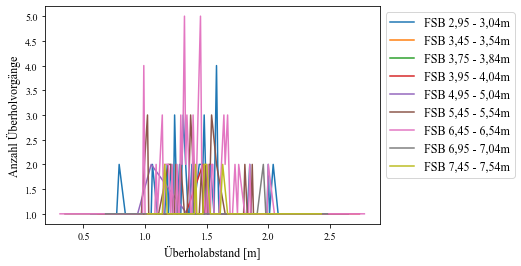

In [42]:
'''Erstellen von zu untersuchenden Gruppen

Lässt sich das in Schleifen machen? z.B.: am Angfang je Kriterium 
eine Liste mit Ausprägungen und dann erzeugen von weiteren Listen mit gdf anhand der Kriterienlisten automatisiert?


Liste mit Stringschnipseln/RE-Ausdrücken für Infra
Liste mit Radwegbreiten
Liste mit RE-Ausdrücken


Erzeugen der gdf in Schleife und Abspeichern in Liste (Listenname mit Hinweis auf Art des Merkmals)


'''
#Radinfra mit Breite.   nur RFS und SSF
'''Braucht man anscheinend doch nicht?!?!?!
#zum zurücksetzen der Variable 'Liste' bei mehrfachem ausführen. Try, da sonst beim ersten ausführen ein Fehler kommt...
try:
    liste
    #del liste
    get_ipython().magic('reset_selective -f liste') 
    #liste=liste.iloc[0:0].copy()
    #liste.columns = [''] * len(liste.columns)
except NameError:
    print('no_liste')
    pass'''

#Für automatisierte erstellung von linearer Regression in späterem Schritt:
krit_Lage = False
krit_Radwegbreite = False
krit_AbstandRechts = False
krit_PufferLinks = False
krit_PufferRechts = False
krit_FliessFahrbahn = False
krit_Kernfahrbahn = False
krit_Fahrstreifenbreite = False
krit_FahrstreifenbreiteMitRad = False
krit_Parken = False
krit_LType_L = False
krit_LType_R = False
krit_Speed = False
krit_Speed_Kfz = False
krit_Zeit = False
krit_Datum = False

#Gibt Polygon mit Umringkoordinaten aus. Input: Lat, Lon eines Punktes und Radius um den Punkt. Verwendet in Auswertung von location
def geodesic_point_buffer(lat, lon, km):
    # Azimuthal equidistant projection
    aeqd_proj = CRS.from_proj4(
        f"+proj=aeqd +lat_0={lat} +lon_0={lon} +x_0=0 +y_0=0")
    tfmr = Transformer.from_proj(aeqd_proj, aeqd_proj.geodetic_crs)
    buf = Point(0, 0).buffer(km * 1000)  # distance in metres
    return transform(tfmr.transform, buf).exterior.coords[:]

anzahl = 0
#Erzeuge für jeden Eintrag in der liste den entsprchenden GDF und speichere ihn in der Liste
for i, row in liste.iterrows():
        abfrage1 = None
        abfrage = None
        
        #------Radwegtyp-------
        if type(row['auswertung_x']) == str:   #schauen, ob eine Vorgabe zum auszuwertenden Kriterium gemacht wurde.
            pass
        else:
            krit_Radwegbreite = True
        if type(row['such_str']) == str:
            abfrage1 = (gdf_klass['Radinfra'].str.contains(row['such_str'], regex=row['reg']) == True)
            abfrage = abfrage1.copy()
            abfrage1 = None
        else:
            abfrage1 = (gdf_klass['Radinfra'].str.contains(r'.*', regex=row['reg']) == True)
            abfrage = abfrage1.copy()
            abfrage1 = None
        #------Freifeldeingabe-------
        if row['freifeld'] is not None:
            if type(row['auswertung_x']) == str:   #schauen, ob eine Vorgabe zum auszuwertenden Kriterium gemacht wurde.
                pass
            else:
                krit_Radwegbreite = True  
            freifelder = row['freifeld'].replace(" ", "")  #Leerzeichen entfernen, falls vorhanden.
            freifelder_list = freifelder.split(',')  #Splits String beim Komma -> liste mit key:value Paaren
            for k_v in freifelder_list:
                key_t = re.search(r'^[^:]*', k_v).group(0)  #alles bis zum ersten Bindestrich ^ suche von vorn. [^-] suche namespace der kein (^) Bindestrich ist. 
                val_t = re.search(r'[^:]*$', k_v).group(0)  # alles ab dem ersten Bindestrich $ suche von hinten. [^-] suche namespace der kein (^) Bindestrich ist. 
                #print(key_t, val_t)
                if isinstance(val_t, (bool)):   #Falls val_t = True or False
                    if abfrage is not None:
                        abfrage1 = abfrage & (gdf_klass[key_t] == val_t)
                    else:
                        abfrage1 = (gdf_klass[key_t] == val_t)
                elif val_t.isdigit():
                    if abfrage is not None:
                        abfrage1 = abfrage & (gdf_klass[key_t] == float(val_t))
                    else:
                        abfrage1 = (gdf_klass[key_t] == float(val_t))
                else:
                    if abfrage is not None:
                        #val_t_reg = "r'" + val_t + "'"
                        abfrage1 = abfrage & (gdf_klass[key_t].str.contains(fr'{val_t}', regex=True, case=False) == True) 
                    else:
                        abfrage1 = (gdf_klass[key_t].str.contains(fr'{val_t}', regex=True, case=False) == True)
                abfrage = abfrage1.copy()
                abfrage1 = None
        #------Ortslage-------   
        if row['lage'] is not None:
            if type(row['auswertung_x']) == str:   #schauen, ob eine Vorgabe zum auszuwertenden Kriterium gemacht wurde.
                pass
            else:
                krit_Radwegbreite = True
            if row['lage'] == 'inner':
                if abfrage is not None:
                    abfrage1 = abfrage & (gdf_klass['Ortslage'].str.contains(r'inner$', regex=True) == True)    #$ nötig, damit 'inner+' nicht gewählt wird               
                else:
                    abfrage1 = (gdf_klass['Ortslage'].str.contains(r'inner$', regex=True) == True)
            elif row['lage'] == 'inner+':
                if abfrage is not None:
                    abfrage1 = abfrage & (gdf_klass['Ortslage'].str.contains(r'inner+|unbekannt', regex=True) == True)                   
                else:
                    abfrage1 = (gdf_klass['Ortslage'].str.contains(r'inner+|unbekannt', regex=True) == True)
            elif row['lage'] == 'ausser':
                if abfrage is not None:
                    abfrage1 = abfrage & (gdf_klass['Ortslage'].str.contains(r'ausser$', regex=True) == True)                   
                else:
                    abfrage1 = (gdf_klass['Ortslage'].str.contains(r'ausser$', regex=True) == True)
            elif row['lage'] == 'ausser+':
                if abfrage is not None:
                    abfrage1 = abfrage & (gdf_klass['Ortslage'].str.contains(r'ausser+|unbekannt', regex=True) == True)                   
                else:
                    abfrage1 = (gdf_klass['Ortslage'].str.contains(r'ausser+|unbekannt', regex=True) == True)
            elif row['lage'] == 'unb' or row['lage'] == 'unbekannt':
                if abfrage is not None:
                    abfrage1 = abfrage & (gdf_klass['Ortslage'].str.contains(r'unbekannt', regex=True) == True)                   
                else:
                    abfrage1 = (gdf_klass['Ortslage'].str.contains(r'unbekannt', regex=True) == True)
            else:
                print("Unzulässiges Kriterium für 'Lage': " + str(row['lage']))
            try:
                abfrage = abfrage1.copy()
                abfrage1 = None  
            except BaseException as e:
                #print(e)
                pass
        #------Radwegbreite--    
        if row['rw_breite_min'] is not None and row['rw_breite_max'] is not None:
            if type(row['auswertung_x']) == str:   #schauen, ob eine Vorgabe zum auszuwertenden Kriterium gemacht wurde.
                pass
            else:
                krit_Radwegbreite = True
            if abfrage is not None:
                abfrage1 = abfrage & (gdf_klass['Radwegbreite'].between(float(row['rw_breite_min']), float(row['rw_breite_max'])))
            else:
                abfrage1 = (gdf_klass['Radwegbreite'].between(float(row['rw_breite_min']), float(row['rw_breite_max'])))
            abfrage = abfrage1.copy()
            abfrage1 = None
         #------Puffer Rechts vom Radweg-----
        if row['puf_R'] is not None:
            if type(row['auswertung_x']) == str:   #schauen, ob eine Vorgabe zum auszuwertenden Kriterium gemacht wurde.
                pass
            else:
                krit_PufferRechts = True
            if row['puf_R'] == 'no' or row['puf_R'] == 'none':
                if abfrage is not None:
                    abfrage1 = abfrage & (gdf_klass['PufferRechts'].str.contains(r'no|none', regex=True) == True)                   
                else:
                    abfrage1 = (gdf_klass['PufferRechts'].str.contains(r'no|none', regex=rowTrue) == True) 
            elif row['puf_R'] == 'yes':
                if abfrage is not None:
                    abfrage1 = abfrage & (gdf_klass['PufferRechts'].str.contains(r'yes|\d', regex=True) == True)                   
                else:
                    abfrage1 = (gdf_klass['PufferRechts'].str.contains(r'yes|\d', regex=True) == True)    
            elif bool(re.search(r'.*-.*', row['puf_R'])) == True:
                bereichR = row['puf_R'].replace(" ", "")
                pufVonR = re.search(r'^[^-]*', bereichR).group(0)  #alles bis zum ersten Bindestrich ^ suche von vorn. [^-] suche namespace der kein (^) Bindestrich ist. 
                pufBisR = re.search(r'[^-]*$', bereichR).group(0)  # alles ab dem ersten Bindestrich $ suche von hinten. [^-] suche namespace der kein (^) Bindestrich ist. 
                if abfrage is not None:
                    abfrage1 = abfrage & (gdf_klass['PufferRechts'].between(pufVonR, pufBisR, inclusive='both')) 
                    pufVonR = None
                    pufBisR = None
                else:
                    abfrage1 = (gdf_klass['PufferRechts'].between(pufVonR, pufBisR, inclusive='both')) 
                    pufVonR = None
                    pufBisR = None
            abfrage = abfrage1.copy()
            abfrage1 = None
        #------Puffer Links vom Radweg-----    
        if row['puf_L'] is not None:
            if type(row['auswertung_x']) == str:   #schauen, ob eine Vorgabe zum auszuwertenden Kriterium gemacht wurde.
                pass
            else:
                krit_PufferLinks = True
            if row['puf_L'] == 'no' or row['puf_L'] == 'none':
                if abfrage is not None:
                    abfrage1 = abfrage & (gdf_klass['PufferLinks'].str.contains(r'no|none', regex=True) == True)                   
                else:
                    abfrage1 = (gdf_klass['PufferLinks'].str.contains(r'no|none', regex=rowTrue) == True) 
            elif row['puf_L'] == 'yes':
                if abfrage is not None:
                    abfrage1 = abfrage & (gdf_klass['PufferLinks'].str.contains(r'yes|\d', regex=True) == True)                   
                else:
                    abfrage1 = (gdf_klass['PufferLinks'].str.contains(r'yes|\d', regex=True) == True)    
            elif bool(re.search(r'.*-.*', row['puf_L'])) == True:
                bereichL = row['puf_L'].replace(" ", "")
                pufVonL = re.search(r'^[^-]*', bereichL).group(0)  #alles bis zum ersten Bindestrich ^ suche von vorn. [^-] suche namespace der kein (^) Bindestrich ist. 
                pufBisL = re.search(r'[^-]*$', bereichL).group(0)  # alles ab dem ersten Bindestrich $ suche von hinten. [^-] suche namespace der kein (^) Bindestrich ist. 
                if abfrage is not None:
                    abfrage1 = abfrage & (gdf_klass['PufferLinks'].between(pufVonL, pufBisL, inclusive='both')) 
                    pufVonL = None
                    pufBisL = None
                else:
                    abfrage1 = (gdf_klass['PufferLinks'].between(pufVonL, pufBisL, inclusive='both')) 
                    pufVonL = None
                    pufBisL = None
            abfrage = abfrage1.copy()
            abfrage1 = None
        #------Breite Fahrbahn Fliessverkehr-----
        if row['fliess'] is not None:
            if type(row['auswertung_x']) == str:   #schauen, ob eine Vorgabe zum auszuwertenden Kriterium gemacht wurde.
                pass
            else:
                krit_FliessFahrbahn = True
            bereichFl = row['fliess'].replace(" ", "")
            fliessVon = re.search(r'^[^-]*', bereichFl).group(0)  #alles bis zum ersten Bindestrich ^ suche von vorn. [^-] suche namespace der kein (^) Bindestrich ist. 
            fliessBis = re.search(r'[^-]*$', bereichFl).group(0)  # alles ab dem ersten Bindestrich $ suche von hinten. [^-] suche namespace der kein (^) Bindestrich ist. 
            if abfrage is not None:
                abfrage1 = abfrage & (gdf_klass['Fahrbahn_Fliessverkehr'].between(float(fliessVon), float(fliessBis), inclusive='both')) 
                fliessVon = None
                fliessBis = None
            else:
                abfrage1 = (gdf_klass['Fahrbahn_Fliessverkehr'].between(float(fliessVon), float(fliessBis), inclusive='both')) 
                fliessVon = None
                fliessBis = None
            abfrage = abfrage1.copy()
            abfrage1 = None
        #------Breite Kernfahrbahn-----
        if row['kern'] is not None:
            if type(row['auswertung_x']) == str:   #schauen, ob eine Vorgabe zum auszuwertenden Kriterium gemacht wurde.
                pass
            else:
                krit_Kernfahrbahn = True
            bereichK = row['kern'].replace(" ", "")
            kernVon = re.search(r'^[^-]*', bereichK).group(0)  #alles bis zum ersten Bindestrich ^ suche von vorn. [^-] suche namespace der kein (^) Bindestrich ist. 
            kernBis = re.search(r'[^-]*$', bereichK).group(0)  # alles ab dem ersten Bindestrich $ suche von hinten. [^-] suche namespace der kein (^) Bindestrich ist. 
            if abfrage is not None:
                abfrage1 = abfrage & (gdf_klass['Kernfahrbahn'].between(float(kernVon), float(kernBis), inclusive='both')) 
                #print(float(kernVon), float(kernBis))
                kernVon = None
                kernBis = None
            else:
                abfrage1 = (gdf_klass['Kernfahrbahn'].between(float(kernVon), float(kernBis), inclusive='both')) 
                kernVon = None
                kernBis = None
            abfrage = abfrage1.copy()
            abfrage1 = None
        #------Breite Fahrstreifen-----
        if row['fsb'] is not None:
            if type(row['auswertung_x']) == str:   #schauen, ob eine Vorgabe zum auszuwertenden Kriterium gemacht wurde.
                pass
            else:
                krit_Fahrstreifenbreite = True
            bereichF = row['fsb'].replace(" ", "")
            fsbVon = re.search(r'^[^-]*', bereichF).group(0)  #alles bis zum ersten Bindestrich ^ suche von vorn. [^-] suche namespace der kein (^) Bindestrich ist. 
            fsbBis = re.search(r'[^-]*$', bereichF).group(0)  # alles ab dem ersten Bindestrich $ suche von hinten. [^-] suche namespace der kein (^) Bindestrich ist. 
            if abfrage is not None:
                abfrage1 = abfrage & (gdf_klass['Fahrstreifenbreite'].between(float(fsbVon), float(fsbBis), inclusive='both')) 
                #print(float(fsbVon), float(fsbBis))
                fsbVon = None
                fsbBis = None
            else:
                abfrage1 = (gdf_klass['Fahrstreifenbreite'].between(float(fsbVon), float(fsbBis), inclusive='both')) 
                fsbVon = None
                fsbBis = None
            abfrage = abfrage1.copy()
            abfrage1 = None
        #------Breite Fahrstreifen inkl. Radinfra-----
        if row['fsbRad'] is not None:
            if type(row['auswertung_x']) == str:   #schauen, ob eine Vorgabe zum auszuwertenden Kriterium gemacht wurde.
                pass
            else:
                krit_FahrstreifenbreiteMitRad = True
            bereichFR = row['fsbRad'].replace(" ", "")
            fsbRadVon = re.search(r'^[^-]*', bereichFR).group(0)  #alles bis zum ersten Bindestrich ^ suche von vorn. [^-] suche namespace der kein (^) Bindestrich ist. 
            fsbRadBis = re.search(r'[^-]*$', bereichFR).group(0)  # alles ab dem ersten Bindestrich $ suche von hinten. [^-] suche namespace der kein (^) Bindestrich ist. 
            if abfrage is not None:
                abfrage1 = abfrage & (gdf_klass['FSBundRad'].between(float(fsbRadVon), float(fsbRadBis), inclusive='both')) 
                #print(float(fsbVon), float(fsbBis))
                fsbRadVon = None
                fsbRadBis = None
            else:
                abfrage1 = (gdf_klass['FSBundRad'].between(float(fsbRadVon), float(fsbRadBis), inclusive='both')) 
                fsbRadVon = None
                fsbRadBis = None
            abfrage = abfrage1.copy()
            abfrage1 = None
         #------Parken-----------    
        if row['parken'] is not None:
            if type(row['auswertung_x']) == str:   #schauen, ob eine Vorgabe zum auszuwertenden Kriterium gemacht wurde.
                pass
            else:
                krit_Parken = True
            if row['parken'] == 'ja' or row['parken'] == 'Ja' or row['parken'] == 'yes' or row['parken'] == 'Yes':
                such_reg = re.compile(r'^.*(?<!P-gg: .*)(park.*|Park.*)')  #finde park oder Park ohne dass irgendwo davor ein P-gg kommt
            elif row['parken'] == 'nein' or row['parken'] == 'Nein' or row['parken'] == 'no' or row['parken'] == 'No':
                such_reg = re.compile(r'^.*(?<!P-gg:.*)kein_P.*')  #finde kein_P ohne dass irgendwo davor ein P-gg kommt
            elif row['parken'] == 'unb' or row['parken'] == 'Unb' or row['parken'] == 'unb.' or row['parken'] == 'Unb.' or row['parken'] == 'unbekannt' or row['parken'] == 'Unbekannt':
                such_reg = re.compile(r'^(?:(?:(?!kein_P|park|Parkstr|P-gg).)*P-gg.*|(?:(?!kein_P|park|Parkstr).)*)$')   #finde KEIN kein_P oder park ohne dass irgendwo davor ein P-gg kommt -> Parksituation unbekannt
            elif row['parken'] == 'bek' or row['parken'] == 'Bek' or row['parken'] == 'bek.' or row['parken'] == 'Bek.' or row['parken'] == 'bekannt' or row['parken'] == 'Bekannt':
                such_reg = re.compile(r'^.*(?<!P-gg: .*)(park.*|Park.*|kein_P.*)')  #finde kein_P, park oder Park ohne dass irgendwo davor ein P-gg kommt
            if abfrage is not None:
                 abfrage1 = abfrage & (gdf_klass['Radinfra'].apply(regex_contains, args=(such_reg,)) == True) #& (np.isnan(gdf_klass['distance_stationary']) == False)
            else:
                pass
                abfrage1 = (gdf_klass['Radinfra'].apply(regex_contains, args=(such_reg,)) == True) #& ((gdf_klass['distance_stationary'] is not None) == True)
            abfrage = abfrage1.copy()
            abfrage1 = None
        #------Abstände nach Rechts-----    
        if row['rechter_wert'] is not None:
            if type(row['auswertung_x']) == str:   #schauen, ob eine Vorgabe zum auszuwertenden Kriterium gemacht wurde.
                pass
            else:
                krit_AbstandRechts = True
            if bool(re.search(r'.*-.*', row['rechter_wert'])) == True:
                bereichP = row['rechter_wert'].replace(" ", "")
                pufVonP = re.search(r'^[^-]*', bereichP).group(0)  #alles bis zum ersten Bindestrich ^ suche von vorn. [^-] suche namespace der kein (^) Bindestrich ist. 
                pufBisP = re.search(r'[^-]*$', bereichP).group(0)  # alles ab dem ersten Bindestrich $ suche von hinten. [^-] suche namespace der kein (^) Bindestrich ist. 
                if abfrage is not None:
                    abfrage1 = abfrage & (gdf_klass['distance_stationary'].between(float(pufVonP), float(pufBisP), inclusive='both')) 
                    pufVonP = None
                    pufBisP = None
                else:
                    abfrage1 = (gdf_klass['distance_stationary'].between(float(pufVonP), float(pufBisP), inclusive='both')) 
                    pufVonP = None
                    pufBisP = None
            abfrage = abfrage1.copy()
            abfrage1 = None
        #------Linientyp Linker Radstreifenrand-----------    
        if row['ltype_l'] is not None:
            if type(row['auswertung_x']) == str:   #schauen, ob eine Vorgabe zum auszuwertenden Kriterium gemacht wurde.
                pass
            else:
                krit_LType_L = True
            if row['ltype_l'] == 'solid_line':
                such_reg = re.compile(r'^.*linkeM_SL.*')
                if abfrage is not None:
                    abfrage1 = abfrage & (gdf_klass['Radinfra'].apply(regex_contains, args=(such_reg,)) == True)
                else:
                    abfrage1 = (gdf_klass['Radinfra'].apply(regex_contains, args=(such_reg,)) == True)
            elif row['ltype_l'] == 'double_solid_line':
                such_reg = re.compile(r'^.*linkeM_DSL.*')
                if abfrage is not None:
                    abfrage1 = abfrage & (gdf_klass['Radinfra'].apply(regex_contains, args=(such_reg,)) == True)
                else:
                    abfrage1 = (gdf_klass['Radinfra'].apply(regex_contains, args=(such_reg,)) == True)
            elif row['ltype_l'] == 'dashed_line':
                such_reg = re.compile(r'^.*linkeM_DL.*')
                if abfrage is not None:
                    abfrage1 = abfrage & (gdf_klass['Radinfra'].apply(regex_contains, args=(such_reg,)) == True)
                else:
                    abfrage1 = (gdf_klass['Radinfra'].apply(regex_contains, args=(such_reg,)) == True)
            elif row['ltype_l'] == 'barred_area':
                such_reg = re.compile(r'^.*linkeM_BA.*')
                if abfrage is not None:
                    abfrage1 = abfrage & (gdf_klass['Radinfra'].apply(regex_contains, args=(such_reg,)) == True)
                else:
                    abfrage1 = (gdf_klass['Radinfra'].apply(regex_contains, args=(such_reg,)) == True)
            abfrage = abfrage1.copy()
            abfrage1 = None
        #------Linientyp Rechter Radstreifenrand-----------    
        if row['ltype_r'] is not None:
            if type(row['auswertung_x']) == str:   #schauen, ob eine Vorgabe zum auszuwertenden Kriterium gemacht wurde.
                pass
            else:
                krit_LType_R = True
            if row['ltype_r'] == 'solid_line':
                such_reg = re.compile(r'^.*rechteM_SL.*')
                if abfrage is not None:
                    abfrage1 = abfrage & (gdf_klass['Radinfra'].apply(regex_contains, args=(such_reg,)) == True)
                else:
                    abfrage1 = (gdf_klass['Radinfra'].apply(regex_contains, args=(such_reg,)) == True)
            elif row['ltype_r'] == 'double_solid_line':
                such_reg = re.compile(r'^.*rechteM_DSL.*')
                if abfrage is not None:
                    abfrage1 = abfrage & (gdf_klass['Radinfra'].apply(regex_contains, args=(such_reg,)) == True)
                else:
                    abfrage1 = (gdf_klass['Radinfra'].apply(regex_contains, args=(such_reg,)) == True)
            elif row['ltype_r'] == 'dashed_line':
                such_reg = re.compile(r'^.*rechteM_DL.*')
                if abfrage is not None:
                    abfrage1 = abfrage & (gdf_klass['Radinfra'].apply(regex_contains, args=(such_reg,)) == True)
                else:
                    abfrage1 = (gdf_klass['Radinfra'].apply(regex_contains, args=(such_reg,)) == True)
            elif row['ltype_r'] == 'barred_area':
                such_reg = re.compile(r'^.*rechteM_BA.*')
                if abfrage is not None:
                    abfrage1 = abfrage & (gdf_klass['Radinfra'].apply(regex_contains, args=(such_reg,)) == True)
                else:
                    abfrage1 = (gdf_klass['Radinfra'].apply(regex_contains, args=(such_reg,)) == True)
            abfrage = abfrage1.copy()
            abfrage1 = None
        #------Fahrradgeschwindigkeit-----    
        if row['speed_min'] is not None and row['speed_max'] is not None:
            if type(row['auswertung_x']) == str:   #schauen, ob eine Vorgabe zum auszuwertenden Kriterium gemacht wurde.
                pass
            else:
                krit_Speed = True
            if abfrage is not None:
                abfrage1 = abfrage & (gdf_klass['speed'].between(float(row['speed_min']), float(row['speed_max'])))
            else:
                abfrage1 = (gdf_klass['speed'].between(float(row['speed_min']), float(row['speed_max'])))
            abfrage = abfrage1.copy()
            abfrage1 = None
        #------Erlaubte Geschwindigkeit Kfz-----    
        if row['speed_kfz'] is not None:
            if type(row['auswertung_x']) == str:   #schauen, ob eine Vorgabe zum auszuwertenden Kriterium gemacht wurde.
                pass
            else:
                krit_Speed_Kfz = True
            if bool(re.search(r'.*-.*', row['speed_kfz'])) == True:
                bereichSpKfz = row['speed_kfz'].replace(" ", "")  #Leerzeichen entfernen, falls vorhanden.
                spKfzVon = re.search(r'^[^-]*', bereichSpKfz).group(0)  #alles bis zum ersten Bindestrich ^ suche von vorn. [^-] suche namespace der kein (^) Bindestrich ist. 
                spKfzBis = re.search(r'[^-]*$', bereichSpKfz).group(0)  # alles ab dem ersten Bindestrich $ suche von hinten. [^-] suche namespace der kein (^) Bindestrich ist. 
                if abfrage is not None:
                    abfrage1 = abfrage & (gdf_klass['Geschwindigkeit_Numerisch'].between(float(spKfzVon), float(spKfzBis), inclusive='both')) 
                    spKfzVon = None
                    spKfzBis = None
                else:
                    abfrage1 = (gdf_klass['Geschwindigkeit_Numerisch'].between(float(spKfzVon), float(spKfzBis), inclusive='both')) 
                    spKfzVon = None
                    spKfzBis = None
            elif row['speed_kfz'].isdigit():
                if abfrage is not None:
                    abfrage1 = abfrage & (gdf_klass['Geschwindigkeit_Numerisch'] == float(row['speed_kfz']))
                    spKfzVon = None
                    spKfzBis = None
                else:
                    abfrage1 = (gdf_klass['Geschwindigkeit_Numerisch'] == float(row['speed_kfz']))
                    spKfzVon = None
                    spKfzBis = None
            abfrage = abfrage1.copy()
            abfrage1 = None
        #------Tageszeit-----    
        if row['time_from'] is not None and row['time_to'] is not None:
            if type(row['auswertung_x']) == str:   #schauen, ob eine Vorgabe zum auszuwertenden Kriterium gemacht wurde.
                pass
            else:
                krit_Zeit = True
                
            tindex = pd.DatetimeIndex(gdf_klass['datetime_berlin'])  #variable mit DateTime drin, damit nicht spalte time als Index gesetzt werden muss
            if abfrage is not None:
                #gleicht ab, ob die sich im Zeitbereich befindlichen Werte in der Spalte Time vorhanden sind...
                abfrage1 = abfrage & (gdf_klass['datetime_berlin'].iloc[tindex.indexer_between_time(row['time_from'], row['time_to'])].isin(gdf_klass['datetime_berlin']))   
            else:
                pass
                abfrage1 = (gdf_klass['datetime_berlin'].iloc[tindex.indexer_between_time(row['time_from'], row['time_to'])].isin(gdf_klass['datetime_berlin']))   
            abfrage = abfrage1.copy()
            abfrage1 = None
        #------Datum-----    
        if row['date_from'] is not None and row['date_to'] is not None:
            if type(row['auswertung_x']) == str:   #schauen, ob eine Vorgabe zum auszuwertenden Kriterium gemacht wurde.
                pass
            else:
                krit_Datum = True
                
            #tindex = pd.DatetimeIndex(gdf_klass['datetime_berlin'])  #variable mit DateTime drin, damit nicht spalte time als Index gesetzt werden muss
            mask = (gdf_klass['date_berlin'] >= row['date_from']) & (gdf_klass['date_berlin'] <= row['date_to'])
            if abfrage is not None:
                #gleicht ab, ob die sich im Zeitbereich befindlichen Werte in der Spalte Time vorhanden sind...
                abfrage1 = abfrage & (gdf_klass['datetime_berlin'].loc[mask].isin(gdf_klass['datetime_berlin']))   
            else:
                pass
                #abfrage1 = (gdf_klass['speed'].between(float(row['speed_min']), float(row['speed_max'])))
            abfrage = abfrage1.copy()
            abfrage1 = None
         #------location erzeugen-----    
        if row['location'] is not None:
            
            areal = row['location'].replace(" ", "")
            if "-" in areal:  # Auswertung als BoundingBox
                lu, ro = areal.split("-")
                xmin, ymin = lu.split(",")
                xmax, ymax = ro.split(",")
                ymin = float(ymin)
                xmin = float(xmin)
                ymax = float(ymax)
                xmax = float(xmax)
                liste['filter'][i] = copy.deepcopy(Polygon([[xmin,ymin], [xmax,ymin], [xmax,ymax], [xmin,ymax], [xmin,ymin]]))
                           
            elif ":" in areal:  # Auswertung als Kreis mit Mittelpunkt
                mi, ra = areal.split(":")
                miLon, miLat = mi.split(",")
                miLat = float(miLat) 
                miLon = float(miLon)
                ra = float(ra)
                umr = Polygon(geodesic_point_buffer(miLat, miLon, ra))
                liste['filter'][i] = copy.deepcopy(umr)
        #-------filter (damit location später einfacher erfügbar zum darstellen) ------
        if row['filter'] is not None:
            try:
                umr_filt = row['filter']
                if abfrage is not None:
                    abfrage1 = abfrage & gdf_klass['geometry'].within(umr_filt)  #Auswahl von OBS-Punkten innerhalb BBox
                else:
                    abfrage1 = gdf_klass['geometry'].within(umr_filt)
                abfrage = abfrage1.copy()
                abfrage1 = None 
            except BaseException as e:
                print(e)
                pass
                

        #--------------------------   
        
        #Anzahl der Einträge je Gruppe ausgeben
        row['gdf'] = gdf_klass[abfrage].copy()
        anzahl = anzahl + len(row['gdf'])
        print(row['bez'],':   ',len(row['gdf']), ' gesamt:' , anzahl)


#---------Auswertungskriterium
#was True ist entscheidet sich daran, welche Kriterien ganz oben in den Listen gesetzt sind.
krit_x = 'Radwegbreite'       #Standardwert für Auswertungskriterium X-Achse. Sollte immer überschrieben werden.
krit_y = 'distance_overtaker' #Standardwert für Auswertungskriterium Y-Achse. Wird nur bei Eingabe in Auswertungsgruppen (oben) überschrieben.
besch_y = 'Überholabstand [m]'

if krit_Radwegbreite == True or liste['auswertung_x'][0] == "Radwegbreite":
    krit_x = 'Radwegbreite'
    besch_x = 'Netto-Radwegbreite [m]'
    #kurve = 1 
if liste['auswertung_x'][0] == "distance_overtaker": 
    krit_x = 'distance_overtaker'
    besch_x = 'Überholabstand [m]' 
if krit_AbstandRechts == True or liste['auswertung_x'][0] == "distance_stationary":
    krit_x = 'distance_stationary'
    besch_x = 'Abstand nach Rechts [m]'
    #kurve = 1 
if krit_PufferRechts == True or liste['auswertung_x'][0] == "PufferRechts":
    krit_x = 'PufferRechts'
    besch_x = 'Puffer rechts des Radwegs [m]'
    #kurve = 1 
if krit_PufferLinks == True or liste['auswertung_x'][0] == "PufferLinks":
    krit_x = 'PufferLinks'
    besch_x = 'Puffer links des Radwegs [m]'
    #kurve = 1 
if krit_FliessFahrbahn == True or liste['auswertung_x'][0] == "Fahrbahn_Fliessverkehr":
    krit_x = 'Fahrbahn_Fliessverkehr'
    besch_x = 'Breite der Fahrbahn\n(inkl. Radstreifen, ohne Parken) [m]'
    #kurve = 1
if krit_Kernfahrbahn == True or liste['auswertung_x'][0] == "Kernfahrbahn":
    krit_x = 'Kernfahrbahn'
    besch_x = 'Breite der Kernfahrbahn [m]'
    #kurve = 1 
if krit_Fahrstreifenbreite == True or liste['auswertung_x'][0] == "Fahrstreifenbreite":
    krit_x = 'Fahrstreifenbreite'
    besch_x = 'Breite der Kfz-Fahrstreifen [m]'
    #kurve = 1 
if krit_FahrstreifenbreiteMitRad == True or liste['auswertung_x'][0] == "FSBundRad":
    krit_x = 'FSBundRad'
    besch_x = 'Breite der Kfz-Fahrstreifen inkl. Radstreifen [m]'
    #kurve = 1 
if krit_Parken == True:
    krit_x = 'distance_stationary'
    besch_x = 'Abstand nach rechts [m]'
    #kurve = 1 
if krit_LType_L == True :
    krit_x = 'Radwegbreite'
    besch_x = 'Netto-Radwegbreite [m]'
    #kurve = 1 
if krit_LType_R == True:
    krit_x = 'Radwegbreite'
    besch_x = 'Netto-Radwegbreite [m]'
    #kurve = 1 
if krit_Speed == True or liste['auswertung_x'][0] == "speed":
    krit_x = 'speed'
    besch_x = 'Fahrradgeschwindigkeit [m/s]'
    #kurve = 1 
if krit_Speed_Kfz == True or liste['auswertung_x'][0] == "Geschwindigkeit_Numerisch":
    krit_x = 'Geschwindigkeit_Numerisch'
    besch_x = 'Erlaubte Höchstgeschwindigkeit [km/h]'
    #kurve = 1 
if krit_Zeit == True or liste['auswertung_x'][0] == "Zeit":
    krit_x = 'time_berlin_num'
    besch_x = 'Tageszeit'
    #kurve = 1 #Funzt für meinen Datensatz an der Stelle nicht....
if krit_Datum == True or liste['auswertung_x'][0] == "Datum":
    krit_x = 'date_berlin_num'
    besch_x = 'Datum'
    #kurve = 1 
if liste['auswertung_y'][0] == "Radwegbreite":
    krit_y = 'Radwegbreite'
    besch_y = 'Netto-Radwegbreite [m]'
if liste['auswertung_y'][0] == "distance_overtaker":
    krit_y = 'distance_overtaker'
    besch_y = 'Überholabstand [m]' 
if liste['auswertung_y'][0] == "distance_stationary":
    krit_y = 'distance_stationary'
    besch_y = 'Abstand nach Rechts [m]'
if liste['auswertung_y'][0] == "PufferRechts":
    krit_y = 'PufferRechts'
    besch_y = 'Puffer rechts des Radwegs[m]'
if liste['auswertung_y'][0] == "PufferLinks":
    krit_y = 'PufferLinks'
    besch_y = 'Puffer links des Radwegs [m]'
if liste['auswertung_y'][0] == "Fahrbahn_Fliessverkehr":
    krit_y = 'Fahrbahn_Fliessverkehr'
    besch_y = 'Breite der Fahrbahn\n(inkl. Radstreifen, ohne Parken) [m]'
if liste['auswertung_y'][0] == "Kernfahrbahn":
    krit_y = 'Kernfahrbahn'
    besch_y = 'Breite der Kernfahrbahn [m]'
if liste['auswertung_y'][0] == "Fahrstreifenbreite":
    krit_y = 'Fahrstreifenbreite'
    besch_y = 'Breite der Kfz-Fahrstreifen [m]'
if liste['auswertung_y'][0] == "FSBundRad":
    krit_y = 'FSBundRad'
    besch_y = 'Breite der Kfz-Fahrstreifen inkl. Radstreifen [m]'
if liste['auswertung_y'][0] == "speed":
    krit_y = 'speed'
    besch_y = 'Fahrradgeschwindigkeit [m/s]'
if liste['auswertung_y'][0] == "Geschwindigkeit_Numerisch":
    krit_y = 'Geschwindigkeit_Numerisch'
    besch_y = 'Erlaubte Höchstgeschwindigkeit [km/h]'
if liste['auswertung_y'][0] == "Zeit":
    krit_y = 'time_berlin_num'
    besch_y = 'Tageszeit'
if liste['auswertung_y'][0] == "Datum":
    krit_y = 'date_berlin_num'
    besch_y = 'Datum' 


        
for l, row2 in liste.iterrows():        
    if anzahl < 200:
        darst = '.'
    else:
        darst = '-'
    plt.plot(row2['gdf'].dropna(subset=['distance_overtaker']).groupby('distance_overtaker')['distance_overtaker'].count(), darst, label=row2['bez'])
           
    
plt.legend()
plt.xlabel('Überholabstand [m]')
plt.ylabel('Anzahl Überholvorgänge')
if len(liste) > 6:
    plt.legend(bbox_to_anchor=(1, 1), loc="upper left") #Legende außerhalb der Grafik platzieren bei vielen Eintraegen, da sonst verdeckt.

'''Check if directory exists, if not, create it 
    -> Hier werden die Abbildungen automatisch gespeichert
    Ordnerstruktur ist: Ergebnisse / Kriterium der Gruppe / Stand bzw. Datum der Datenklassifizierung
    Ergebnisse werden über das Datem des Tags, an dem eine Auswertung durchgeführt wird, markiert.
    Bei wiederholter Auswertung am selben Tag werden die Ergebnisse überschrieben.'''

MYDIR = ("../Ergebnisse/" + row['kriterium'] +"/"+ read_file[-11:-5])
#MYDIR = ("../Ergebnisse/230315/" + row['kriterium'] +"/"+ read_file[-11:-5])
if "\n" in MYDIR:
    MYDIR = MYDIR.replace('\n', ' ')
CHECK_FOLDER = os.path.isdir(MYDIR)
# If folder doesn't exist, then create it.
if not CHECK_FOLDER:
    os.makedirs(MYDIR)    
    
plt.savefig(MYDIR  + "/" + datum + "_Verhältnis.png", dpi=300, bbox_inches="tight") 

In [43]:
'''Plot Settings
'''

#Plotparameter
plt.rcParams["font.family"] = "Times New Roman"   #auf Schriftart TimesNewRoman setzen
plt.rcParams["legend.fontsize"] = 12              #schriftgröße Legende
plt.rcParams["legend.title_fontsize"] = 12        #schriftgröße Legendentitel
plt.rcParams["figure.titlesize"] = 12             #Schriftgröße Title (genutzt als Untertitel)
plt.rcParams["axes.labelsize"] = 12               #Größe von Achsbezeichung
plt.rcParams["xtick.labelsize"] = 10              #Größe von Achsbeschriftungen
plt.rcParams["ytick.labelsize"] = 10              #Größe von Achsbeschriftungen

cm_In = 1/2.54  #Umrechnungsfaktor cm in Inches
aufl = 300  #Auflösung in dpi.

#A4 hoch
plt_breite = 14 * cm_In
plt_hoehe = 8 * cm_In

#A3 Quer
#plt_breite = 42*cm_In   #16.53  #Inches
#plt_hoehe = 29.7*cm_In    #11.69

print("Plotbreite: " + str(round(plt_breite / cm_In, 2)) + "cm, " + str(round(plt_breite, 2)) + " Inch, " + "\nPlothöhe: " + str(round(plt_hoehe / cm_In, 2)) + "cm, " + str(round(plt_hoehe, 2)) + " Inch, ")

Plotbreite: 14.0cm, 5.51 Inch, 
Plothöhe: 8.0cm, 3.15 Inch, 


/home/lukas/anaconda3/envs/MA-working/lib/python3.9/site-packages/geopandas/plotting.py:730: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


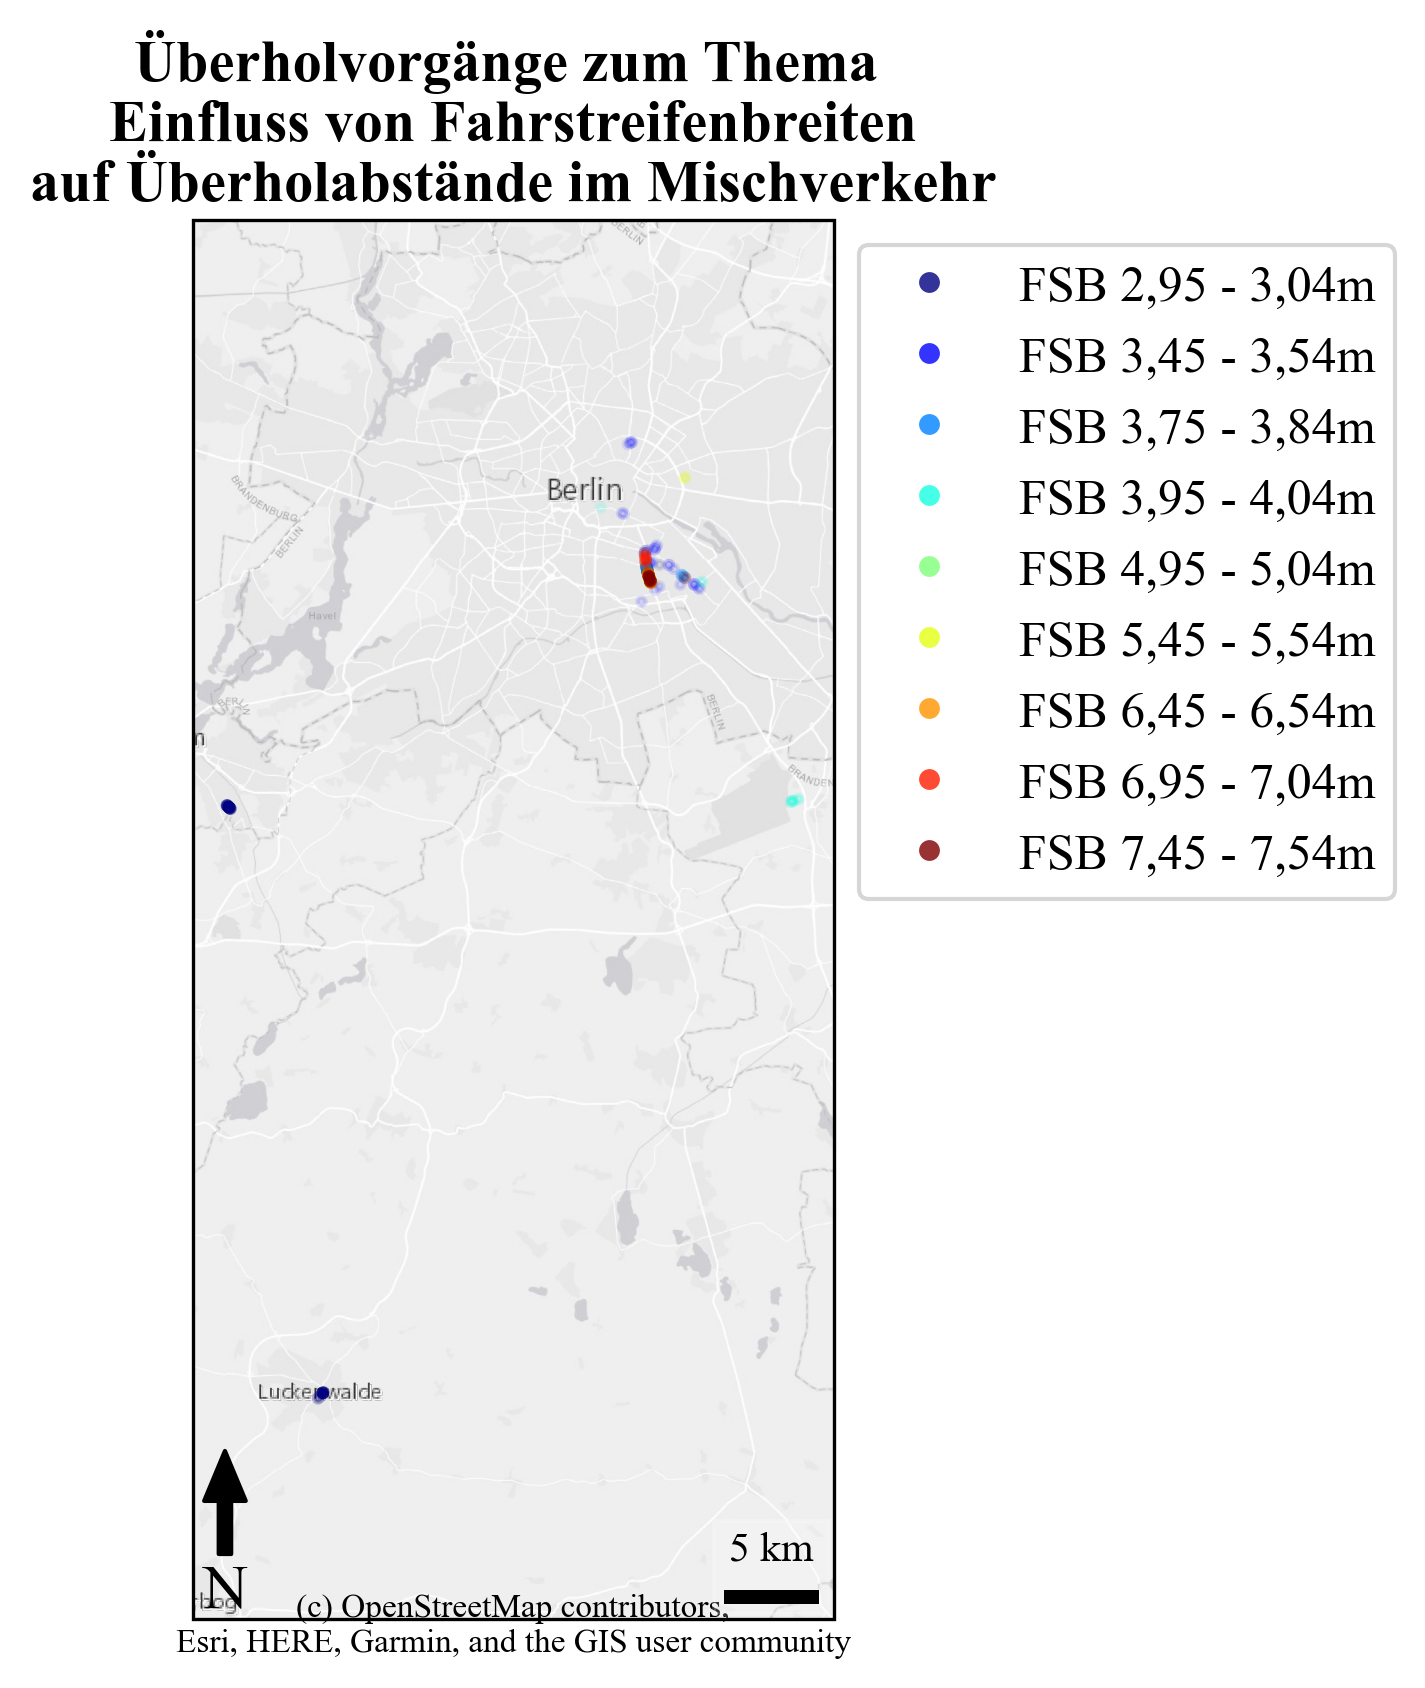

In [44]:
'''Erzeugen einer Kartenansicht mit den ausgewerteten Daten'''

# Functions
def get_zoom_level_for_extent(xmin, xmax, ymin, ymax):
    # Calculate the width and height of the extent in degrees
    width = xmax - xmin
    height = ymax - ymin
    # Determine the maximum dimension (width or height) of the extent
    max_dimension = max(width, height)
    dict_zoom_levels = {0:360, 1:180, 2:90, 3:45, 4:22.5, 5:11.25, 6:5.625, 7:2.813, 8:1.406, 9:0.703, 10:0.352, 11:0.176, 12:0.088, 13:0.044, 14:0.022, 15:0.011, 16:0.005}
    zoom_level = None
    for key in dict_zoom_levels:
        if max_dimension > dict_zoom_levels[key] and zoom_level is None:
            zoom_level = key #+ 2ZZ
            pass
    return zoom_level


def makeLayeredMap(*args):
    """This function accepts an arbitrary number of geodataframes, plots them on top of a Contextily basemap. 
    NOTE: Please edit the Plotting-section to specify parameters for the number of layers and the formatting of each layer.
    Output: Saved file and layered map for display."""
    
    # Convert the CRS for all layers to EPSG3857 to match Contextily
    #args = liste(map(lambda x: x.to_crs(epsg=3857), args))   # 4326

    # Create figure
    fig, ax = plt.subplots(figsize=(plt_breite, plt_hoehe/8*14), dpi=aufl, constrained_layout=True, subplot_kw={'projection': ccrs.PlateCarree()})
    #Set aspect to equal
    data_crs = args[2].crs               #Koordinatensystem, in dem die zu plottenden Daten vorliegen. EPSG:4326 = WGS84 = Globe in cartopy
    #ax = plt.axes(projection=ccrs.PlateCarree())  #Projektion, die für die Abbildung verwendet werden soll

    #----Calculate Extent---------------------------
    #longitude = X, latitude = y
    xmin, ymin, xmax, ymax = args[2].total_bounds    #Grenzen der OBS-Messpunkte
    #Abgleich mit Umringen, wenn vorhanden. Ggf. vergrßern der Abbildungsgrenze, damit Bereiche ganz zu sehen sind, auch wenn da keine Messpunkte mehr vorkommen
    for j, row3 in liste.iterrows():
        try:
            x1, y1, x2, y2 = row3['filter'].bounds            
            if x1 < xmin: 
                xmin = x1
            if y1 < ymin: 
                ymin = y1
            if y2 > ymax: 
                ymax = y2
            if x2 > xmax: 
                xmax = x2
        except BaseException as e: 
            pass
            #print(e)
    
    xmin = xmin*0.998    #Bereich etwas größer machen, damit Objekte nicht direkt auf Plotrand liegen.
    xmax = xmax*1.002
    ymin = ymin*0.998
    ymax = ymax*1.002
    ax.set_extent([xmin, xmax, ymin, ymax], ccrs.PlateCarree())
    
    xmitte = np.mean([xmin, xmax])  #Werte für später (maßstabsleiste, aspect ratio)
    ymitte = np.mean([ymin, ymax])
    
    #----Get appropriate zoom level for map extent
    zoom_level = get_zoom_level_for_extent(xmin, xmax, ymin, ymax)
    if zoom_level <=15:
        zoom_level2 = zoom_level + 1  #Karte eine Stufe detaillierter darstellen als Beschriftung
    else:
        zoom_level2 = zoom_level

    #----PLOTTING Background image--------------
    #No. 1: Names
    #No. 2: Topography
    url1 = 'https://server.arcgisonline.com/arcgis/rest/services/Canvas/World_Light_Gray_Reference/MapServer/tile/{z}/{y}/{x}.jpg'
    url2 = 'https://server.arcgisonline.com/arcgis/rest/services/Canvas/World_Light_Gray_Base/MapServer/tile/{z}/{y}/{x}.jpg'    
    image1 = cimgt.GoogleTiles(url=url1, desired_tile_form='RGBA')               #RGBA Returns image where background is transparent
    image2 = cimgt.GoogleTiles(url=url2)
    ax.add_image(image2, zoom_level2, interpolation='hanning', regrid_shape=3000)  #interpolation and regrid are used to get better image quality. 
    ax.add_image(image1, zoom_level, interpolation='hanning', regrid_shape=3000)

    #----PLOTTING Data--------------
    if args[2]['bez'].nunique() > 3:
        #Legende rechts ausserhalb
        args[2].plot(ax=ax, alpha=0.1, zorder=2, markersize=4, column='bez', cmap='jet', legend=True, legend_kwds={"bbox_to_anchor" : (1, 1), "loc": "upper left", "fontsize" : 12,  "title_fontsize": 12})  #edgecolor = 'none',  
    else:
        #Legende rechts oben innerhalb
        args[2].plot(ax=ax, alpha=0.1, zorder=2, markersize=4, column='bez', cmap='jet', legend=True, legend_kwds={"loc": "upper right", "fontsize" : 12,  "title_fontsize": 12})  #edgecolor = 'none',  
    for count, legend_handle in enumerate(ax.get_legend().legend_handles):
        legend_handle.set(markersize = 5, alpha = 0.8)

    
    #------PLOTTING: Darstellen von Bereichsgrenzen (Location), wenn vorhanden. Polygon der Umgrenzung von Code im Spalte Filter abgelegt.
    cmap2 = plt.get_cmap(name='jet') #Farbtabelle für eventuell vorhandene Bereichsgrenzen
    n=0
    for i, row in liste.iterrows():
        if row['filter'] is not None:
            n=n+1
            polygon_temp = row['filter']
            p = gpd.GeoSeries(polygon_temp, crs=data_crs)      #macht shaply.polygon zu geoPandas.GeoSeries
            args += (p,)                                       #fügt Liste mit zu Plottenden Elementen eines am Ende hinzu
            args[n+2].plot(ax=ax, facecolor="none", edgecolor='black')  #3 sind am Anfang drin, daher +2. Die richtige Farbe auszuwählen klappt nicht
    if n == 0:   #wahr, wenn keine Gruppe einen Filter/Bereich definiert hat
        #Beim zeichnen einer GeoSeries wird der aspect von ax automatisch angepasst. Werden nur punkte gezeichnet passiert das nicht,
        #daher wird das dann hier manuell mit der selben Berechnungsmethode wie hier beschrieben nachgeholt: https://github.com/geopandas/geopandas/pull/1290
        ax.set_aspect(aspect = 1 / np.cos(ymitte * np.pi / 180))   #sorgt für gleiche Abstände in [m] in X und Y Richtung
    
    #----Massstabsleiste----
    points = gpd.GeoSeries([Point(xmitte-0.5, ymitte), Point(xmitte+0.5,ymitte)], crs=data_crs) #Koordinaten in BB, mit einem Längengrad abstand
    points = points.to_crs(25833)  # Projected WGS 84 zu CS in meters
    distance_meters = points[0].distance(points[1]) #Berechnung des Abstands in Metern zwischen den Punkten als Referenzwert
    ax.add_artist(ScaleBar(distance_meters,location="lower right", scale_loc="top", box_alpha=0.2))
    #----Nordpfeil----
    x, y, arrow_length = 0.05, 0.12, 0.1
    ax.annotate('N', xy=(x, y), 
                xytext=(x, y-arrow_length),
                arrowprops=dict(facecolor='black', 
                width=3, 
                headwidth=10),
                ha='center', 
                va='center', 
                fontsize=15,
                xycoords=ax.transAxes
               )
    
    #-----Layout: Beschriftung ,...-----------
    ax.text(x=0.5, y=1.005, s='Überholvorgänge zum Thema \n'+ liste['kriterium'][0], fontsize=14, weight='bold', ha='center', va='bottom', transform=ax.transAxes)   #"title":"Verteilung der Überholvorgänge:",
    ax.text(x=0.5, y=-0.028, s='(c) OpenStreetMap contributors,\nEsri, HERE, Garmin, and the GIS user community', fontsize=8, ha='center', va='bottom', transform=ax.transAxes)
    # Turn on axis
    #ax.gridlines(draw_labels=True)
    # Platzierung Legende:
    # passiert weiter oben (PLOTTING Data)
    
    layered_map = plt.show()    
    fig.savefig(MYDIR  + "/" + datum + "_Karte.png", dpi=aufl, bbox_inches="tight")  
    
    return(layered_map)

#----Beginn----
#Import von Kreisgrenzen. Nicht mehr verwendet, aber da von Vorhandensein ausgegangen wurde, werden leere Variablen definiert...
#Überbldung (Hinterlegen) von den Grenzen der Bundesländer in blau und den Kreisen in grau
#bland2 = gpd.read_file('https://raw.githubusercontent.com/isellsoap/deutschlandGeoJSON/main/4_kreise/1_sehr_hoch.geo.json')
bland2 = ""
#bland1 = gpd.read_file('https://raw.githubusercontent.com/isellsoap/deutschlandGeoJSON/main/2_bundeslaender/1_sehr_hoch.geo.json')
bland1 = ""

#Datenaufbereitung: aus der Liste mit den einzelnen gdf wird ein neuer df erzeugt, in dem nur die benötigten Infos drin sind
gdf_lang = gpd.GeoDataFrame(columns=['bez', 'geometry'], geometry='geometry', crs='EPSG:4326')  
#zusammenfügen der Messwerte aus allen Gruppen in einem df
for i, row in liste.iterrows():
    for j, row2 in row['gdf'].iterrows():
        ptX = row2['geometry'].x
        ptY = row2['geometry'].y
        gdf_this = gpd.GeoDataFrame([(row['bez'], Point(ptX, ptY))], columns=['bez', 'geometry'], geometry='geometry', crs='EPSG:4326')        #jeder Messwert innerhalb eines gdf
        gdf_lang = gpd.GeoDataFrame(pd.concat([gdf_lang, gdf_this], ignore_index=True))  #wird an neuen gdf angehängt


makeLayeredMap(bland1, bland2, gdf_lang)

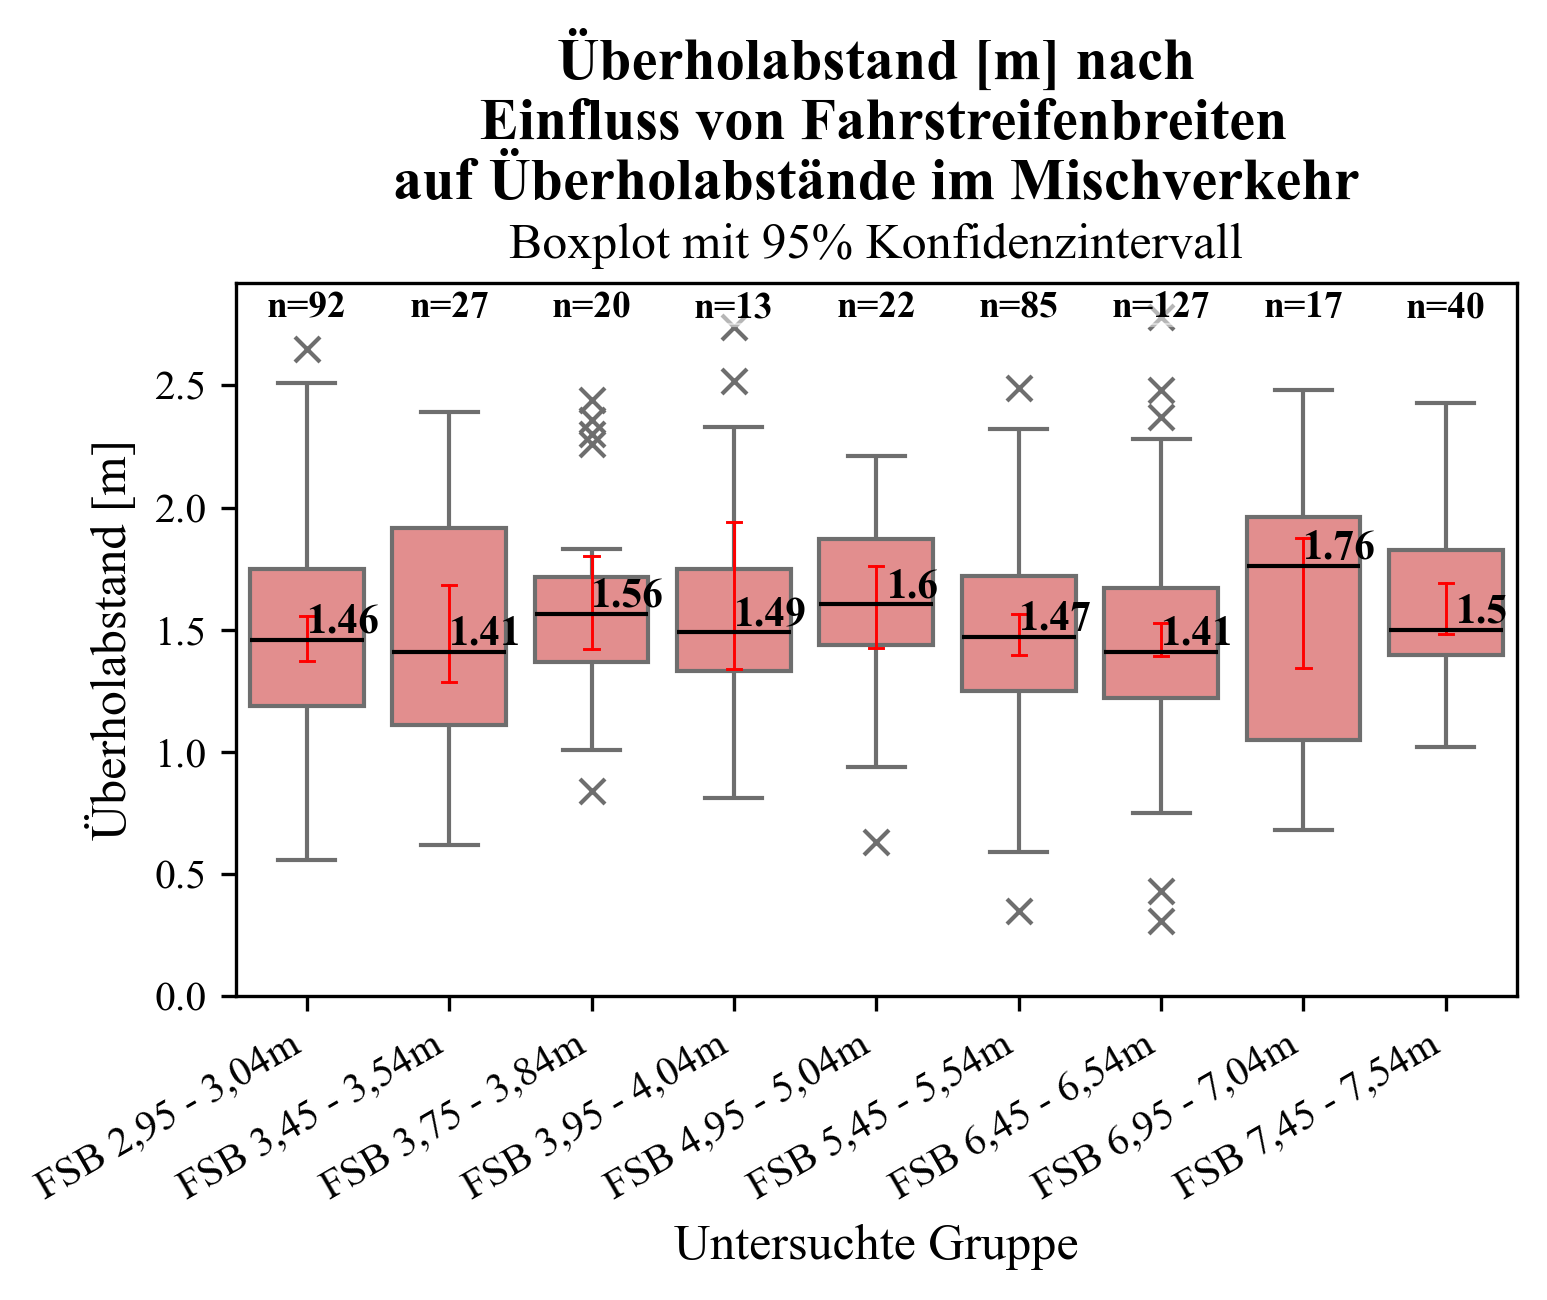

In [45]:
'''Erzeugen eines Boxplots, überlagert mit Konfidenzintervall'''

fig, ax = plt.subplots(figsize=(plt_breite,plt_hoehe), dpi=aufl) #Standardgröße: 14,8
    
#Datenaufbereitung: aus der Liste mit den einzelnen gdf wird ein neuer df erzeugt, in dem nur die benötigten Infos drin sind
pos = [''] * len(liste)      #Liste wirde benötigt, um die Reihenfolge der einzelnen Gruppen im Plot zu steuern.
df_plot = pd.DataFrame({('bez', krit_y)})   #Initiieren vom df aus dem geplottet werden soll
#zusammenfügen der Messwerte aus allen Gruppen in einem df
for i, row in liste.iterrows():
    pos[i] = row['order'], row['bez']   #füllen der Positionsliste mit Ordernummer und Bezeichnung (Liste mit 2er Tuplen)
    for j, row2 in row['gdf'].iterrows():
        df_this = pd.DataFrame({(row['bez'], row2[krit_y])})        #jeder Messwert innerhalb eines gdf
        #print(str(row['bez'] + '  ' + str(row2['osm_id']) +'  :  ' + str(row2['Radinfra'])))
        df_plot = pd.DataFrame(pd.concat([df_plot, df_this], ignore_index=True))  #wird an neuen df angehängt

                                          
df_plot.columns = df_plot.iloc[0].tolist()   #kopiert entsprechende Zeile als Spaltenüberschriften (Indizes). ToList() damit Index nicht mitgenommen wird 
df_plot.drop(labels=0, axis=0, inplace=True)        #löscht die entsprechende Zeile (wird nicht mehr gebraucht, da jetzt ja Überschrift)
df_plot.reset_index(drop=True, inplace=True) # setzt den Index der Zeilen zurück, sodass erster Eintrag wieder 0 ist.
pos.sort(key=lambda x: int(x[0]))            # sortiert Positionsliste nach erster Spalte und interpretiert Eintraege als int (sonst 1, 10, 11, 2, 3, 4...)
pos2 = [x[1] for x in pos]                   #kopiert in eine neue Liste nur die 2. Spalte der alten Liste


my_pal = {bez:
          "skyblue" if 'RFS' in bez and 'SSF' in bez 
          else "lightcoral" if 'Misch' in bez 
          else "skyblue" if 'FSB+Rad' in bez 
          else "lightcoral" if 'FSB' in bez 
          else "palegreen" if 'SSF' in bez 
          else "aquamarine" if 'RFS' in bez 
          else "skyblue" if '*streifen' in bez 
          else "navajowhite" if '+Park' in bez
          else "papayawhip" if '-Park' in bez
          else "silver" 
          for bez in liste.bez.unique()}


ax1 = sns.boxplot(
     data=df_plot, x='bez', y=krit_y, hue='bez', 
    legend=False,
    #notch=True,
    #positions=pos,
    showcaps=True,
    flierprops={"marker": "x"},
    order = pos2,
    #linewidth=1.5,
    #width = 0.3,
    dodge = False,
    #boxprops={"facecolor": (.4, .6, .8, .5)},
    medianprops={"color": "k"},
    palette=my_pal,
    ax=ax)
    #plt.boxplot(x = row['gdf']['distance_overtaker'], notch=False)

### add labels to ax1
# medians
medians = df_plot.groupby(['bez'])[krit_y].median()
medians = medians.reindex(pos2)
medians2 = medians.copy()        #zweite Liste. Für Zeiten/Datum können diese hier separat bearbeitet und angeschrieben werden

if krit_y == 'time_berlin_num':
    vertical_offset = 0.005 # offset from median for display
    for i in range(len(medians)):
        medians2[i] = mdates.num2date(medians[i]).strftime('%H:%M')
elif krit_y == 'date_berlin_num':
    vertical_offset = 0.005
    for i in range(len(medians)):
        medians2[i] = mdates.num2date(medians[i]).strftime('%Y.%m.%d')
else:
    vertical_offset = df_plot[krit_y].median() * 0.02 # offset from median for display
    for i in range(len(medians)):
        medians2.iloc[i] = round(medians.iloc[i], 2)
    
        
for xtick in ax1.get_xticks():
    ax1.text(xtick+0.25, medians.iloc[xtick] + vertical_offset, medians2.iloc[xtick], 
            horizontalalignment='center',
             size=10,
             color='k',
             weight='semibold')
    
# counts on top   
counts = df_plot.groupby(['bez'])[krit_y].count()  #.astype(int)
counts = counts.reindex(pos2)
counts = counts.fillna(0)      #ersetzt NaN durch 0. NaN lässt sich nicht kürzen/trunc()
#vertical_offset = 0.99 # offset from median for display

for xtick in ax1.get_xticks():
    ax1.text(xtick,df_plot[krit_y].max(),"n=" +str(math.trunc(float(counts.iloc[xtick]))), 
            horizontalalignment='center',
            size=9,
            color='k',
            weight='semibold',
            bbox=dict(facecolor='w', pad=0, edgecolor='w', alpha = 0.5)
            )
    
#Setzen der Anzahl der bootstrap durchgänge für Berechnung Konfidenzintervall
anz = 0
for j, row2 in liste.iterrows():
    anz = anz + len(df_plot['bez'])
if anz < 100:
    anz = 100    #-> Bootstrap mit min. 1000
elif anz > 5000:
    anz = 5000    #-> Bootstrap mit max. 50000.

### add CI
ax2= sns.barplot( 
    data=df_plot, x='bez', y=krit_y,
    #palette="Blues", 
    order = pos2,
    alpha=0.0,
    capsize=.1, 
    n_boot=10*anz, 
    seed=1234,
    errorbar=('ci', 95),
    err_kws={'color': 'red', 'linewidth': 0.7},
    ax=ax)

#Formatierung Beschriftung X-Achse
ax1.xaxis.set_tick_params(labelrotation=30)
plt.setp(ax1.xaxis.get_majorticklabels(), ha="right" )  #Alignment noch nicht in set_tick_params verfügbar.. :(

#ax2.set_xticklabels(ax2.get_xmajorticklabels(), rotation=30)

#Überschrift
ax1.text(x=0.5, y=1.1, s=besch_y +' nach\n '+liste['kriterium'][0], fontsize=14, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
ax1.set(title='Boxplot mit 95% Konfidenzintervall')
ax1.set_ylabel(besch_y)
ax1.set_xlabel('Untersuchte Gruppe')

if krit_y == 'time_berlin_num':
    #Y-Achse mit vollen Stunden beschriften
    plt.ylim(ymin=dt.datetime(1900, 1, 1, hour=0, minute=0), ymax=dt.datetime(1900, 1, 2, hour=0, minute=0)) #Setzen von Zeitgrenze auf x-axis zu genau ein Tag
    myFmt = mdates.DateFormatter('%H:%M')
    ax1.yaxis.set_major_formatter(myFmt)
    ax1.yaxis.set_major_locator(plt.LinearLocator(13)) #genau 12 Beschriftungen
if krit_y == 'date_berlin_num':
    myFmt = mdates.DateFormatter('%Y.%m.%d')
    ax1.yaxis.set_major_formatter(myFmt)
    #limits: Jahr, Monat und Tag vom kleinsten und größten Wert in Gesamtdatensatz
    plt.ylim(ymin=dt.datetime(int(min(gdf_klass['datetime_berlin']).strftime('%Y')), int(min(gdf_klass['datetime_berlin']).strftime('%m'))-1, int(min(gdf_klass['datetime_berlin']).strftime('%d')), hour=0, minute=0), ymax=dt.datetime(int(max(gdf_klass['datetime_berlin']).strftime('%Y')),int(max(gdf_klass['datetime_berlin']).strftime('%m'))+1, int(max(gdf_klass['datetime_berlin']).strftime('%d')), hour=23, minute=59)) #Setzen von Zeitgrenze auf x-axis zu genau ein Tag

#ax = plt.subplot(sharex=ax)
#plt.legend()
fig.savefig(MYDIR  + "/" + datum + "_Boxplot.png", dpi=aufl, bbox_inches="tight") 
plt.show()

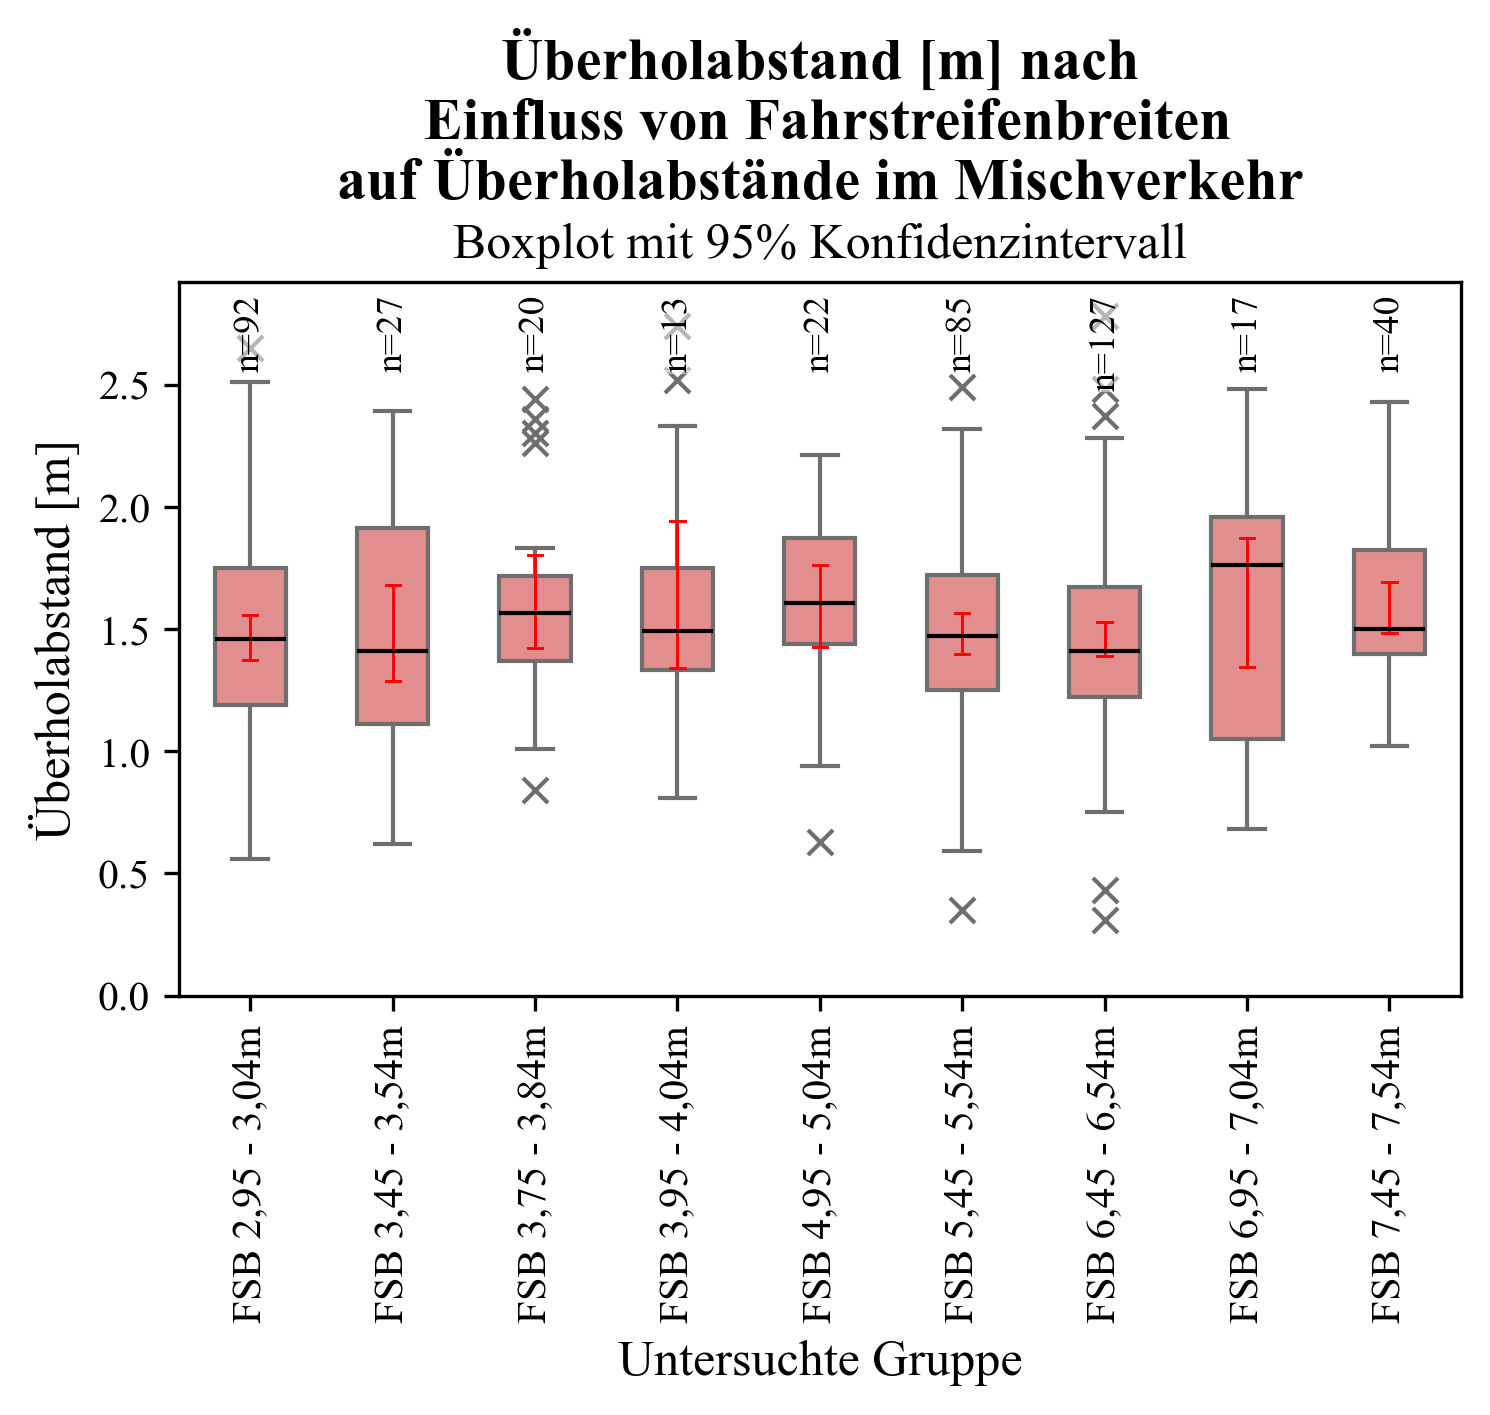

In [49]:
'''Erzeugen eines schmalen Boxplots, geeignet für viele Gruppen'''

fig, ax = plt.subplots(figsize=(plt_breite,plt_hoehe), dpi=aufl) #Standardgröße: 14,8
    
#Datenaufbereitung: aus der Liste mit den einzelnen gdf wird ein neuer df erzeugt, in dem nur die benötigten Infos drin sind
pos = [''] * len(liste)      #Liste wirde benötigt, um die Reihenfolge der einzelnen Gruppen im Plot zu steuern.
df_plot = pd.DataFrame({('bez', krit_y)})   #Initiieren vom df aus dem geplottet werden soll
#zusammenfügen der Messwerte aus allen Gruppen in einem df
for i, row in liste.iterrows():
    pos[i] = row['order'], row['bez']   #füllen der Positionsliste mit Ordernummer und Bezeichnung (Liste mit 2er Tuplen)
    for j, row2 in row['gdf'].iterrows():
        df_this = pd.DataFrame({(row['bez'], row2[krit_y])})        #jeder Messwert innerhalb eines gdf
        #print(str(row['bez'] + '  ' + str(row2['osm_id']) +'  :  ' + str(row2['Radinfra'])))
        df_plot = pd.DataFrame(pd.concat([df_plot, df_this], ignore_index=True))  #wird an neuen df angehängt

                                          
df_plot.columns = df_plot.iloc[0].tolist()   #kopiert entsprechende Zeile als Spaltenüberschriften (Indizes). ToList() damit Index nicht mitgenommen wird 
df_plot.drop(labels=0, axis=0, inplace=True)        #löscht die entsprechende Zeile (wird nicht mehr gebraucht, da jetzt ja Überschrift)
df_plot.reset_index(drop=True, inplace=True) # setzt den Index der Zeilen zurück, sodass erster Eintrag wieder 0 ist.
pos.sort(key=lambda x: int(x[0]))            # sortiert Positionsliste nach erster Spalte und interpretiert Eintraege als int (sonst 1, 10, 11, 2, 3, 4...)
pos2 = [x[1] for x in pos]                   #kopiert in eine neue Liste nur die 2. Spalte der alten Liste



#Ermitteln der zu verwendenden Farben anhand von Schlüsselwörtern in Gruppenbezeichnung
my_pal = {bez:
          "skyblue" if 'RFS' in bez and 'SSF' in bez 
          else "lightcoral" if 'Misch' in bez 
          else "skyblue" if 'FSB+Rad' in bez 
          else "lightcoral" if 'FSB' in bez 
          else "palegreen" if 'SSF' in bez 
          else "aquamarine" if 'RFS' in bez 
          else "skyblue" if '*streifen' in bez 
          else "navajowhite" if '+Park' in bez
          else "papayawhip" if '-Park' in bez
          else "silver" 
          for bez in liste.bez.unique()}


ax1 = sns.boxplot(
     data=df_plot, x='bez', y=krit_y, hue='bez', 
    legend=False,
    #notch=True,
    #positions=pos,
    showcaps=True,
    flierprops={"marker": "x"},
    order = pos2,
    #linewidth=1.5,
    width = 0.5,
    dodge = False,
    #boxprops={"facecolor": (.4, .6, .8, .5)},
    medianprops={"color": "k"},
    palette=my_pal,
    ax=ax)
    #plt.boxplot(x = row['gdf']['distance_overtaker'], notch=False)

### add labels to ax1
# medians
medians = df_plot.groupby(['bez'])[krit_y].median()
medians = medians.reindex(pos2)
medians2 = medians.copy()        #zweite Liste. Für Zeiten/Datum können diese hier separat bearbeitet und angeschrieben werden

if krit_y == 'time_berlin_num':
    vertical_offset = 0.005 # offset from median for display
    for i in range(len(medians)):
        medians2[i] = mdates.num2date(medians[i]).strftime('%H:%M')
elif krit_y == 'date_berlin_num':
    vertical_offset = 0.005
    for i in range(len(medians)):
        medians2[i] = mdates.num2date(medians[i]).strftime('%Y.%m.%d')
else:
    vertical_offset = df_plot[krit_y].median() * 0.02 # offset from median for display
    for i in range(len(medians)):
        medians2.iloc[i] = round(medians.iloc[i], 2)

#Aus Platzgründen auskommentiert
#for xtick in ax1.get_xticks():
#    ax1.text(xtick+0.25, medians.iloc[xtick] + vertical_offset, medians2.iloc[xtick], 
#            horizontalalignment='center',
#             size='small',
#             color='k',
#             weight='semibold')
    
# counts on top   
counts = df_plot.groupby(['bez'])[krit_y].count()  #.astype(int)
counts = counts.reindex(pos2)
counts = counts.fillna(0)
#vertical_offset = 0.99 # offset from median for display
for xtick in ax1.get_xticks():
    ax1.text(xtick,df_plot[krit_y].max()+0.09,"n=" +str(math.trunc(float(counts.iloc[xtick]))), 
            horizontalalignment='center',
            verticalalignment='top',
            size=9,
            color='k',
            #weight='semibold',
            rotation=90,
            bbox=dict(facecolor='w', pad=0, edgecolor='w', alpha = 0.5),
            )
    
#Setzen der Anzahl der bootstrap durchgänge für Berechnung Konfidenzintervall
anz = 0
for j, row2 in liste.iterrows():
    anz = anz + len(df_plot['bez'])
if anz < 100:
    anz = 100    #-> Bootstrap mit min. 1000
elif anz > 5000:
    anz = 5000    #-> Bootstrap mit max. 50000.


### add CI
ax2= sns.barplot( 
    data=df_plot, x='bez', y=krit_y,
    #palette="Blues", 
    order = pos2,
    alpha=0.0,
    capsize=.1, 
    n_boot=10*anz, 
    seed=1234,
    errorbar=('ci', 95),
    err_kws={'color': 'red', 'linewidth': 0.7},
    ax=ax)

#Formatierung Beschriftung X-Achse
ax1.xaxis.set_tick_params(labelrotation=90)
#plt.setp(ax1.xaxis.get_majorticklabels(), ha="right" )  #Alignment noch nicht in set_tick_params verfügbar.. :(

#ax2.set_xticklabels(ax2.get_xmajorticklabels(), rotation=30)

#Überschrift
ax1.text(x=0.5, y=1.1, s=besch_y +' nach\n '+liste['kriterium'][0], fontsize=14, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
ax1.set(title='Boxplot mit 95% Konfidenzintervall')
ax1.set_ylabel(besch_y)
ax1.set_xlabel('Untersuchte Gruppe')

if krit_y == 'time_berlin_num':
    #Y-Achse mit vollen Stunden beschriften
    plt.ylim(ymin=dt.datetime(1900, 1, 1, hour=0, minute=0), ymax=dt.datetime(1900, 1, 2, hour=0, minute=0)) #Setzen von Zeitgrenze auf x-axis zu genau ein Tag
    myFmt = mdates.DateFormatter('%H:%M')
    ax1.yaxis.set_major_formatter(myFmt)
    ax1.yaxis.set_major_locator(plt.LinearLocator(13)) #genau 12 Beschriftungen
if krit_y == 'date_berlin_num':
    myFmt = mdates.DateFormatter('%Y.%m.%d')
    ax1.yaxis.set_major_formatter(myFmt)
    #limits: Jahr, Monat und Tag vom kleinsten und größten Wert in Gesamtdatensatz
    plt.ylim(ymin=dt.datetime(int(min(gdf_klass['datetime_berlin']).strftime('%Y')), int(min(gdf_klass['datetime_berlin']).strftime('%m'))-1, int(min(gdf_klass['datetime_berlin']).strftime('%d')), hour=0, minute=0), ymax=dt.datetime(int(max(gdf_klass['datetime_berlin']).strftime('%Y')),int(max(gdf_klass['datetime_berlin']).strftime('%m'))+1, int(max(gdf_klass['datetime_berlin']).strftime('%d')), hour=23, minute=59)) #Setzen von Zeitgrenze auf x-axis zu genau ein Tag

#ax = plt.subplot(sharex=ax)
#plt.legend()
fig.savefig(MYDIR  + "/" + datum + "_Boxplot_schmal.png", dpi=aufl, bbox_inches="tight") 
plt.show()

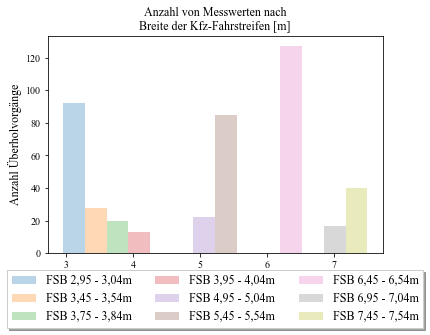

In [57]:
#--Berechnen von Anzahl Bins mit gleichen Abständen über alle Gruppen hinweg
#Setzen von Ausgangswerten

val_min = liste['gdf'][0][krit_x].dropna().min()
val_max = liste['gdf'][0][krit_x].dropna().max()

#Finden des insgesamt größten und kleinsten Wertes
for i, row in liste.iterrows():
    if row['gdf'][krit_x].dropna().min() < val_min:
        val_min = row['gdf'][krit_x].dropna().min()
    if row['gdf'][krit_x].dropna().max() > val_max:
        val_max = row['gdf'][krit_x].dropna().max()
#erzeugen eines Arrays mit vorgegebener Anzahl V  von Bins mit gleichen Abständen zwischen min und max
abstaende = np.linspace(val_min, val_max, num=15)

#Eintragen in den Plot für jede Gruppe
for i, row in liste.iterrows():
    plt.hist(row['gdf'][krit_x].dropna(), bins = abstaende, label = row['bez'], alpha = 0.3)


#Achsbezeichnung
plt.xlabel(besch_x)
plt.ylabel('Anzahl Überholvorgänge')
#Legende
plt.legend()
#Ueberschrift
label_head = 'Anzahl von Messwerten nach\n'+besch_x
plt.title(label_head)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=False, shadow=True, ncol=3)

plt.savefig(MYDIR + "/" + datum + "_Histogramm.png", dpi=aufl, bbox_inches="tight") 

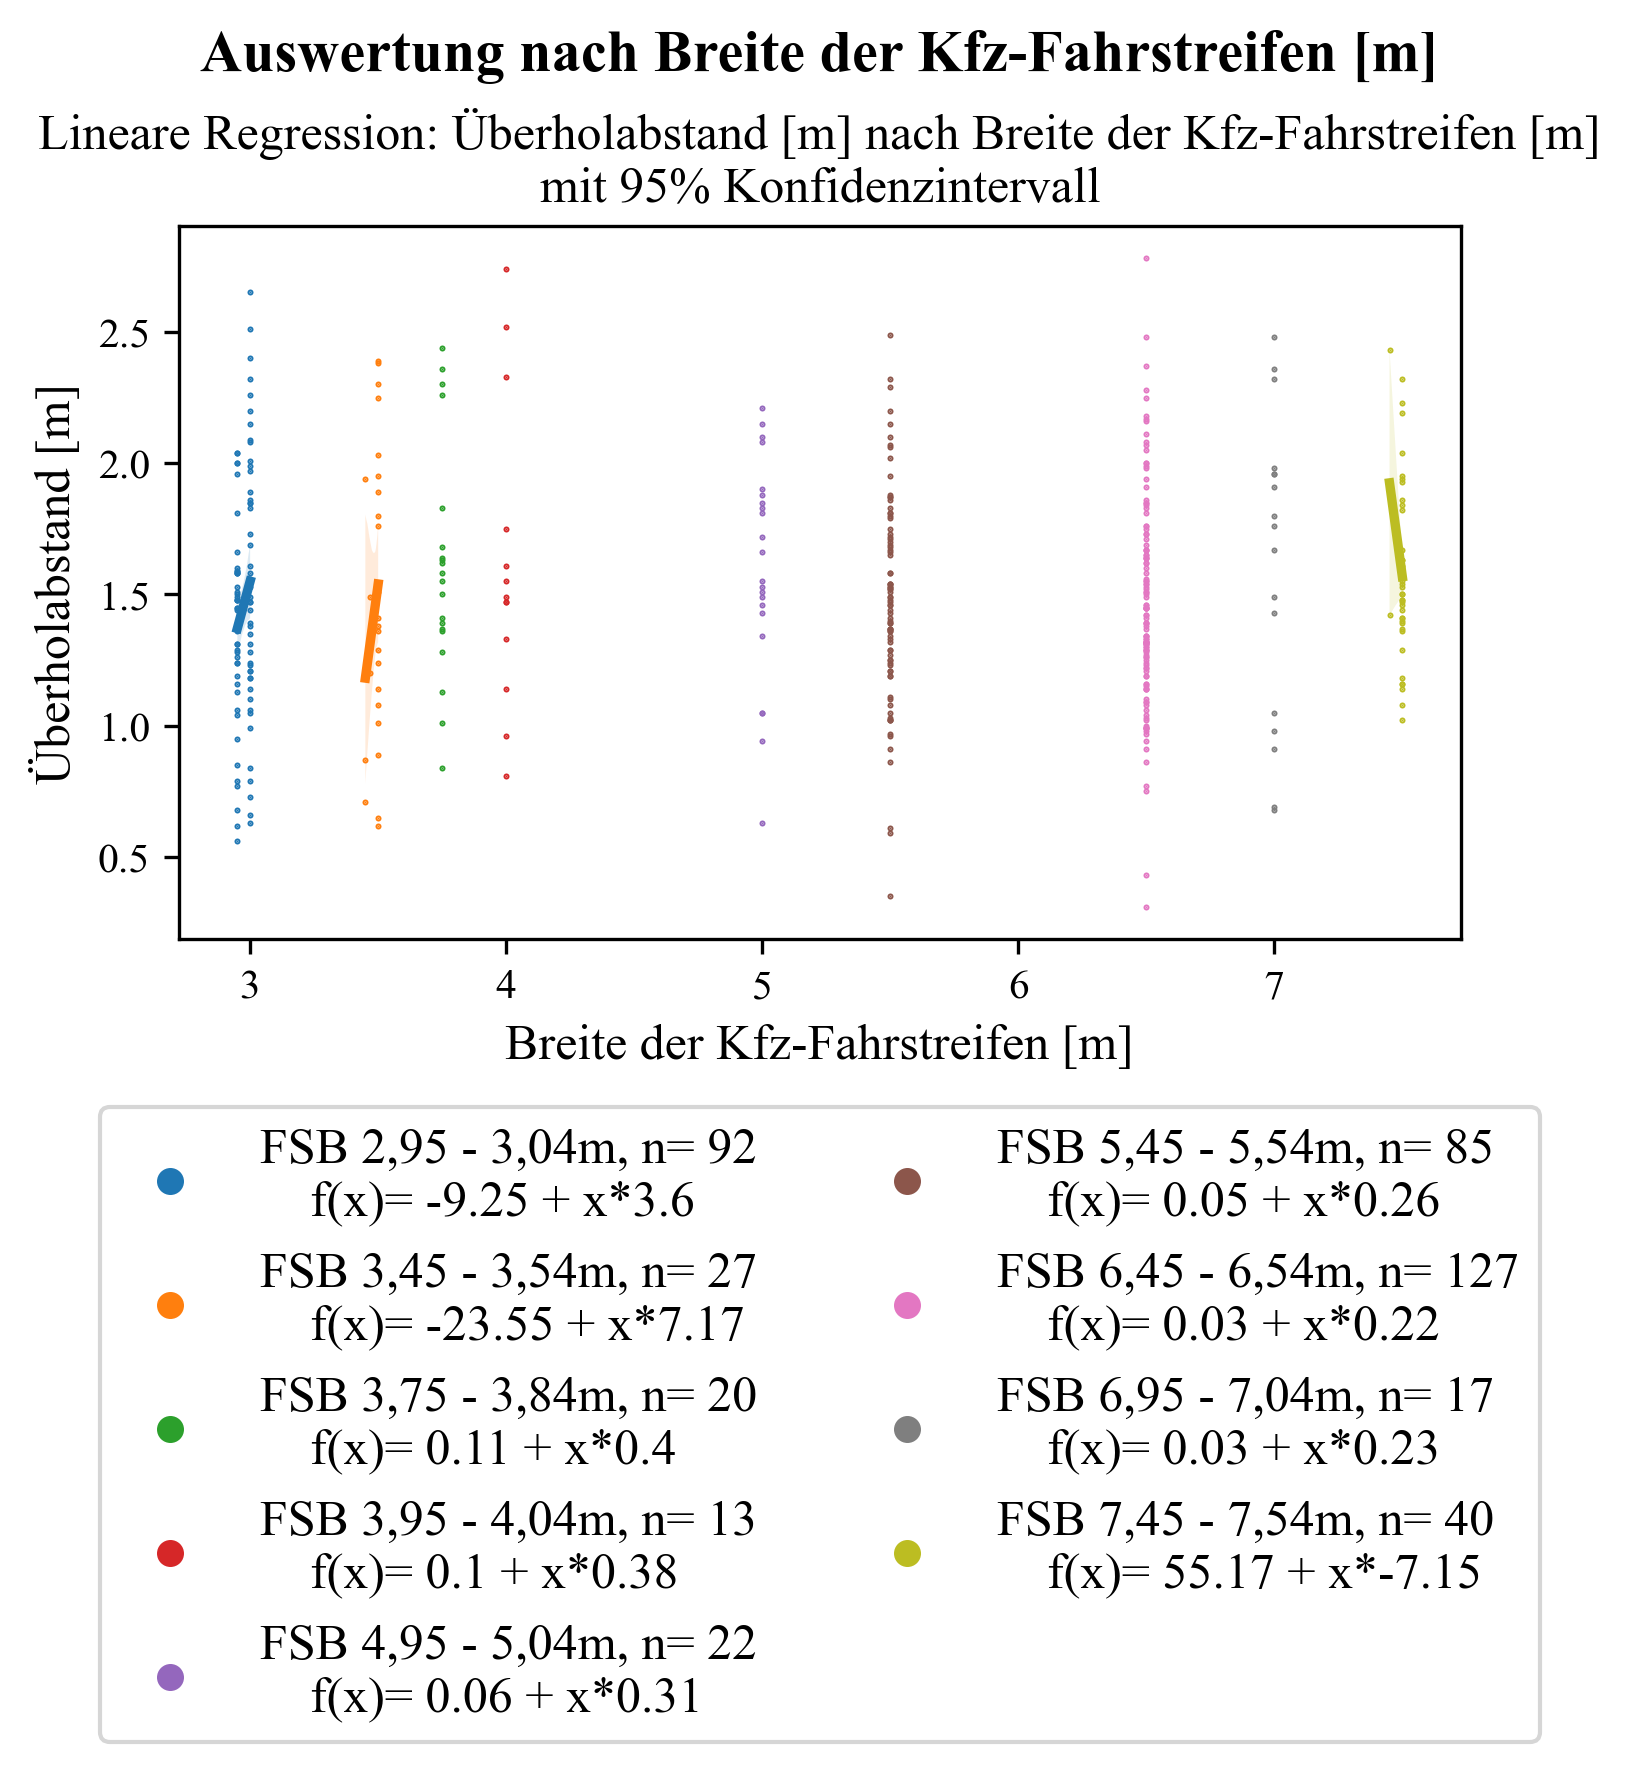

In [58]:
'''Erzeugen eines Regplots (lineare Regression), überlagert mit Konfidenzintervall'''

#warnings.filterwarnings('ignore') #Warnungen werden unterdrückt
# create the figure and axes
fig, ax = plt.subplots(figsize=(plt_breite,plt_hoehe), dpi=aufl)

kurve = kurve #Möglichkeit zum einfachen Überschreiben
#Seaborn nutzt https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html zur Berechnung (https://seaborn.pydata.org/generated/seaborn.regplot.html).
#Bei schlechtem Fit wird eine Warnung ausgegeben. Ich vermute, dass Seaborn dann die nächst niedrigere Order ausprobiert und dass dies 
#die Ursache dafür ist, dass bei einigen Gruppen Kurven mit höherer Order nicht ausgegeben werden.

#Größe der Stichprobe um das Bootstrapping für das Konfidenzintervall zu steuern bzw. reproduzierbar zu machen.
anzahl = 0
for j, row2 in liste.iterrows():
    anzahl = anzahl + len(row2['gdf'])
if anzahl < 100:
    anzahl = 100    #-> Bootstrap mit min. 1000
elif anzahl > 5000:
    anzahl = 5000    #-> Bootstrap mit max. 50000.
    


# add the plots for each dataframe
for i, row in liste.iterrows():
    gdf_data = row['gdf'].copy()
    gdf_data[krit_x] = gdf_data[krit_x].apply(lambda x: pd.to_numeric(x, errors='coerce'))   #ersetzt für Datensätze mit nicht numerischen Wert in krit_x diesen zu Nan
    gdf_data[krit_y] = gdf_data[krit_y].apply(lambda x: pd.to_numeric(x, errors='coerce'))   #ersetzt für Datensätze mit nicht numerischen Wert in krit_x diesen zu Nan

    #Berechnung der linearen Regression mit scipy stats bzw. polynomen Regression mit numpy
    try:
        if kurve == 1:  
            #https://realpython.com/linear-regression-in-python/#simple-linear-regression (Advanced Linear Regression With statsmodels)
            data_y = gdf_data[krit_y].copy()  #Datenaufbereitung
            data_x = gdf_data[krit_x].copy()
            data_x = sm.add_constant(data_x, has_constant='add')  #muss man hinzufügen, sonst wird (0,0) als Schnittpunkt mit X-Achse angenommen
            linReg = sm.OLS(data_y, data_x, missing = 'drop').fit()  #lineares fitting nach methode: Ordinary Least Squares
            fx = '\n    f(x)= ' + str(round(linReg.params.iloc[0],2)) + " + x*" + str(round(linReg.params.iloc[1],2))  #liest aus dem Ergebnis die Parameter für Steigungsfunktion aus
        elif kurve > 1:
            data_y = gdf_data.dropna(subset = [krit_x, krit_y])[krit_y].values  #Datenaufbereitung
            data_x = gdf_data.dropna(subset = [krit_x, krit_y])[krit_x].values
            idx = np.isfinite(data_x) & np.isfinite(data_y)   #macht, dass im nächsten Schritt kein Fehler bei nan werten kommt.
            polReg = (polyfit(data_x[idx], data_y[idx], deg=kurve, full=True))  #Fitting für Polynome
            #liest aus dem Ergebnis die Parameter für Kurvenfunktion aus
            fx = "\n    f(x)= "
            i = len(polReg[0]) - 1
            j = 0
            for coeff in polReg[0]:
                coeff = round(coeff,2)
                if kurve - j >= 2:
                    fx = fx + str(coeff) + "*x^" + str(i) + " + "
                if kurve - j == 1:
                    fx = fx +  str(coeff) + "x + "
                if kurve - j == 0:
                    fx = fx + str(coeff)
                i = i - 1
                j = j + 1
    except BaseException as e:
        #print(e)
        fx = '\n    f(x)= Berechnung nicht möglich.'
        
    sns.regplot(x=krit_x,                #Kriterium -> Wert für x-Achse aus "Liste" oben
                y=krit_y,                #Kriterium -> Wert für y-Achse aus "Liste" oben
                data=gdf_data,           #datenquelle
                fit_reg=True,            #Zeige lineare REgression (Tendenzlinie)
                #robust = True,           #geringere Gewichtung von Ausreißern. Achtung: Höherer Rechenaufwand
                order = kurve,           #Ordnung der Kurve. 1 = linie, > 1 = Anzahl extrempunkte
                x_jitter=0,              #Möglichkeit die Punkte entlang der x-Achse zufällig innerhalb des gesetzten Werts zu verschieben
                ci=95,                   #Wert für Konfidenzintervall
                n_boot=10*anzahl,        #definiert die Anzahl der Werte, die für das bootstrapping genutzt werden. möglichkeiten sind n^n. Gesetzt auf 10*n
                seed=1234,               #seed: Stellt sicher, das das Konfidenzintervall immer mit denselben Werten berechnet wird. Ansonsten ändert sich das mit jeder Berechnung 
                ax=ax,                   #?
                scatter_kws={'alpha':1.0, 's':0.2}, #Größe und Transparenz der Punkte
                label= (str(row['bez']) + ', n= ' + str(row['gdf'][row['gdf'].notna().loc[:, (krit_x,krit_y)].sum().idxmin()].count())) + str(fx))        #Beschriftung/Legende. Bei Fällen wo krit_x zutrifft, aber nicht distance overtaker, werden Reihen ohne krit_y nicht mitgezählt, da nicht ausgewertet
    
ax.set(ylabel=besch_y, xlabel=besch_x, title='Lineare Regression: '+ besch_y +' nach '+besch_x+'\nmit 95% Konfidenzintervall')
ax.text(x=0.5, y=1.20, s='Auswertung nach '+besch_x, fontsize=14, weight='bold', ha='center', va='bottom', transform=ax.transAxes)
ax.legend()
#Formatierung der Achsbeschriftung bei Datum oder Zeit
if krit_x == 'time_berlin_num':
    plt.xlim(xmin=dt.datetime(1900, 1, 1, hour=0, minute=0), xmax=dt.datetime(1900, 1, 2, hour=0, minute=0)) #Setzen von Zeitgrenze auf x-axis zu genau ein Tag
    myFmt = mdates.DateFormatter('%H:%M')   #Beschriftungsformat anlegen
    ax.xaxis.set_major_formatter(myFmt)     #Beschriftungsformat anwenden
    ax.xaxis.set_major_locator(plt.LinearLocator(13)) #genau 12 Beschriftungen
if krit_x == 'date_berlin_num':
    myFmt = mdates.DateFormatter('%Y.%m.%d')
    ax.xaxis.set_major_formatter(myFmt)
if krit_y == 'time_berlin_num':
    plt.ylim(ymin=dt.datetime(1900, 1, 1, hour=0, minute=0), ymax=dt.datetime(1900, 1, 2, hour=0, minute=0)) #Setzen von Zeitgrenze auf x-axis zu genau ein Tag
    myFmt = mdates.DateFormatter('%H:%M')
    ax.yaxis.set_major_formatter(myFmt)
    ax.yaxis.set_major_locator(plt.LinearLocator(13)) #genau 12 Beschriftungen
if krit_y == 'date_berlin_num':
    myFmt = mdates.DateFormatter('%Y.%m.%d')
    ax.yaxis.set_major_formatter(myFmt)
    
for lh in ax.legend_.legend_handles: 
    #lh.set_alpha(1)
    lh._sizes = [30]  #setzt die Größe der Symbole in der Legende
if len(liste) > 2 or kurve > 2:
    sns.move_legend(ax, "upper center", bbox_to_anchor=(0.5, -0.2), ncol = 2) # oben rechts: bbox_to_anchor=(1, 1.04)
    
fig.savefig(MYDIR  + "/" + datum + "_Regplot_"+str(kurve)+"-Ordnung.png", dpi=aufl, bbox_inches="tight") 
plt.show()

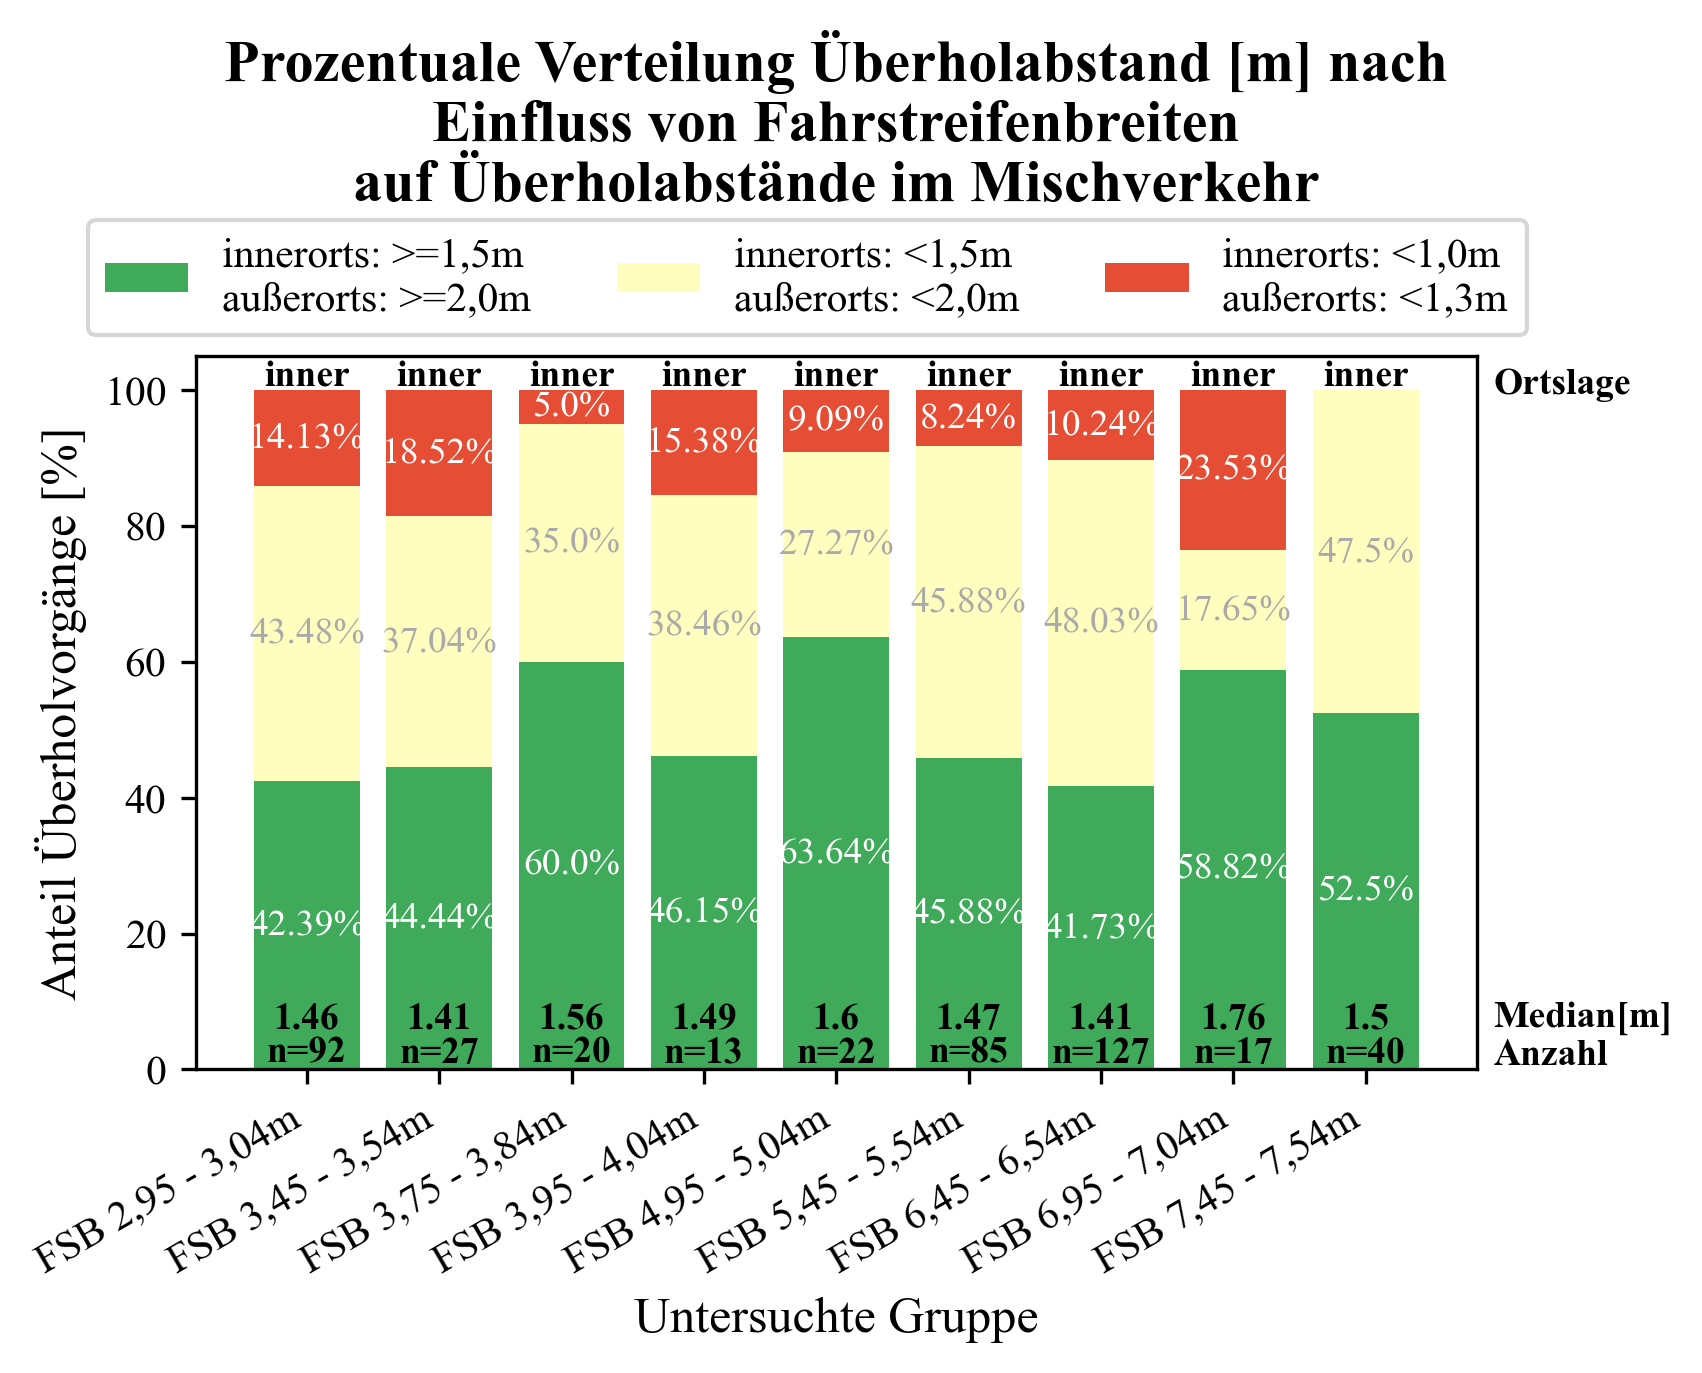

In [59]:
'''Erzeugen eines Stacked Barplots'''

#plotbreite = len(liste) * 1.5  #je mehr Gruppen, desto breiter der Plot
#if plotbreite < 8:
#    plotbreite = 8  #Mindestbreite, damit alle Beschriftungen (Legende, ggf. Hinweis) drauf passen

fig, ax = plt.subplots(figsize=(plt_breite,plt_hoehe), dpi=aufl) #Standardgröße: 14,8\n
#Namen für die Kategorien für Abbildung in Legende
categorys = ['innerorts: >=1,5m \naußerorts: >=2,0m', 'innerorts: <1,5m \naußerorts: <2,0m','innerorts: <1,0m \naußerorts: <1,3m']

#initiiert leerer dictionary
dict_plot = {}    #Initiieren vom dict für Prozente/Bins je Gruppe
dict_counts = {}  #dict für Anzahl der Messwerte je Gruppe (n=)
dict_med = {}     #dict für den Median der jeweiligen Gruppe
dict_lage = {}    #dict für Beschriftung mit Lage (inner/außerorts)
hinw = ""         #Hinweis, falls eine Gruppe keine Angabe zu inner / außerorts hat.
zeilennr = 0      #Zähler zum Eintragen von Werten in richtige Reihenfolge in dicts. i aus der Schleife führt aus irgendwelchen Gründen zu falschen zuordnungen...

#Füllen des dict mit Prozentwerten jeder gdf, getrennt für inner-/außerorts
for i, row in liste.iterrows(): 
    len_this = len(row['gdf']['distance_overtaker'].dropna())
    if len_this == 0:   #dann kommt es in der Berechnung der Prozente zu Fehlermeldung (Division by 0)
        len_this = 1
    if row['lage'] == "inner" or row['lage'] == "inner+" or row['lage'] is None:
        #Ermitteln der Prozente von Überholabständen innerhalb der angegebenen Grenzen
        sb1 = (len([ele for ele in row['gdf']['distance_overtaker'].dropna() if ele < 1.0]) / len_this) * 100
        sb15 = (len([ele for ele in row['gdf']['distance_overtaker'].dropna() if ele >= 1.0 and ele < 1.5]) / len_this) * 100
        sue15 = (len([ele for ele in row['gdf']['distance_overtaker'].dropna() if ele >= 1.5]) / len_this) * 100
        
        #Eintragen der Prozente in dict. Wenn Lage (inner/ausserorts) nicht definiert ist, wird Hinweis hinzugefügt.
        if row['lage'] is None:
            dict_plot[row['bez'] + " *)"] = [sue15, sb15, sb1] 
            hinw = "*) Gruppe kann Überholvorgänge enthalten, die inner- und außerorts stattgefunden haben"
        else:
            dict_plot[row['bez']] = [sue15, sb15, sb1]
                  
        dict_counts[zeilennr] = len(row['gdf']['distance_overtaker'].dropna())  #Anzahl der Überholabstände
        dict_med[zeilennr] = np.median(row['gdf']['distance_overtaker'].dropna()) #Median der Gruppe
        dict_lage[zeilennr] = row['lage']  # Lage ( inner/ausserorts)

    #Wie oben, aber ausserorts
    elif row['lage'] == "ausser" or row['lage'] == "ausser+":
        sb13 = (len([ele for ele in row['gdf']['distance_overtaker'].dropna() if ele < 1.3]) / len_this) * 100
        sb2 = (len([ele for ele in row['gdf']['distance_overtaker'].dropna() if ele >= 1.3 and ele < 2.0]) / len_this) * 100
        sue2 = (len([ele for ele in row['gdf']['distance_overtaker'].dropna() if ele >= 2.0]) / len_this) * 100
        
        #Eintragen der Prozente in dict. Wenn Lage (inner/ausserorts) nicht definiert ist, wird Hinweis hinzugefügt.
        if row['lage'] is None:
            dict_plot[row['bez'] + " *)"] = [sue2, sb2, sb13]
            hinw = "*) Berechnung unterscheidet nicht nach Überholvorgängen, die inner- und außerorts stattgefunden haben"
        else:
            dict_plot[row['bez']] = [sue2, sb2, sb13]
        dict_counts[zeilennr] = len(row['gdf']['distance_overtaker'].dropna())  #.astype(int)
        dict_med[zeilennr] = np.median(row['gdf']['distance_overtaker'].dropna())
        dict_lage[zeilennr] = row['lage']  # Lage ( inner/ausserorts)
    zeilennr = zeilennr + 1

#dict_plot["BA links"] = [90, 5, 5]

def make_stacked_barplot(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())  # Liste mit den Gruppenbezeichnungen
    data = np.array(list(results.values())) #Array mit Liste aus jeweils 3 Prozentwerten zu den Gruppen 
    data_cum = data.cumsum(axis=1)              #Summen und Zwischensummmen jeder Zeile/Gruppe (also Wert1, Wert1+Wert2, Wert1+2+3=100%)
    category_colors = plt.colormaps['RdYlGn_r'](
        np.linspace(0.15, 0.85, data.shape[1]))

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        heights = data[:, i]   #Prozente für Kategorien (grün, gelb, rot)
        starts = data_cum[:, i] - heights
        starts[starts == 100] = 99.9  #Startwert von 100 kommt nur vor, wenn nicht alle drei Kategorien einen Wert haben. Dann kommt es aber zu einer Fehldarstellung im Plot, daher an dieser Stelle ersetzt. 
        rects = ax.bar(x=labels,
                       height=heights, 
                       bottom=starts, 
                       #width=2.5,
                       align = 'center',
                       label=colname, 
                       color=color)

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        percents = []
        for wert in heights:
            if wert == 0:
                percents += ("",)
            else:
                percents += (str(round(wert, 2)) + "%",)
        #Beschrfitung mit Prozenten
        ax.bar_label(rects, percents, label_type='center', size=9, color=text_color)
    
    #Legende  
    ax.legend(ncols=len(category_names), bbox_to_anchor=(-0.1, 1),
              loc='lower left', fontsize=10)

    #zusätzliche Texte
    for xtick in ax.get_xticks():
        #Add counts (Bottom)
        ax.text(xtick, 1 ,"n=" + str(dict_counts[xtick]), 
                 horizontalalignment='center',
                 size=9,
                 color='k',
                 weight='semibold',
                 #bbox=dict(facecolor='w'),
                )
        #Add Median (Bottom, below counts)
        ax.text(xtick, 6 , str(round(dict_med[xtick],2)), 
                 horizontalalignment='center',
                 size=9,
                 color='k',
                 weight='semibold',
                 #bbox=dict(facecolor='w'),
                )
        #Add Lage (Top)
        ax.text(xtick, 100.5 ,str(dict_lage[xtick]), 
                 horizontalalignment='center',
                 size=9,
                 color='k',
                 weight='semibold',
                 #bbox=dict(facecolor='w'),
                )

       
        
    return fig, ax

#Aufrufen der Funktion zum Erstellen des Plots
make_stacked_barplot(dict_plot, categorys)

#Überschrift
ax.text(x=0.5, y=1.2, s= 'Prozentuale Verteilung ' + besch_y +' nach\n'+liste['kriterium'][0], fontsize=14, weight='bold', ha='center', va='bottom', transform=ax.transAxes)

ax.set_ylabel('Anteil Überholvorgänge [%]')
ax.set_xlabel('Untersuchte Gruppe')
fig.text(0.1, -0.2, hinw, ha='left')  
fig.text(x=0.91, y=0.13, s= 'Anzahl', fontsize=9, weight='bold', ha='left')
fig.text(x=0.91, y=0.17, s= 'Median[m]', fontsize=9, weight='bold', ha='left')
fig.text(x=0.91, y=0.84, s= 'Ortslage', fontsize=9, weight='bold', ha='left')#wird nur dargestellt wenn benötigt
    
#Formatierung Beschriftung X-Achse
ax.xaxis.set_tick_params(labelrotation=30)
plt.setp(ax.xaxis.get_majorticklabels(), ha="right" )  #Alignment noch nicht in set_tick_params verfügbar.. :(

fig.savefig(MYDIR  + "/" + datum + "_StackedBarplot.png", dpi=aufl, bbox_inches="tight")
plt.show()

In [60]:
'''Definition einer Funktion zum Überprüfen auf Normalverteilung'''

'''Berechnen von statistischen Kennwerten'''
def mean_confidence_interval(data_gdf, confidence):
    data = list(data_gdf['distance_overtaker'])
    a = 1.0 * np.array(data)
    n = len(a)
    m, h = np.mean(a), sms.DescrStatsW(a).tconfint_mean(1-confidence)
    med = np.median(data)
    std = np.std(data)
    b1 = (len([ele for ele in data if ele < 1.0]) / len(data)) * 100
    b15 = (len([ele for ele in data if ele < 1.5]) / len(data)) * 100
    b13 = (len([ele for ele in data if ele < 1.3]) / len(data)) * 100
    b2 = (len([ele for ele in data if ele < 2.0]) / len(data)) * 100
    ue15 = (len([ele for ele in data if ele >= 1.5]) / len(data)) * 100
    ue13 = (len([ele for ele in data if ele >= 1.3]) / len(data)) * 100
    ue2 = (len([ele for ele in data if ele >= 2.0]) / len(data)) * 100
    return m, h, med, std, b1, b13, b15, b2, ue13, ue15, ue2

'''Ausgabe statistischer Kennwerte, Überprüfen der Verteilung und Ausgabe des Ergebnisses'''
def check_verteilung(sample, name):
    plotimg = BytesIO()
    verteilung='unbekannt'
    signif = 0.05
    sample = sample.dropna(subset=['distance_overtaker']).copy()
    try:    #Zum Vermeiden von Fehlermeldung und Codeabbruch bei zu kleinen Gruppen.
        fig, ax = plt.subplots(1,2, figsize=(10,5))
        mean_this, ci_this, med_this, std_this, b1_t, b13_t, b15_t, b2_t, ue13_t, ue15_t, ue2_t = mean_confidence_interval(sample, 0.95)
        print("\n------------------------------------------------" +
               "\nGruppenbezeichnung: " + name +
              ", n= " + str(len(sample)) +
              "\nMittelwert: " + str(round(mean_this, 2)) +
              ", 95% Konfidenzintervall von: "+ str(round(ci_this[0],2)) +
              " bis: " + str(round(ci_this[1],2)) +
              "\nStandardabweichung: " + str(round(std_this, 2)) +
              "\nMedian: " + str(round(med_this, 2)) +
              "\nAnteil <1,0m: " + str(round(b1_t, 2)) + "%" +
              "\nAnteil <1,3m: " + str(round(b13_t, 2)) + "%" +
              "\nAnteil <1,5m: " + str(round(b15_t, 2)) + "%" +
              "\nAnteil <2,0m: " + str(round(b2_t, 2)) + "%" +
              "\nAnteil >=1,3m: " + str(round(ue13_t, 2)) + "%" +
              "\nAnteil >=1,5m: " + str(round(ue15_t, 2)) + "%" +
              "\nAnteil >=2,0m: " + str(round(ue2_t, 2)) + "%" 
             )
        
        myDoc.add_heading("\n------------------------------------------------\nGruppenbezeichnung: " + name, level=1)
        myDoc.add_paragraph("n= " + str(len(sample)) +
                            "\nMittelwert: " + str(round(mean_this, 2)) +
                            ", 95% Konfidenzintervall von: "+ str(round(ci_this[0],2)) +
                            " bis: " + str(round(ci_this[1],2)) +
                            "\nStandardabweichung: " + str(round(std_this, 2)) +
                            "\nMedian: " + str(round(med_this, 2)) +
                            "\nAnteil <1,0m: " + str(round(b1_t, 2)) + "%" +
                            "\nAnteil <1,3m: " + str(round(b13_t, 2)) + "%" +
                            "\nAnteil <1,5m: " + str(round(b15_t, 2)) + "%" +
                            "\nAnteil <2,0m: " + str(round(b2_t, 2)) + "%" +
                            "\nAnteil >=1,3m: " + str(round(ue13_t, 2)) + "%" +
                            "\nAnteil >=1,5m: " + str(round(ue15_t, 2)) + "%" +
                            "\nAnteil >=2,0m: " + str(round(ue2_t, 2)) + "%" 
                           )

        if len(sample) <= 4000:          #Für Datensätze mit mehr Werten nicht geeignet.
            print('--- Shapiro-Wilk-Test ---')
            myDoc.add_paragraph('--- Shapiro-Wilk-Test ---')
            res = shapiro(sample['distance_overtaker'].dropna())   #Test auf Normalverteilung        
            print("Stat: "+str(res.statistic) +", p: "+str(res.pvalue))
            myDoc.add_paragraph("Stat: "+str(res.statistic) +", p: "+str(res.pvalue))
            if res.pvalue > signif:
                verteilung = 'NORMAL'
            
            #------Achse 0, links ---
            #QQ-Plot auf Normalverteilung. Darstellung auf Axe 0 
            ax[0] = sm.qqplot(sample['distance_overtaker'].dropna(), dist=stats.distributions.norm, fit=True, line='45', ax=ax[0])
            
            #------Achse 1, rechts ---
            #Histogramm: density: nicht der Count, sondern nomalisiert, sodass summe aller Bin-Flächen=1 (Summe(Binhöhen*Binbreiten)), damit 
            ax[1] = plt.hist(sample['distance_overtaker'].dropna(), density=True, bins='auto')
            #ax[1] = plt.plot(sample['distance_overtaker'].dropna().groupby(sample['distance_overtaker'].round(1)).count(), "-", color='b')
            #--Berechnung für Normalverteilung
            s_mean = sample['distance_overtaker'].dropna().mean()
            s_sd = sample['distance_overtaker'].dropna().std()
            xmin, xmax = plt.xlim() #findet den Bereich, in dem Daten vorliegen 
            x = np.linspace(xmin, xmax, sample['distance_overtaker'].dropna().count())  #erzeugt in dem Bereich, in dem Daten sind, gleichverteilte Punkte. Somit entsteht eine schöne galtte Kurve für Normalverteilung
            ax[1] = plt.plot(x, norm.pdf(x, s_mean, s_sd), "-", color='r', label='Normalverteilung mit:\n Mean= '+str(round(s_mean, 2))+'\n Standardabw.='+str(round(s_sd ,2)))  #plottet Normalverteilung
            ax[1] = plt.xlabel('Überholabstand [m]')
            ax[1] = plt.ylabel('Wahrscheinlichkeitsdichte für Überholabstand')
            plt.legend(loc='upper left')
            plt.savefig(plotimg)
            myDoc.add_picture(plotimg, width=Inches(6))
            plt.show()
        else:
            print('--- Jarque-Bera-Test ---')
            myDoc.add_paragraph('--- Jarque-Bera-Test ---')
            res = jarque_bera(sample['distance_overtaker'].dropna())   #Test auf Normalverteilung   
            print("Stat: "+str(res.statistic) +", p: "+str(res.pvalue))
            myDoc.add_paragraph("Stat: "+str(res.statistic) +", p: "+str(res.pvalue))
            if res.pvalue > signif:
                verteilung = 'NORMAL'
            
            #------Achse 0, links ---
            #QQ-Plot auf Normalverteilung. Darstellung auf Axe 0 
            ax[0] = sm.qqplot(sample['distance_overtaker'].dropna(), dist=stats.distributions.norm, fit=True, line='45', ax=ax[0])
            
            #------Achse 1, rechts ---
            #Histogramm: density: nicht der Count, sondern nomalisiert, sodass summe aller Bin-Flächen=1 (Summe(Binhöhen*Binbreiten)), damit 
            ax[1] = plt.hist(sample['distance_overtaker'].dropna(), density=True, bins='auto')
            #ax[1] = plt.plot(sample['distance_overtaker'].dropna().groupby(sample['distance_overtaker'].round(1)).count(), "-", color='b')
            #--Berechnung für Normalverteilung
            s_mean = sample['distance_overtaker'].dropna().mean()
            s_sd = sample['distance_overtaker'].dropna().std()
            xmin, xmax = plt.xlim() #findet den Bereich, in dem Daten vorliegen 
            x = np.linspace(xmin, xmax, sample['distance_overtaker'].dropna().count())  #erzeugt in dem Bereich, in dem Daten sind, gleichverteilte Punkte. Somit entsteht eine schöne galtte Kurve für Normalverteilung
            ax[1] = plt.plot(x, norm.pdf(x, s_mean, s_sd), "-", color='r', label='Normalverteilung mit:\n Mean= '+str(round(s_mean, 2))+'\n Standardabw.='+str(round(s_sd, 2)))  #plottet Normalverteilung
            ax[1] = plt.xlabel('Überholabstand [m]')
            ax[1] = plt.ylabel('Wahrscheinlichkeitsdichte für Überholabstand')
            plt.legend(loc='upper left')
            plt.savefig(plotimg)
            myDoc.add_picture(plotimg, width=Inches(6))
            plt.show() 
    
    except BaseException as e:
        print("\n------------------------------------------------" + 
              "\nGruppenbezeichnung: " + name +
            ", n= " + str(len(sample)))
        
        myDoc.add_heading("\n------------------------------------------------\nGruppenbezeichnung: " + name, level=1)
        myDoc.add_paragraph("n= " + str(len(sample)))
        
        verteilung='unbekannt'
        print('Fehler in Berechnung: ' + str(e))
        myDoc.add_paragraph('Fehler in Berechnung: ' + str(e))
        ax[1].text(x=0.0, y=0.5, s='Auswertung fehlgeschlagen', fontsize=18, weight='bold', ha='center', va='bottom')
        plt.savefig(plotimg)
        myDoc.add_picture(plotimg, width=Inches(6))
        plt.show()
        #myDoc.add_heading("Auswertung fehlgeschlagen", level = 4)
        
    
    return (verteilung, signif)


------------------------------------------------
Gruppenbezeichnung: FSB 2,95 - 3,04m, n= 92
Mittelwert: 1.46, 95% Konfidenzintervall von: 1.37 bis: 1.56
Standardabweichung: 0.45
Median: 1.46
Anteil <1,0m: 14.13%
Anteil <1,3m: 36.96%
Anteil <1,5m: 57.61%
Anteil <2,0m: 84.78%
Anteil >=1,3m: 63.04%
Anteil >=1,5m: 42.39%
Anteil >=2,0m: 15.22%
--- Shapiro-Wilk-Test ---
Stat: 0.9843814373016357, p: 0.34152892231941223


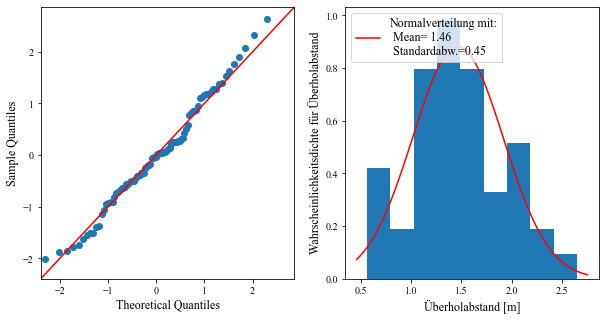

Die Verteilung ist: NORMAL
bei einem Signifikanzniveau von: 0.05

------------------------------------------------
Gruppenbezeichnung: FSB 3,45 - 3,54m, n= 27
Mittelwert: 1.48, 95% Konfidenzintervall von: 1.27 bis: 1.7
Standardabweichung: 0.52
Median: 1.41
Anteil <1,0m: 18.52%
Anteil <1,3m: 40.74%
Anteil <1,5m: 55.56%
Anteil <2,0m: 81.48%
Anteil >=1,3m: 59.26%
Anteil >=1,5m: 44.44%
Anteil >=2,0m: 18.52%
--- Shapiro-Wilk-Test ---
Stat: 0.9599107503890991, p: 0.3678748905658722


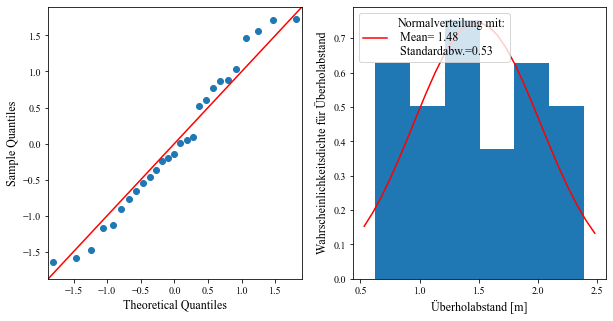

Die Verteilung ist: NORMAL
bei einem Signifikanzniveau von: 0.05

------------------------------------------------
Gruppenbezeichnung: FSB 3,75 - 3,84m, n= 20
Mittelwert: 1.61, 95% Konfidenzintervall von: 1.4 bis: 1.82
Standardabweichung: 0.43
Median: 1.56
Anteil <1,0m: 5.0%
Anteil <1,3m: 20.0%
Anteil <1,5m: 40.0%
Anteil <2,0m: 80.0%
Anteil >=1,3m: 80.0%
Anteil >=1,5m: 60.0%
Anteil >=2,0m: 20.0%
--- Shapiro-Wilk-Test ---
Stat: 0.9317297339439392, p: 0.16670995950698853


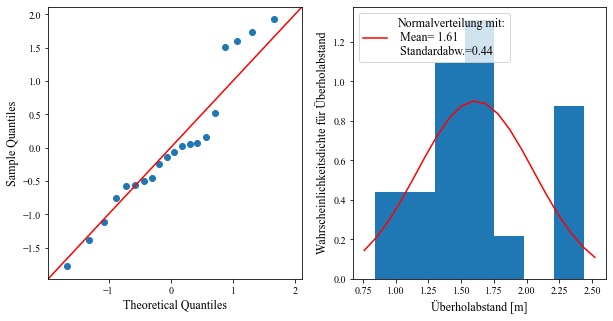

Die Verteilung ist: NORMAL
bei einem Signifikanzniveau von: 0.05

------------------------------------------------
Gruppenbezeichnung: FSB 3,95 - 4,04m, n= 13
Mittelwert: 1.63, 95% Konfidenzintervall von: 1.28 bis: 1.98
Standardabweichung: 0.56
Median: 1.49
Anteil <1,0m: 15.38%
Anteil <1,3m: 23.08%
Anteil <1,5m: 53.85%
Anteil <2,0m: 76.92%
Anteil >=1,3m: 76.92%
Anteil >=1,5m: 46.15%
Anteil >=2,0m: 23.08%
--- Shapiro-Wilk-Test ---
Stat: 0.9191182255744934, p: 0.24406741559505463


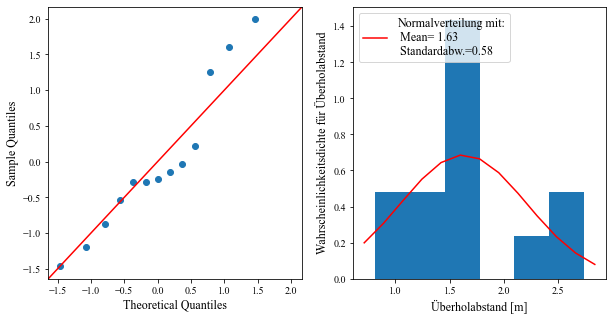

Die Verteilung ist: NORMAL
bei einem Signifikanzniveau von: 0.05

------------------------------------------------
Gruppenbezeichnung: FSB 4,95 - 5,04m, n= 22
Mittelwert: 1.6, 95% Konfidenzintervall von: 1.41 bis: 1.78
Standardabweichung: 0.41
Median: 1.6
Anteil <1,0m: 9.09%
Anteil <1,3m: 18.18%
Anteil <1,5m: 36.36%
Anteil <2,0m: 81.82%
Anteil >=1,3m: 81.82%
Anteil >=1,5m: 63.64%
Anteil >=2,0m: 18.18%
--- Shapiro-Wilk-Test ---
Stat: 0.9556666612625122, p: 0.406933069229126


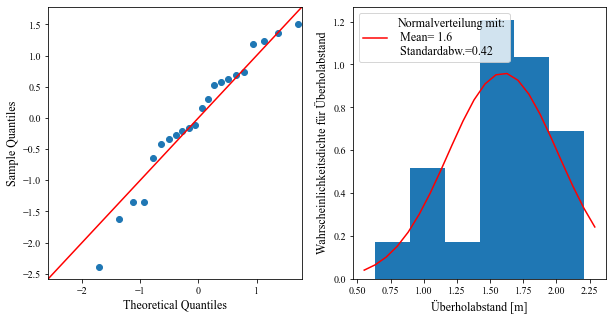

Die Verteilung ist: NORMAL
bei einem Signifikanzniveau von: 0.05

------------------------------------------------
Gruppenbezeichnung: FSB 5,45 - 5,54m, n= 85
Mittelwert: 1.48, 95% Konfidenzintervall von: 1.4 bis: 1.57
Standardabweichung: 0.39
Median: 1.47
Anteil <1,0m: 8.24%
Anteil <1,3m: 30.59%
Anteil <1,5m: 54.12%
Anteil <2,0m: 89.41%
Anteil >=1,3m: 69.41%
Anteil >=1,5m: 45.88%
Anteil >=2,0m: 10.59%
--- Shapiro-Wilk-Test ---
Stat: 0.9910659790039062, p: 0.8328469395637512


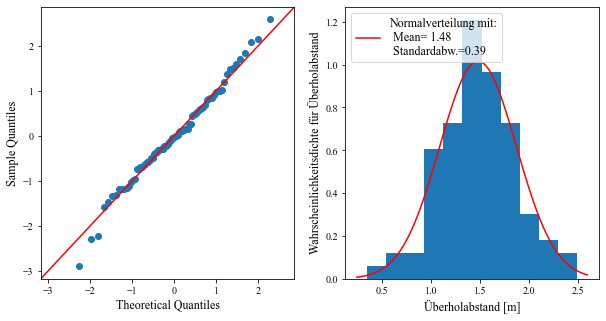

Die Verteilung ist: NORMAL
bei einem Signifikanzniveau von: 0.05

------------------------------------------------
Gruppenbezeichnung: FSB 6,45 - 6,54m, n= 127
Mittelwert: 1.46, 95% Konfidenzintervall von: 1.39 bis: 1.53
Standardabweichung: 0.4
Median: 1.41
Anteil <1,0m: 10.24%
Anteil <1,3m: 33.86%
Anteil <1,5m: 58.27%
Anteil <2,0m: 88.98%
Anteil >=1,3m: 66.14%
Anteil >=1,5m: 41.73%
Anteil >=2,0m: 11.02%
--- Shapiro-Wilk-Test ---
Stat: 0.980379581451416, p: 0.06226303428411484


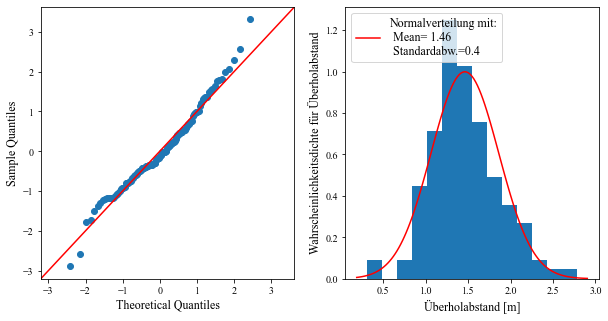

Die Verteilung ist: NORMAL
bei einem Signifikanzniveau von: 0.05

------------------------------------------------
Gruppenbezeichnung: FSB 6,95 - 7,04m, n= 17
Mittelwert: 1.61, 95% Konfidenzintervall von: 1.32 bis: 1.91
Standardabweichung: 0.56
Median: 1.76
Anteil <1,0m: 23.53%
Anteil <1,3m: 29.41%
Anteil <1,5m: 41.18%
Anteil <2,0m: 82.35%
Anteil >=1,3m: 70.59%
Anteil >=1,5m: 58.82%
Anteil >=2,0m: 17.65%
--- Shapiro-Wilk-Test ---
Stat: 0.9356053471565247, p: 0.26969459652900696


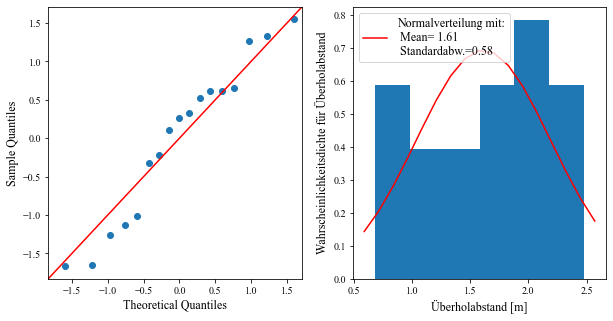

Die Verteilung ist: NORMAL
bei einem Signifikanzniveau von: 0.05

------------------------------------------------
Gruppenbezeichnung: FSB 7,45 - 7,54m, n= 40
Mittelwert: 1.59, 95% Konfidenzintervall von: 1.48 bis: 1.69
Standardabweichung: 0.34
Median: 1.5
Anteil <1,0m: 0.0%
Anteil <1,3m: 17.5%
Anteil <1,5m: 47.5%
Anteil <2,0m: 87.5%
Anteil >=1,3m: 82.5%
Anteil >=1,5m: 52.5%
Anteil >=2,0m: 12.5%
--- Shapiro-Wilk-Test ---
Stat: 0.9437031149864197, p: 0.04615743085741997


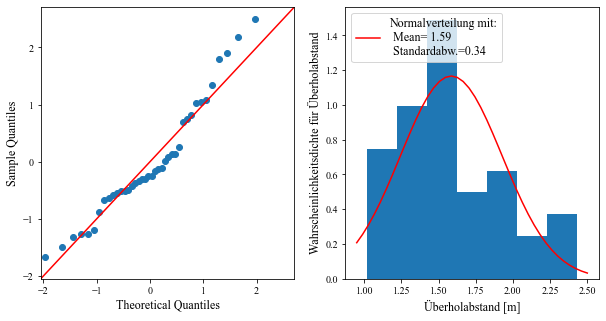

Die Verteilung ist: unbekannt
bei einem Signifikanzniveau von: 0.05


#######################################
 Es wird auf das Vorliegen einer Normalverteilung getestet. 
 Für Gruppen n > 4000 wird der Jarque Bera Test verwendet, für Gruppen n <= 4000 der Shapiro-Wilk-Test.

 --- Shapiro-Wilk-Test---
 Bei einem P-Wert über dem Signifikanzniveau kann die Aussage 'Die Gruppe ist normalverteilt' nicht abgelehnt werden.
 Für die weitere Berechnung wird dann eine Normalverteilung angenommen.
 Genutzte Funktion: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html

 --- Jarque-Bera-Test---
 Bei einem P-Wert über dem Signifikanzniveau kann die Aussage 'Die Gruppe ist normalverteilt' nicht abgelehnt werden.
 Für die weitere Berechnung wird dann eine Normalverteilung angenommen.
 Genutzte Funktion: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.jarque_bera.html

 Anhand der Grafiken kann das Ergebnis auf Plausibilität geprüft werden. Soll ein Ergebnis 

In [61]:
'''Ermitteln der statistischen Verteilung. '''

#Erstellt ein docx-Dokument, die Ergebnisse aus diesem und dem nächsten Schritt werden darin gespeichert.
myDoc = Document()
winsafeTitle = row['kriterium']
if "\n" in winsafeTitle:
    winsafeTitle = winsafeTitle.replace('\n', ' ')
myDoc.add_heading(datum + "_" + winsafeTitle, 0)
plotimg = BytesIO()

for i, row in liste.iterrows():
    row['verteilung'], niv = check_verteilung(row['gdf'],row['bez'])  
    #print(len(gdf_x['gdf']))
    #print(check_verteilung(row['gdf'],row['bez']) )
    #print(row['verteilung'])
    print("Die Verteilung ist: "+ row['verteilung'] +"\nbei einem Signifikanzniveau von: "+ str(niv))
    myDoc.add_paragraph("Die Verteilung ist: "+ row['verteilung'] +"\nbei einem Signifikanzniveau von: "+ str(niv))
    
disclaimer1 = ("\n\n#######################################\n \
Es wird auf das Vorliegen einer Normalverteilung getestet. \n \
Für Gruppen n > 4000 wird der Jarque Bera Test verwendet, für Gruppen n <= 4000 der Shapiro-Wilk-Test.\n\n \
--- Shapiro-Wilk-Test---\n \
Bei einem P-Wert über dem Signifikanzniveau kann die Aussage 'Die Gruppe ist normalverteilt' nicht abgelehnt werden.\n \
Für die weitere Berechnung wird dann eine Normalverteilung angenommen.\n \
Genutzte Funktion: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html\n\n \
--- Jarque-Bera-Test---\n \
Bei einem P-Wert über dem Signifikanzniveau kann die Aussage 'Die Gruppe ist normalverteilt' nicht abgelehnt werden.\n \
Für die weitere Berechnung wird dann eine Normalverteilung angenommen.\n \
Genutzte Funktion: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.jarque_bera.html\n\n \
Anhand der Grafiken kann das Ergebnis auf Plausibilität geprüft werden. Soll ein Ergebnis verändert werden, ist das durch Ausführen\n \
des folgenden Codes möglich:\n \
liste['verteilung'] = liste['verteilung'].where(liste['bez'] != 'HIER GRUPPENBEZEICHNUNG EINGEBEN', 'HIER NEUE VERTEILUNG EINGEBEN')\n \
Mögliche Werte für die neue Verteilung sind: 'NORMAL' und 'unbekannt'")

print(disclaimer1)
myDoc.add_paragraph(disclaimer1)

myDoc.save(MYDIR +"/"+ datum + "_" + winsafeTitle + ".docx")
plotimg.close()


In [66]:
'''NUR BEI BEDARF
Manuelle Anpassung der ermittelten Verteilung'''

#Mögliche Werte für die neue Verteilung sind: 'NORMAL' und 'unbekannt'
gruppenname = 'HIER_GRUPPENBEZEICHNUNG_EINGEBEN'
verteilung_neu = 'HIER_NEUE_VERTEILUNG_EINGEBEN'

#gruppenname = 'FSB 6,95 - 7,04m'
#verteilung_neu = 'unbekannt'

if gruppenname in liste['bez'].values:
    #ersetzt alle Einträge mit dem alten Wert, wenn der angegebene Gruppenname nicht gefunden wird. Sonst wird neuer Wert gesetzt
    liste['verteilung'] = liste['verteilung'].where(liste['bez'] != gruppenname, verteilung_neu)

    #Dokumentation der Veränderung im Word-Dok
    print("Verteilung der Gruppe " + gruppenname + " geänderte. Neuer Wert: " + verteilung_neu + ".")
    myDoc2 = Document(MYDIR +"/"+ datum + "_" + winsafeTitle + ".docx")
    myDoc2.add_heading("Änderung der Verteilung", level = 0)
    myDoc2.add_paragraph("Verteilung der Gruppe " + gruppenname + " geänderte. Neuer Wert: " + verteilung_neu + ".")
    myDoc2.save(MYDIR +"/"+ datum + "_" + winsafeTitle + ".docx")
else: 
    print("Der Gruppenname konnte nicht gefunden werden. Es wurde keine Änderung vorgenommen.")

for i, row in liste.iterrows():
    print(row['bez'], row['verteilung'])

Verteilung der Gruppe FSB 6,95 - 7,04m geänderte. Neuer Wert: unbekannt.
FSB 2,95 - 3,04m NORMAL
FSB 3,45 - 3,54m unbekannt
FSB 3,75 - 3,84m unbekannt
FSB 3,95 - 4,04m unbekannt
FSB 4,95 - 5,04m unbekannt
FSB 5,45 - 5,54m NORMAL
FSB 6,45 - 6,54m NORMAL
FSB 6,95 - 7,04m unbekannt
FSB 7,45 - 7,54m unbekannt


In [67]:
'''Definition einer Funktion zum checken, ob ein statistischer Unterschied zwischen den Gruppen besteht'''

def check_diff_mean(a, name_a, dist_a, b, name_b, dist_b):
    
    '''Achtung: Es werden alle Gruppen mit allen anderen verglichen. Die angewendeten Tests sind jedoch für unabhängige Datensätze
    bestimmt. Wenn es Gruppen gibt, die untereinander Schnittmengen haben, sind die Ergebnisse in den Fällen nicht belastbar.'''
    
    diff='statistisch NICHT relevant'
    res = pd.DataFrame()
    signifDiff = 0.05
    try:
        print("\n------------------------------------------------" + 
              "\n" + name_a + " (Verteilung:"+ dist_a+"), n= " + str(len(a)) + ", mean=" + str(round(a['distance_overtaker'].dropna().mean(),2)) + 
              "\n" + name_b + " (Verteilung:"+ dist_b+"), n= " + str(len(b)) + ", mean=" + str(round(b['distance_overtaker'].dropna().mean(),2)))
        
        myDoc3.add_heading("\n------------------------------------------------" + 
              "\n" + name_a + " (Verteilung:"+ dist_a+"), n= " + str(len(a)) + ", mean=" + str(round(a['distance_overtaker'].dropna().mean(),2)) + 
              "\n" + name_b + " (Verteilung:"+ dist_b+"), n= " + str(len(b)) + ", mean=" + str(round(b['distance_overtaker'].dropna().mean(),2)), level = 2)
        
        if dist_a == 'NORMAL' and dist_b == 'NORMAL':
            print( '--- Welch-Test ---') 
            myDoc3.add_paragraph('--- Welch-Test ---') 
            #Nullhypothese: Mean der beiden Gruppen ist GLEICH. 
            #wenn p größer 0.05 -> Means vsl. gleich
            #wenn p kleine 0.05 -> Means vsl. unterschiedlich.
            res = ttest(a['distance_overtaker'].dropna(), b['distance_overtaker'].dropna(), correction = True, confidence=0.95)
            #print(res)
            if res['p-val']['T-test'] < signifDiff:
                diff='statistisch relevant'
        else:
            print('--- Wilcoxon-Mann-Whitney-Test ---') 
            myDoc3.add_paragraph('--- Wilcoxon-Mann-Whitney-Test ---')
            res = mwu(a['distance_overtaker'].dropna(), b['distance_overtaker'].dropna())
            #print(res)
            if res['p-val']['MWU'] < signifDiff:
                diff='statistisch relevant'
    
    except BaseException as e:
        diff='Fehler in Berechnung: '
        res = str(e)
    
    #print(res)
    
    return (diff, res, signifDiff)

In [68]:
'''Statistische Gegenüberstellung aller in den Listen vorhandenen gdf '''

myDoc3 = Document(MYDIR +"/"+ datum + "_" + winsafeTitle + ".docx")
myDoc3.add_heading("Vergleich der Gruppen", level = 0)


for l in range(len(liste)):
    for k in range(l + 1, len(liste)):
        row_a = liste.iloc[l]
        row_b = liste.iloc[k]
        txt, full_res, nivDiff = check_diff_mean(row_a['gdf'], row_a['bez'], row_a['verteilung'], row_b['gdf'], row_b['bez'], row_b['verteilung'])
        print("Der Unterschied zwischen den Gruppen ist "+txt+"\nbei einem Signifikanzniveau von "+str(nivDiff))
        display(full_res)
        myDoc3.add_paragraph("Der Unterschied zwischen den Gruppen ist "+txt+"\nbei einem Signifikanzniveau von "+str(nivDiff) + "\n")
        
        try:
            t = myDoc3.add_table(full_res.shape[0]+1, full_res.shape[1])
            # add the header rows.
            for j in range(full_res.shape[-1]):
                t.cell(0,j).text = full_res.columns[j]
            
            # add the rest of the data frame
            for i in range(full_res.shape[0]):
                for j in range(full_res.shape[-1]):
                    t.cell(i+1,j).text = str(full_res.values[i,j])
        except BaseException as e:
            myDoc3.add_paragraph("Fehlermeldung: "+ str(e))
            
        

disclaimer2 = ("\n\n#######################################\n \
Es wird auf Gleichheit zwische den Gruppen getestet. Dabei wird angenommen, dass die Gruppen unabhängig voneinander sind. \n \
Für zwei normalverteilte Gruppen wird der T-Test verwendet. Ist die Verteilung bei mindestens einer\n \
der Gruppen nicht bekannt, wird der Wilcoxon-Mann-Whitney-Test verwendet.\n\n \
--- T-Test---\n \
Bei einem P-Wert unter dem Signifikanzniveau kann die Aussage 'Die Gruppen sind gleich' abgelehnt werden.\n \
Genutzte Funktion: https://pingouin-stats.org/build/html/generated/pingouin.ttest.html#pingouin.ttest\n\n \
--- Wilcoxon-Mann-Whitney-Test---\n \
Bei einem P-Wert unter dem Signifikanzniveau kann die Aussage 'Die Gruppen sind gleich' abgelehnt werden.\n \
Genutzte Funktion: https://pingouin-stats.org/build/html/generated/pingouin.mwu.html")

print(disclaimer2)
myDoc3.add_paragraph(disclaimer2)

myDoc3.save(MYDIR +"/"+ datum + "_" + winsafeTitle + ".docx")


------------------------------------------------
FSB 2,95 - 3,04m (Verteilung:NORMAL), n= 92, mean=1.46
FSB 3,45 - 3,54m (Verteilung:unbekannt), n= 28, mean=1.48
--- Wilcoxon-Mann-Whitney-Test ---
Der Unterschied zwischen den Gruppen ist statistisch NICHT relevant
bei einem Signifikanzniveau von 0.05


,U-val,alternative,p-val,RBC,CLES
MWU,1237.5,two-sided,0.97975,0.003623,0.498188



------------------------------------------------
FSB 2,95 - 3,04m (Verteilung:NORMAL), n= 92, mean=1.46
FSB 3,75 - 3,84m (Verteilung:unbekannt), n= 20, mean=1.61
--- Wilcoxon-Mann-Whitney-Test ---
Der Unterschied zwischen den Gruppen ist statistisch NICHT relevant
bei einem Signifikanzniveau von 0.05


,U-val,alternative,p-val,RBC,CLES
MWU,745.5,two-sided,0.186155,0.189674,0.405163



------------------------------------------------
FSB 2,95 - 3,04m (Verteilung:NORMAL), n= 92, mean=1.46
FSB 3,95 - 4,04m (Verteilung:unbekannt), n= 13, mean=1.63
--- Wilcoxon-Mann-Whitney-Test ---
Der Unterschied zwischen den Gruppen ist statistisch NICHT relevant
bei einem Signifikanzniveau von 0.05


,U-val,alternative,p-val,RBC,CLES
MWU,509.0,two-sided,0.389162,0.148829,0.425585



------------------------------------------------
FSB 2,95 - 3,04m (Verteilung:NORMAL), n= 92, mean=1.46
FSB 4,95 - 5,04m (Verteilung:unbekannt), n= 22, mean=1.6
--- Wilcoxon-Mann-Whitney-Test ---
Der Unterschied zwischen den Gruppen ist statistisch NICHT relevant
bei einem Signifikanzniveau von 0.05


,U-val,alternative,p-val,RBC,CLES
MWU,800.5,two-sided,0.129723,0.208992,0.395504



------------------------------------------------
FSB 2,95 - 3,04m (Verteilung:NORMAL), n= 92, mean=1.46
FSB 5,45 - 5,54m (Verteilung:NORMAL), n= 85, mean=1.48
--- Welch-Test ---
Der Unterschied zwischen den Gruppen ist statistisch NICHT relevant
bei einem Signifikanzniveau von 0.05


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.270552,174.310956,two-sided,0.787056,"[-0.14, 0.11]",0.040475,0.169,0.05824



------------------------------------------------
FSB 2,95 - 3,04m (Verteilung:NORMAL), n= 92, mean=1.46
FSB 6,45 - 6,54m (Verteilung:NORMAL), n= 127, mean=1.46
--- Welch-Test ---
Der Unterschied zwischen den Gruppen ist statistisch NICHT relevant
bei einem Signifikanzniveau von 0.05


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.061335,180.943613,two-sided,0.95116,"[-0.11, 0.12]",0.008568,0.15,0.050445



------------------------------------------------
FSB 2,95 - 3,04m (Verteilung:NORMAL), n= 92, mean=1.46
FSB 6,95 - 7,04m (Verteilung:unbekannt), n= 17, mean=1.61
--- Wilcoxon-Mann-Whitney-Test ---
Der Unterschied zwischen den Gruppen ist statistisch NICHT relevant
bei einem Signifikanzniveau von 0.05


,U-val,alternative,p-val,RBC,CLES
MWU,647.5,two-sided,0.263033,0.171995,0.414003



------------------------------------------------
FSB 2,95 - 3,04m (Verteilung:NORMAL), n= 92, mean=1.46
FSB 7,45 - 7,54m (Verteilung:unbekannt), n= 40, mean=1.59
--- Wilcoxon-Mann-Whitney-Test ---
Der Unterschied zwischen den Gruppen ist statistisch NICHT relevant
bei einem Signifikanzniveau von 0.05


,U-val,alternative,p-val,RBC,CLES
MWU,1534.5,two-sided,0.130943,0.166033,0.416984



------------------------------------------------
FSB 3,45 - 3,54m (Verteilung:unbekannt), n= 28, mean=1.48
FSB 3,75 - 3,84m (Verteilung:unbekannt), n= 20, mean=1.61
--- Wilcoxon-Mann-Whitney-Test ---
Der Unterschied zwischen den Gruppen ist statistisch NICHT relevant
bei einem Signifikanzniveau von 0.05


,U-val,alternative,p-val,RBC,CLES
MWU,228.0,two-sided,0.371835,0.155556,0.422222



------------------------------------------------
FSB 3,45 - 3,54m (Verteilung:unbekannt), n= 28, mean=1.48
FSB 3,95 - 4,04m (Verteilung:unbekannt), n= 13, mean=1.63
--- Wilcoxon-Mann-Whitney-Test ---
Der Unterschied zwischen den Gruppen ist statistisch NICHT relevant
bei einem Signifikanzniveau von 0.05


,U-val,alternative,p-val,RBC,CLES
MWU,152.0,two-sided,0.506528,0.133903,0.433048



------------------------------------------------
FSB 3,45 - 3,54m (Verteilung:unbekannt), n= 28, mean=1.48
FSB 4,95 - 5,04m (Verteilung:unbekannt), n= 22, mean=1.6
--- Wilcoxon-Mann-Whitney-Test ---
Der Unterschied zwischen den Gruppen ist statistisch NICHT relevant
bei einem Signifikanzniveau von 0.05


,U-val,alternative,p-val,RBC,CLES
MWU,251.5,two-sided,0.365663,0.153199,0.423401



------------------------------------------------
FSB 3,45 - 3,54m (Verteilung:unbekannt), n= 28, mean=1.48
FSB 5,45 - 5,54m (Verteilung:NORMAL), n= 85, mean=1.48
--- Wilcoxon-Mann-Whitney-Test ---
Der Unterschied zwischen den Gruppen ist statistisch NICHT relevant
bei einem Signifikanzniveau von 0.05


,U-val,alternative,p-val,RBC,CLES
MWU,1126.0,two-sided,0.886399,0.018736,0.490632



------------------------------------------------
FSB 3,45 - 3,54m (Verteilung:unbekannt), n= 28, mean=1.48
FSB 6,45 - 6,54m (Verteilung:NORMAL), n= 127, mean=1.46
--- Wilcoxon-Mann-Whitney-Test ---
Der Unterschied zwischen den Gruppen ist statistisch NICHT relevant
bei einem Signifikanzniveau von 0.05


,U-val,alternative,p-val,RBC,CLES
MWU,1734.0,two-sided,0.928057,-0.011374,0.505687



------------------------------------------------
FSB 3,45 - 3,54m (Verteilung:unbekannt), n= 28, mean=1.48
FSB 6,95 - 7,04m (Verteilung:unbekannt), n= 17, mean=1.61
--- Wilcoxon-Mann-Whitney-Test ---
Der Unterschied zwischen den Gruppen ist statistisch NICHT relevant
bei einem Signifikanzniveau von 0.05


,U-val,alternative,p-val,RBC,CLES
MWU,194.5,two-sided,0.405587,0.152505,0.423747



------------------------------------------------
FSB 3,45 - 3,54m (Verteilung:unbekannt), n= 28, mean=1.48
FSB 7,45 - 7,54m (Verteilung:unbekannt), n= 40, mean=1.59
--- Wilcoxon-Mann-Whitney-Test ---
Der Unterschied zwischen den Gruppen ist statistisch NICHT relevant
bei einem Signifikanzniveau von 0.05


,U-val,alternative,p-val,RBC,CLES
MWU,459.5,two-sided,0.306415,0.149074,0.425463



------------------------------------------------
FSB 3,75 - 3,84m (Verteilung:unbekannt), n= 20, mean=1.61
FSB 3,95 - 4,04m (Verteilung:unbekannt), n= 13, mean=1.63
--- Wilcoxon-Mann-Whitney-Test ---
Der Unterschied zwischen den Gruppen ist statistisch NICHT relevant
bei einem Signifikanzniveau von 0.05


,U-val,alternative,p-val,RBC,CLES
MWU,134.5,two-sided,0.882816,-0.034615,0.517308



------------------------------------------------
FSB 3,75 - 3,84m (Verteilung:unbekannt), n= 20, mean=1.61
FSB 4,95 - 5,04m (Verteilung:unbekannt), n= 22, mean=1.6
--- Wilcoxon-Mann-Whitney-Test ---
Der Unterschied zwischen den Gruppen ist statistisch NICHT relevant
bei einem Signifikanzniveau von 0.05


,U-val,alternative,p-val,RBC,CLES
MWU,208.0,two-sided,0.77208,0.054545,0.472727



------------------------------------------------
FSB 3,75 - 3,84m (Verteilung:unbekannt), n= 20, mean=1.61
FSB 5,45 - 5,54m (Verteilung:NORMAL), n= 85, mean=1.48
--- Wilcoxon-Mann-Whitney-Test ---
Der Unterschied zwischen den Gruppen ist statistisch NICHT relevant
bei einem Signifikanzniveau von 0.05


,U-val,alternative,p-val,RBC,CLES
MWU,970.0,two-sided,0.329421,-0.141176,0.570588



------------------------------------------------
FSB 3,75 - 3,84m (Verteilung:unbekannt), n= 20, mean=1.61
FSB 6,45 - 6,54m (Verteilung:NORMAL), n= 127, mean=1.46
--- Wilcoxon-Mann-Whitney-Test ---
Der Unterschied zwischen den Gruppen ist statistisch NICHT relevant
bei einem Signifikanzniveau von 0.05


,U-val,alternative,p-val,RBC,CLES
MWU,1523.0,two-sided,0.153647,-0.199213,0.599606



------------------------------------------------
FSB 3,75 - 3,84m (Verteilung:unbekannt), n= 20, mean=1.61
FSB 6,95 - 7,04m (Verteilung:unbekannt), n= 17, mean=1.61
--- Wilcoxon-Mann-Whitney-Test ---
Der Unterschied zwischen den Gruppen ist statistisch NICHT relevant
bei einem Signifikanzniveau von 0.05


,U-val,alternative,p-val,RBC,CLES
MWU,155.5,two-sided,0.669586,0.085294,0.457353



------------------------------------------------
FSB 3,75 - 3,84m (Verteilung:unbekannt), n= 20, mean=1.61
FSB 7,45 - 7,54m (Verteilung:unbekannt), n= 40, mean=1.59
--- Wilcoxon-Mann-Whitney-Test ---
Der Unterschied zwischen den Gruppen ist statistisch NICHT relevant
bei einem Signifikanzniveau von 0.05


,U-val,alternative,p-val,RBC,CLES
MWU,408.0,two-sided,0.906354,-0.02,0.51



------------------------------------------------
FSB 3,95 - 4,04m (Verteilung:unbekannt), n= 13, mean=1.63
FSB 4,95 - 5,04m (Verteilung:unbekannt), n= 22, mean=1.6
--- Wilcoxon-Mann-Whitney-Test ---
Der Unterschied zwischen den Gruppen ist statistisch NICHT relevant
bei einem Signifikanzniveau von 0.05


,U-val,alternative,p-val,RBC,CLES
MWU,133.0,two-sided,0.745623,0.06993,0.465035



------------------------------------------------
FSB 3,95 - 4,04m (Verteilung:unbekannt), n= 13, mean=1.63
FSB 5,45 - 5,54m (Verteilung:NORMAL), n= 85, mean=1.48
--- Wilcoxon-Mann-Whitney-Test ---
Der Unterschied zwischen den Gruppen ist statistisch NICHT relevant
bei einem Signifikanzniveau von 0.05


,U-val,alternative,p-val,RBC,CLES
MWU,610.5,two-sided,0.546979,-0.104977,0.552489



------------------------------------------------
FSB 3,95 - 4,04m (Verteilung:unbekannt), n= 13, mean=1.63
FSB 6,45 - 6,54m (Verteilung:NORMAL), n= 127, mean=1.46
--- Wilcoxon-Mann-Whitney-Test ---
Der Unterschied zwischen den Gruppen ist statistisch NICHT relevant
bei einem Signifikanzniveau von 0.05


,U-val,alternative,p-val,RBC,CLES
MWU,952.5,two-sided,0.363696,-0.153846,0.576923



------------------------------------------------
FSB 3,95 - 4,04m (Verteilung:unbekannt), n= 13, mean=1.63
FSB 6,95 - 7,04m (Verteilung:unbekannt), n= 17, mean=1.61
--- Wilcoxon-Mann-Whitney-Test ---
Der Unterschied zwischen den Gruppen ist statistisch NICHT relevant
bei einem Signifikanzniveau von 0.05


,U-val,alternative,p-val,RBC,CLES
MWU,104.5,two-sided,0.817889,0.054299,0.472851



------------------------------------------------
FSB 3,95 - 4,04m (Verteilung:unbekannt), n= 13, mean=1.63
FSB 7,45 - 7,54m (Verteilung:unbekannt), n= 40, mean=1.59
--- Wilcoxon-Mann-Whitney-Test ---
Der Unterschied zwischen den Gruppen ist statistisch NICHT relevant
bei einem Signifikanzniveau von 0.05


,U-val,alternative,p-val,RBC,CLES
MWU,258.5,two-sided,0.983503,0.005769,0.497115



------------------------------------------------
FSB 4,95 - 5,04m (Verteilung:unbekannt), n= 22, mean=1.6
FSB 5,45 - 5,54m (Verteilung:NORMAL), n= 85, mean=1.48
--- Wilcoxon-Mann-Whitney-Test ---
Der Unterschied zwischen den Gruppen ist statistisch NICHT relevant
bei einem Signifikanzniveau von 0.05


,U-val,alternative,p-val,RBC,CLES
MWU,1136.5,two-sided,0.121248,-0.215508,0.607754



------------------------------------------------
FSB 4,95 - 5,04m (Verteilung:unbekannt), n= 22, mean=1.6
FSB 6,45 - 6,54m (Verteilung:NORMAL), n= 127, mean=1.46
--- Wilcoxon-Mann-Whitney-Test ---
Der Unterschied zwischen den Gruppen ist statistisch NICHT relevant
bei einem Signifikanzniveau von 0.05


,U-val,alternative,p-val,RBC,CLES
MWU,1747.5,two-sided,0.061063,-0.250895,0.625447



------------------------------------------------
FSB 4,95 - 5,04m (Verteilung:unbekannt), n= 22, mean=1.6
FSB 6,95 - 7,04m (Verteilung:unbekannt), n= 17, mean=1.61
--- Wilcoxon-Mann-Whitney-Test ---
Der Unterschied zwischen den Gruppen ist statistisch NICHT relevant
bei einem Signifikanzniveau von 0.05


,U-val,alternative,p-val,RBC,CLES
MWU,177.0,two-sided,0.78781,0.053476,0.473262



------------------------------------------------
FSB 4,95 - 5,04m (Verteilung:unbekannt), n= 22, mean=1.6
FSB 7,45 - 7,54m (Verteilung:unbekannt), n= 40, mean=1.59
--- Wilcoxon-Mann-Whitney-Test ---
Der Unterschied zwischen den Gruppen ist statistisch NICHT relevant
bei einem Signifikanzniveau von 0.05


,U-val,alternative,p-val,RBC,CLES
MWU,479.5,two-sided,0.566074,-0.089773,0.544886



------------------------------------------------
FSB 5,45 - 5,54m (Verteilung:NORMAL), n= 85, mean=1.48
FSB 6,45 - 6,54m (Verteilung:NORMAL), n= 127, mean=1.46
--- Welch-Test ---
Der Unterschied zwischen den Gruppen ist statistisch NICHT relevant
bei einem Signifikanzniveau von 0.05


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,0.375853,182.334572,two-sided,0.707463,"[-0.09, 0.13]",0.052493,0.163,0.066074



------------------------------------------------
FSB 5,45 - 5,54m (Verteilung:NORMAL), n= 85, mean=1.48
FSB 6,95 - 7,04m (Verteilung:unbekannt), n= 17, mean=1.61
--- Wilcoxon-Mann-Whitney-Test ---
Der Unterschied zwischen den Gruppen ist statistisch NICHT relevant
bei einem Signifikanzniveau von 0.05


,U-val,alternative,p-val,RBC,CLES
MWU,586.0,two-sided,0.221975,0.188927,0.405536



------------------------------------------------
FSB 5,45 - 5,54m (Verteilung:NORMAL), n= 85, mean=1.48
FSB 7,45 - 7,54m (Verteilung:unbekannt), n= 40, mean=1.59
--- Wilcoxon-Mann-Whitney-Test ---
Der Unterschied zwischen den Gruppen ist statistisch NICHT relevant
bei einem Signifikanzniveau von 0.05


,U-val,alternative,p-val,RBC,CLES
MWU,1460.5,two-sided,0.205846,0.140882,0.429559



------------------------------------------------
FSB 6,45 - 6,54m (Verteilung:NORMAL), n= 127, mean=1.46
FSB 6,95 - 7,04m (Verteilung:unbekannt), n= 17, mean=1.61
--- Wilcoxon-Mann-Whitney-Test ---
Der Unterschied zwischen den Gruppen ist statistisch NICHT relevant
bei einem Signifikanzniveau von 0.05


,U-val,alternative,p-val,RBC,CLES
MWU,868.5,two-sided,0.192435,0.195461,0.40227



------------------------------------------------
FSB 6,45 - 6,54m (Verteilung:NORMAL), n= 127, mean=1.46
FSB 7,45 - 7,54m (Verteilung:unbekannt), n= 40, mean=1.59
--- Wilcoxon-Mann-Whitney-Test ---
Der Unterschied zwischen den Gruppen ist statistisch NICHT relevant
bei einem Signifikanzniveau von 0.05


,U-val,alternative,p-val,RBC,CLES
MWU,2021.5,two-sided,0.052067,0.204134,0.397933



------------------------------------------------
FSB 6,95 - 7,04m (Verteilung:unbekannt), n= 17, mean=1.61
FSB 7,45 - 7,54m (Verteilung:unbekannt), n= 40, mean=1.59
--- Wilcoxon-Mann-Whitney-Test ---
Der Unterschied zwischen den Gruppen ist statistisch NICHT relevant
bei einem Signifikanzniveau von 0.05


,U-val,alternative,p-val,RBC,CLES
MWU,375.0,two-sided,0.547265,-0.102941,0.551471




#######################################
 Es wird auf Gleichheit zwische den Gruppen getestet. Dabei wird angenommen, dass die Gruppen unabhängig voneinander sind. 
 Für zwei normalverteilte Gruppen wird der T-Test verwendet. Ist die Verteilung bei mindestens einer
 der Gruppen nicht bekannt, wird der Wilcoxon-Mann-Whitney-Test verwendet.

 --- T-Test---
 Bei einem P-Wert unter dem Signifikanzniveau kann die Aussage 'Die Gruppen sind gleich' abgelehnt werden.
 Genutzte Funktion: https://pingouin-stats.org/build/html/generated/pingouin.ttest.html#pingouin.ttest

 --- Wilcoxon-Mann-Whitney-Test---
 Bei einem P-Wert unter dem Signifikanzniveau kann die Aussage 'Die Gruppen sind gleich' abgelehnt werden.
 Genutzte Funktion: https://pingouin-stats.org/build/html/generated/pingouin.mwu.html


In [105]:
liste

,order,bez,kriterium,auswertung_x,auswertung_y,such_str,reg,freifeld,lage,rw_breite_min,rw_breite_max,puf_L,puf_R,fliess,kern,fsb,fsbRad,parken,rechter_wert,ltype_l,ltype_r,speed_min,speed_max,speed_kfz,time_from,time_to,date_from,date_to,location,gdf,verteilung,filter
0,1,+Parken,Vorhandensein Parkplätze,distance_stationary,None,.*,True,None,inner,None,None,None,None,None,None,None,None,Yes,0.05-999,None,None,None,None,None,None,None,None,None,None,distance_overtaker distance_stationary...,unbekannt,None
2,2,-Parken,Vorhandensein Parkplätze,distance_stationary,None,.*,True,None,inner,None,None,None,None,None,None,None,None,no,0.05-999,None,None,None,None,None,None,None,None,None,None,distance_overtaker distance_stationary...,unbekannt,None
1,3,Parken unbekannt,Vorhandensein Parkplätze,distance_stationary,None,.*,True,None,inner,None,None,None,None,None,None,None,None,unb,0.05-999,None,None,None,None,None,None,None,None,None,None,distance_overtaker distance_stationary...,unbekannt,None


In [107]:
'''Möglichkeit zur Ausgabe einzelner Gruppen als *.gpkg'''

nummer = 1  #benötigt wird Index (Zahl ganz links), NICHT der Eintrag aus der Spalte "order"

gdf_ausgabe = liste['gdf'][nummer]        #.sample(n=100) #gib zufällig X Messwerte aus
datum=date.today().strftime("%y%m%d")

gdf_ausgabe = gpd.GeoDataFrame(gdf_ausgabe, geometry='geometry', crs='EPSG:4326')
gdf_ausgabe = gdf_ausgabe.astype({'geometry_y':'string'})
gdf_ausgabe.to_file("../OSM-OBS_klass/Untergruppen/" + read_file[-11:-5] + "_OSM-OBS_Klass_"+liste['bez'][nummer]+"_"+datum+".gpkg", driver="GPKG")

In [ ]:


#---ab hier nur noch zum Testen verwendeter Restcode ---



In [38]:
pd.set_option('display.max_rows', None)
gdf_ausgabe = liste['gdf'][0]        #.sample(n=100) #gib zufällig X Messwerte aus
gdf_ausgabe.groupby(gdf_ausgabe['Fahrstreifenbreite']).count()

,distance_overtaker,distance_stationary,direction,way_id,course,speed,time,portal,osm_id,name,highway,ref,maxspeed,zone_traffic,lanes,lane_markings,lit,surface,bicycle,cycleway,cycleway_both,cycleway_left,cycleway_right,width,tracktype,smoothness,oneway,cycleway_lane,cycleway_both_lane,cycleway_right_lane,cycleway_left_lane,parking_lane_both,parking_lane_left,parking_lane_right,cycleway_separation_left,cycleway_separation_right,separation_left,separation_right,cycleway_bicycle,cycleway_both_bicycle,...,cycleway_both_marking_right,cycleway_both_traffic_sign,cycleway_both_marking_both,cycleway_right_buffer_right,cycleway_left_buffer_right,cycleway_both_buffer_right,cycleway_right_buffer_left,cycleway_left_buffer_left,cycleway_both_buffer_left,cycleway_right_buffer_both,cycleway_left_buffer_both,cycleway_both_buffer_both,cycleway_marking_both,cycleway_marking_left,cycleway_marking,cycleway_right_marking,cycleway_left_marking,cycleway_traffic_sign,parking_orientation,other_tags,geometry_y,Radinfra,Radwegbreite,PufferRechts,PufferLinks,GG-Radstreifen,GG-Radwegbreite,GG-PufferRechts,GG-PufferLinks,FSBundRad,Kernfahrbahn,Fahrbahn_Fliessverkehr,Ortslage,Geschwindigkeit_Numerisch,datetime_berlin,time_berlin,date_berlin,geometry,time_berlin_num,date_berlin_num
Fahrstreifenbreite,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.40,1,0,1,1,1,1,1,1,1,1,1,0,1,0,1,0,1,1,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1
1.00,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,0,1,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1
2.00,4,1,4,4,4,4,4,4,4,4,4,0,4,0,4,4,4,4,0,0,4,0,0,4,0,4,3,0,0,0,0,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,4,4,0,0,0,0,0,0,0,4,4,4,4,4,4,4,4,4,4,4
2.50,2,2,3,3,3,3,3,3,3,3,3,0,3,0,3,2,3,3,0,0,1,2,2,3,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,3,0,0,0,0,0,0,0,3,3,3,3,3,3,3,3,3,3,3
2.75,6,4,6,6,6,6,6,6,6,6,6,0,6,0,6,6,6,6,0,0,6,0,0,6,0,2,6,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,6,6,0,0,0,0,0,0,0,6,6,6,6,6,6,6,6,6,6,6
2.95,44,6,44,44,44,44,44,44,44,44,44,0,44,0,44,44,44,44,0,0,0,44,44,44,0,44,0,0,0,0,44,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,44,44,44,0,0,0,44,44,0,0,44,44,44,44,44,44,44,44,44,44,44
3.00,48,14,48,48,48,48,48,48,48,48,48,0,48,0,48,47,23,48,4,1,18,29,29,48,0,21,22,0,0,0,25,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,48,48,48,0,0,0,25,25,0,0,48,48,48,48,48,48,48,48,48,48,48
3.17,5,4,5,5,5,5,5,5,5,5,5,0,5,0,5,5,5,5,0,0,5,0,0,5,0,5,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,5,5,0,0,0,0,0,0,0,5,5,5,5,5,5,5,5,5,5,5
3.20,3,3,3,3,3,3,3,3,3,3,3,0,3,0,3,3,3,3,0,0,3,0,0,3,0,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,3,0,0,0,0,0,0,0,3,3,3,3,3,3,3,3,3,3,3


In [42]:
##liste['gdf'][2].groupby(['Ortslage']).count()
#liste['gdf'][1].dropna(subset=['distance_overtaker']).groupby('distance_overtaker')['distance_overtaker'].count()
len(liste['gdf'][1]['distance_overtaker'].dropna())

9972

In [200]:
np.random.seed(123)

x = np.random.normal(loc=7, size=20)

y = np.random.normal(loc=7, size=30)

mwu(x, y)

,U-val,alternative,p-val,RBC,CLES
MWU,322.0,two-sided,0.67028,-0.073333,0.536667


In [57]:
liste['gdf'][0][liste['gdf'][0]['distance_overtaker']<1.5].count()
liste['gdf'][0].count()

distance_overtaker     5200
distance_stationary    2238
direction              5254
way_id                 5254
course                 5254
                       ... 
time_berlin            5254
date_berlin            5254
geometry               5254
time_berlin_num        5254
date_berlin_num        5254
Length: 108, dtype: int64

sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7fc87bc94160>


In [39]:
#liste=None
liste
#len(liste.iloc[0,4])
liste['gdf'][0]['distance_stationary'].max()

2.86

sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f3796066460>


In [115]:

for i, row in liste.iterrows():
    print(row['gdf']['Kernfahrbahn'].describe())
    
#Berechnung Confidence-Interval mit 95%
    n_obs = row['gdf']['distance_overtaker'].count()  # Number of observations
    m_obs = row['gdf']['distance_overtaker'].mean() # Observed mean
    v_obs = row['gdf']['distance_overtaker'].var(ddof=1) / n_obs   # Observed variance (unbiased)
    t = stats.t(df=n_obs - 1, loc=m_obs, scale=np.sqrt(v_obs))   # Declare random variable with observed parameters
    # Calculate 95% CI
    print(t.interval(alpha=0.95))


count    827.000000
mean       7.368803
std        3.229944
min        0.000000
25%        5.000000
50%        6.000000
75%        9.000000
max       15.500000
Name: Kernfahrbahn, dtype: float64
(1.5503234475541392, 1.5661755117511071)
count    2794.000000
mean        5.700268
std         0.958066
min         3.500000
25%         5.100000
50%         5.700000
75%         5.900000
max        10.500000
Name: Kernfahrbahn, dtype: float64
(1.37501507579356, 1.4045090574491323)
count    212.000000
mean       6.152594
std        2.136022
min        0.800000
25%        4.100000
50%        7.200000
75%        8.000000
max        9.800000
Name: Kernfahrbahn, dtype: float64
(1.6316958244053774, 1.7213638770871604)


/home/lukas/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:500: DeprecationWarning: Use of keyword argument 'alpha' for method 'interval' is deprecated and wil be removed in SciPy 1.11.0. Use first positional argument or keyword argument 'confidence' instead.
  return self.dist.interval(confidence, *self.args, **self.kwds, **kwds)
/home/lukas/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:500: DeprecationWarning: Use of keyword argument 'alpha' for method 'interval' is deprecated and wil be removed in SciPy 1.11.0. Use first positional argument or keyword argument 'confidence' instead.
  return self.dist.interval(confidence, *self.args, **self.kwds, **kwds)
/home/lukas/anaconda3/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:500: DeprecationWarning: Use of keyword argument 'alpha' for method 'interval' is deprecated and wil be removed in SciPy 1.11.0. Use first positional argument or keyword argument 'confidence'

/home/lukas/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


TypeError: object of type 'numpy.float64' has no len()

sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x7f3ebf48d820>


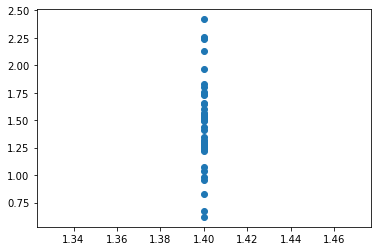

In [39]:
data_y = gdf_data.dropna(subset = [krit_x, krit_y])[krit_y].values  #Datenaufbereitung
data_x = gdf_data.dropna(subset = [krit_x, krit_y])[krit_x].values

idx = np.isfinite(data_x) & np.isfinite(data_y)

polReg = np.poly1d(polyfit(data_x[idx], data_y[idx], deg=3))

#intervall = np.linspace(np.amin(data_y), np.amax(data_y), len(data_x))
intervall = np.linspace(np.amin(data_x), np.amax(data_x), 100)
plt.plot(data_x, data_y, 'o')
plt.plot(intervall, polReg(intervall), '-')

def f(x):
    return polReg[3]*x**3+polReg[2]*x**2+polReg[1]*x+polReg[0]


plt.plot(intervall, f(intervall), '-')

fx = ""
i = len(polReg[0])
j = 0
for coeff in polReg[0]:
    coeff = round(coeff,2)
    if len(polReg) - j >= 2:
        fx = fx + str(coeff) + "*x^" + str(i) + " + "
    if len(polReg) - j == 1:
        fx = fx +  str(coeff) + "x + "
    if len(polReg) - j == 0:
        fx = fx + str(coeff)
    i = i - 1
    j = j + 1
    
print(fx)
#fx =

plt.show()